<a href="https://colab.research.google.com/github/Khunapat/Exxonmobile-Hackhaton/blob/main/Graphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

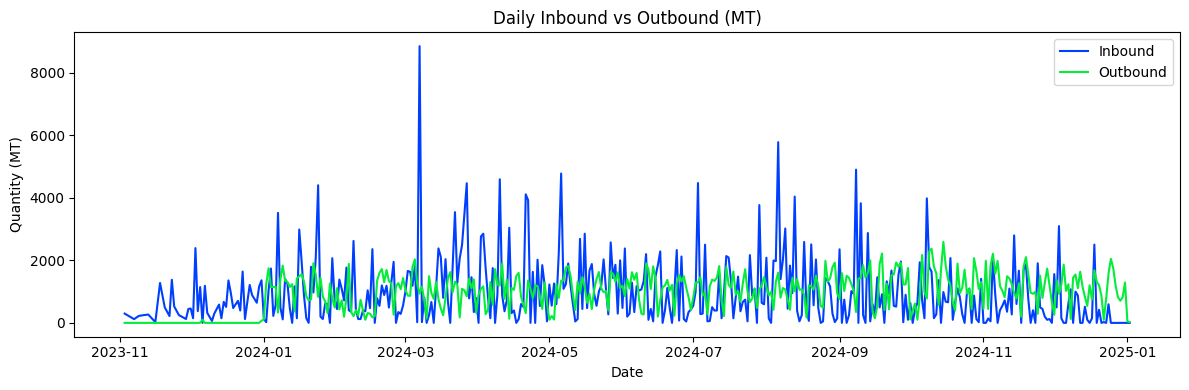

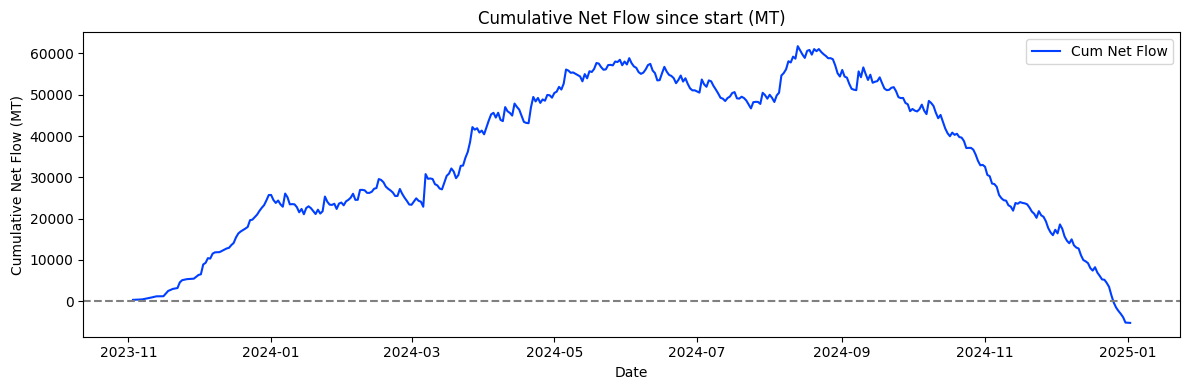

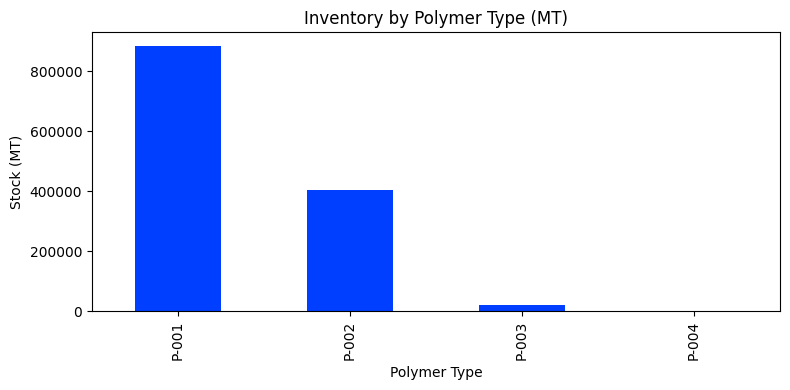

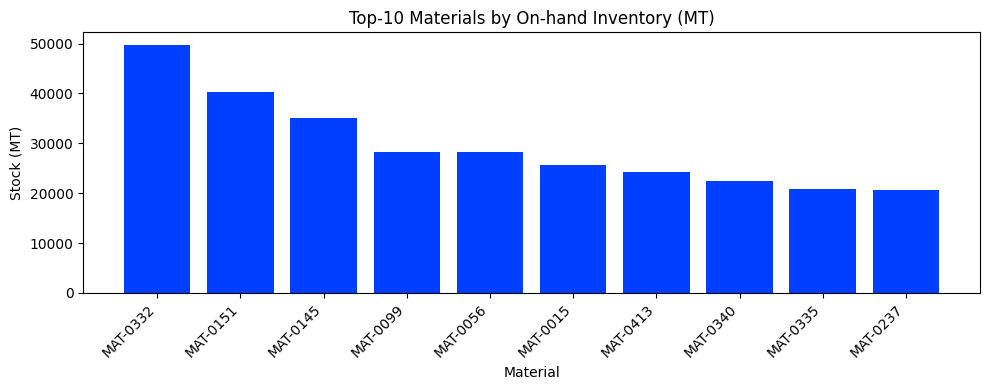

In [ ]:
#!/usr/bin/env python3
"""
Quick-look EDA for overflow-risk in polymer-chemicals warehouse
--------------------------------------------------------------
Creates four plots:
 A) Daily inbound vs outbound tonnage
 B) Cumulative net-flow (proxy for on-hand inventory)
 C) Current inventory by polymer type
 D) Top-10 materials by on-hand stock
"""

# --- 0. Imports --------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. File locations -------------------------------------------------------
DATA_DIR = Path('.')          # adjust if your csv/xlsx files live elsewhere
inv_file   = DATA_DIR/'Inventory.csv'
inb_file   = DATA_DIR/'Inbound.csv'
outb_file  = DATA_DIR/'Outbound.csv'
mat_file   = DATA_DIR/'MaterialMaster.csv'

# --- 2. Parameters -----------------------------------------------------------
KG_PER_MT = 1_000             # change if units differ
WAREHOUSE_CAPACITY_MT = None  # e.g. 50_000  → dashed line on plot B

# --- 3. Load & tidy ----------------------------------------------------------
inventory = pd.read_csv(inv_file)
inbound   = pd.read_csv(inb_file)
outbound  = pd.read_csv(outb_file)
material  = pd.read_csv(mat_file)

# Ensure date columns are datetime
inventory['BALANCE_AS_OF_DATE'] = pd.to_datetime(inventory['BALANCE_AS_OF_DATE'])
inbound['INBOUND_DATE']         = pd.to_datetime(inbound['INBOUND_DATE'])
outbound['OUTBOUND_DATE']       = pd.to_datetime(outbound['OUTBOUND_DATE'])

# Standardise units (→ metric tonnes)
inventory['STOCK_MT']      = inventory['UNRESRICTED_STOCK'] / KG_PER_MT
inbound['NET_QUANTITY_MT'] = inbound['NET_QUANTITY_MT']      # already MT in dataset
outbound['NET_QUANTITY_MT']= outbound['NET_QUANTITY_MT']

# --- 4. Daily time-series ----------------------------------------------------
daily_inb  = (inbound.groupby('INBOUND_DATE')['NET_QUANTITY_MT']
                      .sum().rename('Inbound_MT'))
daily_out  = (outbound.groupby('OUTBOUND_DATE')['NET_QUANTITY_MT']
                       .sum().rename('Outbound_MT'))

flows = pd.concat([daily_inb, daily_out], axis=1).fillna(0)
flows['Net_Flow_MT']    = flows['Inbound_MT'] - flows['Outbound_MT']
flows['Cum_Net_Flow_MT']= flows['Net_Flow_MT'].cumsum()

# --- 5. Inventory snapshot ---------------------------------------------------
inv_snapshot = (inventory.groupby('MATERIAL_NAME')['STOCK_MT']
                          .sum()
                          .reset_index())

inv_snapshot = inv_snapshot.merge(
    material[['MATERIAL_NAME','POLYMER_TYPE']],
    on='MATERIAL_NAME',
    how='left'
)

poly_summary = (inv_snapshot.groupby('POLYMER_TYPE')['STOCK_MT']
                            .sum()
                            .sort_values(ascending=False))

top10 = inv_snapshot.nlargest(10, 'STOCK_MT')

# --- 6. Plotting -------------------------------------------------------------
plt.style.use('seaborn-v0_8-bright')  # nicer default palette

# A) Daily Inbound vs Outbound
plt.figure(figsize=(12,4))
plt.plot(flows.index, flows['Inbound_MT'], label='Inbound')
plt.plot(flows.index, flows['Outbound_MT'], label='Outbound')
plt.title('Daily Inbound vs Outbound (MT)')
plt.xlabel('Date'); plt.ylabel('Quantity (MT)')
plt.legend(); plt.tight_layout()

# B) Cumulative Net Flow
plt.figure(figsize=(12,4))
plt.plot(flows.index, flows['Cum_Net_Flow_MT'], label='Cum Net Flow')
if WAREHOUSE_CAPACITY_MT:
    plt.axhline(WAREHOUSE_CAPACITY_MT, ls='--', color='red',
                label=f'Capacity {WAREHOUSE_CAPACITY_MT:,} MT')
plt.axhline(0, ls='--', color='gray')
plt.title('Cumulative Net Flow since start (MT)')
plt.xlabel('Date'); plt.ylabel('Cumulative Net Flow (MT)')
plt.legend(); plt.tight_layout()

# C) Inventory by Polymer Type
plt.figure(figsize=(8,4))
poly_summary.plot(kind='bar')
plt.title('Inventory by Polymer Type (MT)')
plt.xlabel('Polymer Type'); plt.ylabel('Stock (MT)')
plt.tight_layout()

# D) Top-10 Materials by On-hand Stock
plt.figure(figsize=(10,4))
plt.bar(top10['MATERIAL_NAME'], top10['STOCK_MT'])
plt.title('Top-10 Materials by On-hand Inventory (MT)')
plt.xlabel('Material'); plt.ylabel('Stock (MT)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


/tmp/ipython-input-21-1245363608.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = flows.resample('M').sum()


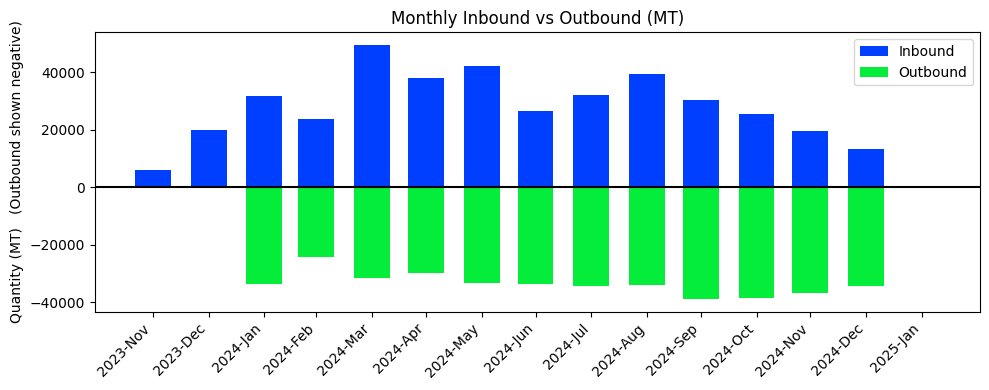

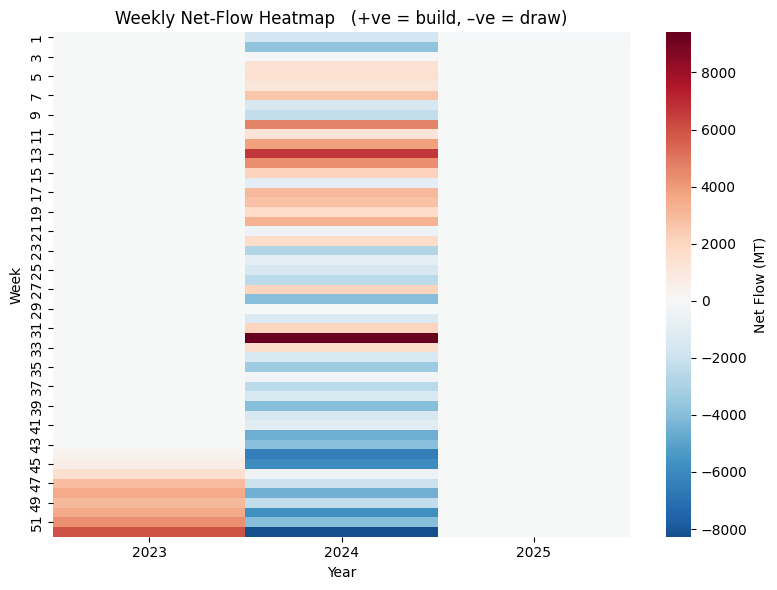

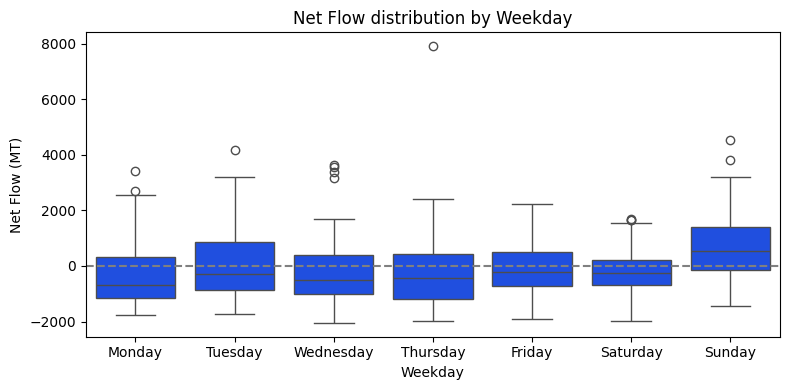

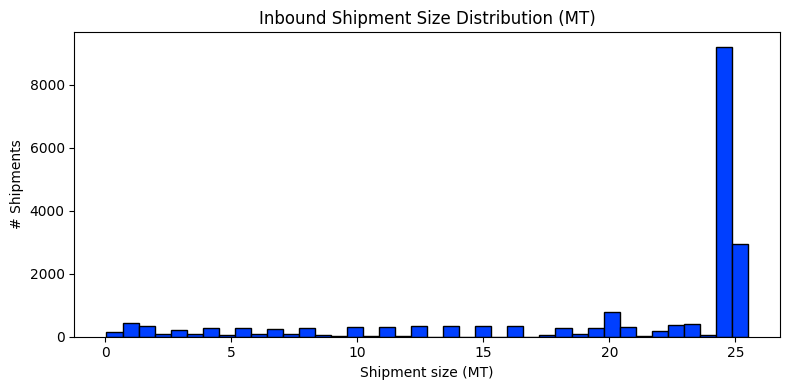

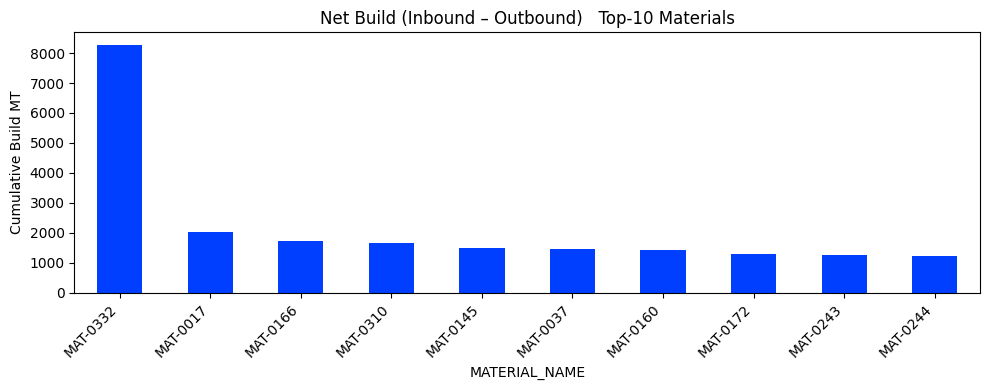

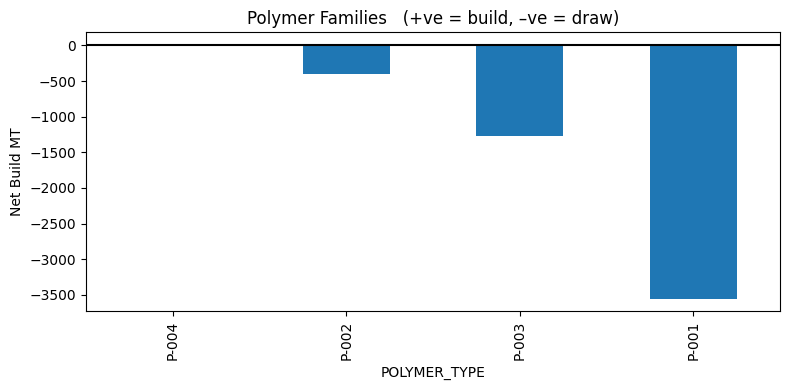

In [ ]:
# ---------------------------------------------------------------------------
# 7. EXTRA ROOT-CAUSE VISUALS
# ---------------------------------------------------------------------------
import seaborn as sns                                 # makes heatmaps easier

# ---------- E) Monthly inbound vs outbound bar --------------------------------
monthly = flows.resample('M').sum()

plt.figure(figsize=(10,4))
plt.bar(monthly.index - pd.offsets.MonthEnd(0), monthly['Inbound_MT'],
        width=20, label='Inbound')
plt.bar(monthly.index - pd.offsets.MonthEnd(0), -monthly['Outbound_MT'],
        width=20, label='Outbound')
plt.axhline(0, color='k')
plt.title('Monthly Inbound vs Outbound (MT)')
plt.ylabel('Quantity (MT)   (Outbound shown negative)')
plt.xticks(monthly.index, [d.strftime('%Y-%b') for d in monthly.index],
           rotation=45, ha='right')
plt.legend(); plt.tight_layout()

# ---------- F) Week-of-year heatmap of Net Flow ------------------------------
flows_hm = (flows
            .assign(Week=flows.index.isocalendar().week,
                    Year=flows.index.year)
            .pivot_table(index='Week', columns='Year',
                         values='Net_Flow_MT', aggfunc='sum')
            .fillna(0))

plt.figure(figsize=(8,6))
sns.heatmap(flows_hm, cmap='RdBu_r', center=0,
            cbar_kws={'label':'Net Flow (MT)'})
plt.title('Weekly Net-Flow Heatmap   (+ve = build, –ve = draw)')
plt.tight_layout()

# ---------- G) Weekday box-plots (spot systematic build) ---------------------
flows['Weekday'] = flows.index.day_name()

plt.figure(figsize=(8,4))
sns.boxplot(data=flows, x='Weekday', y='Net_Flow_MT',
            order=['Monday','Tuesday','Wednesday','Thursday',
                   'Friday','Saturday','Sunday'])
plt.axhline(0, ls='--', color='grey')
plt.title('Net Flow distribution by Weekday')
plt.ylabel('Net Flow (MT)')
plt.tight_layout()

# ---------- H) Shipment-size distribution (Inbound only) ---------------------
plt.figure(figsize=(8,4))
plt.hist(inbound['NET_QUANTITY_MT'], bins=40, edgecolor='k')
plt.title('Inbound Shipment Size Distribution (MT)')
plt.xlabel('Shipment size (MT)'); plt.ylabel('# Shipments')
plt.tight_layout()

# ---------- I) Top-10 materials driving cumulative BUILD ---------------------
build_by_mat = (inbound
                .groupby('MATERIAL_NAME')['NET_QUANTITY_MT']
                .sum()
                .sub(outbound
                     .groupby('MATERIAL_NAME')['NET_QUANTITY_MT']
                     .sum(), fill_value=0)
                .sort_values(ascending=False)
                .head(10))

plt.figure(figsize=(10,4))
build_by_mat.plot(kind='bar')
plt.title('Net Build (Inbound – Outbound)   Top-10 Materials')
plt.ylabel('Cumulative Build MT')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# ---------- J) Polymer-type contribution to build vs draw --------------------
build_by_poly = (inbound
                 .merge(material[['MATERIAL_NAME','POLYMER_TYPE']],
                        on='MATERIAL_NAME')
                 .groupby('POLYMER_TYPE')['NET_QUANTITY_MT']
                 .sum()
                 .sub(outbound
                      .merge(material[['MATERIAL_NAME','POLYMER_TYPE']],
                             on='MATERIAL_NAME')
                      .groupby('POLYMER_TYPE')['NET_QUANTITY_MT']
                      .sum(), fill_value=0)
                 .sort_values(ascending=False))

plt.figure(figsize=(8,4))
build_by_poly.plot(kind='bar', color=['tab:red' if v>0 else 'tab:blue'
                                      for v in build_by_poly])
plt.axhline(0, color='k'); plt.ylabel('Net Build MT')
plt.title('Polymer Families   (+ve = build, –ve = draw)')
plt.tight_layout()

plt.show()


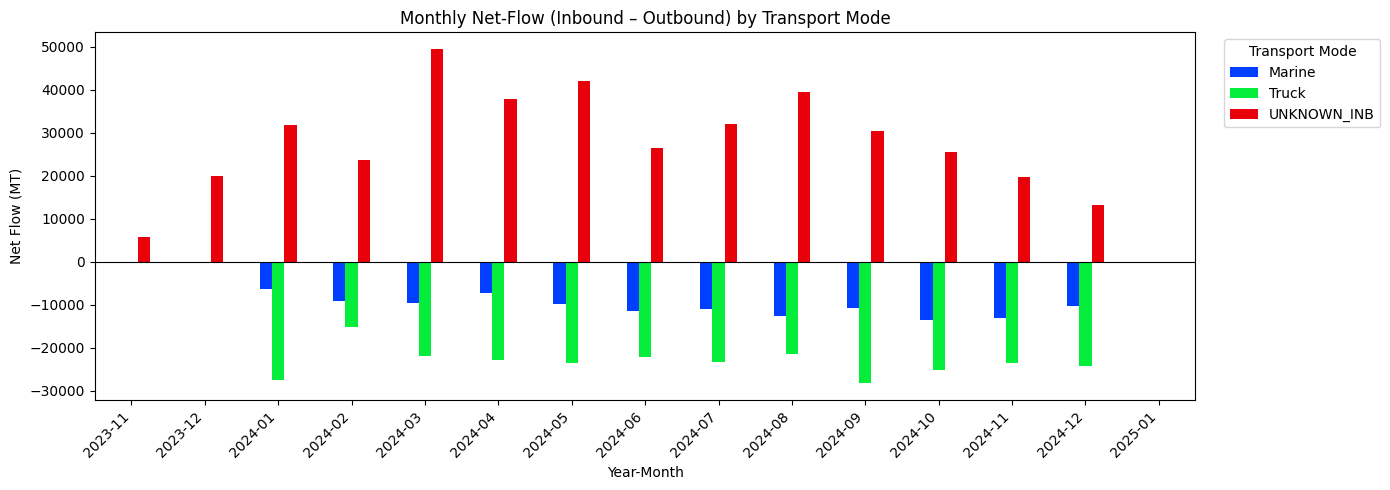

In [ ]:
# ---------------------------------------------------------------------------
# K)  Net-flow (Inbound – Outbound) by Transport Mode, Month & Year
# ---------------------------------------------------------------------------
MODE_COL = 'MODE_OF_TRANSPORT'          # transport field in Outbound.csv
PLACEHOLDER_MODE = 'UNKNOWN_INB'        # label to tag inbound rows

def month_summary(df, qty_col, date_col):
    """
    Summarise quantity by Year-Month and MODE_COL.
    If MODE_COL absent, create a placeholder column.
    """
    if MODE_COL not in df.columns:
        df = df.copy()
        df[MODE_COL] = PLACEHOLDER_MODE

    return (df
            .assign(YearMonth=pd.to_datetime(df[date_col]).dt.to_period('M'))
            .groupby(['YearMonth', MODE_COL])[qty_col]
            .sum()
            .rename('Quantity')
            .reset_index())

# ----- build monthly inbound / outbound -----
inb_m = month_summary(inbound,  'NET_QUANTITY_MT', 'INBOUND_DATE')
out_m = month_summary(outbound, 'NET_QUANTITY_MT', 'OUTBOUND_DATE')

# ----- merge & calculate net-flow -----
net_m = (inb_m.merge(out_m,
                     on=['YearMonth', MODE_COL],
                     how='outer',
                     suffixes=('_Inb', '_Out'))
               .fillna(0))
net_m['Net_Flow_MT'] = net_m['Quantity_Inb'] - net_m['Quantity_Out']
net_m['YearMonth']   = net_m['YearMonth'].astype(str)

# ----- pivot to matrix for plotting -----
pivot = (net_m
         .pivot_table(index='YearMonth',
                      columns=MODE_COL,
                      values='Net_Flow_MT',
                      aggfunc='sum')
         .fillna(0)
         .sort_index())

# ----- grouped-bar chart -----
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
pivot.plot(kind='bar', ax=plt.gca())
plt.axhline(0, color='k', linewidth=.8)
plt.title('Monthly Net-Flow (Inbound – Outbound) by Transport Mode')
plt.ylabel('Net Flow (MT)')
plt.xlabel('Year-Month')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Transport Mode', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipython-input-23-613128199.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(freq='M'))['STOCK_MT']


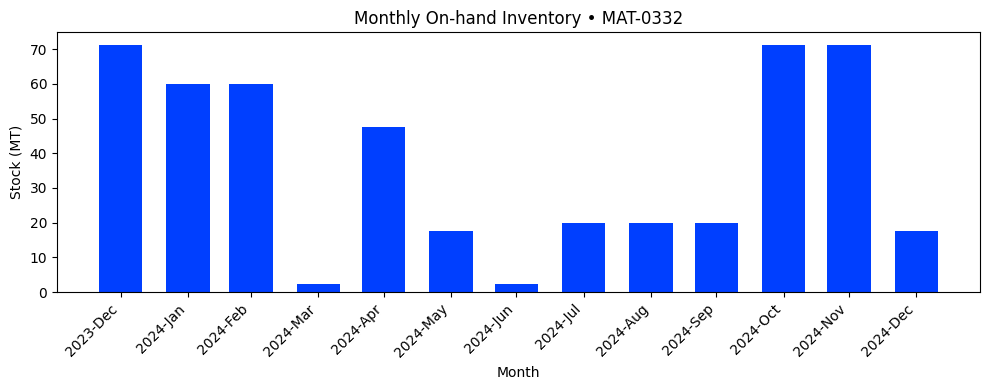

In [ ]:
# ---------------------------------------------------------------------------
#  Inventory on hand • single material • monthly view
# ---------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ 1. load
# Skip this block if 'inv' is already in memory
inv = pd.read_csv('Inventory.csv')
inv['BALANCE_AS_OF_DATE'] = pd.to_datetime(inv['BALANCE_AS_OF_DATE'])
inv['STOCK_MT'] = inv['UNRESRICTED_STOCK'] / 1_000.0   # kg → metric-tonnes

# ------------------------------------------------------------------ 2. pick your material
MAT_CODE = 'MAT-0332'          # ⬅️  change to whatever code you need
# If your file stores just "0332" in a column like MATERIAL_CODE, adjust the filter:
# MAT_CODE = '0332'
# mask = inv['MATERIAL_CODE'] == MAT_CODE
mask = inv['MATERIAL_NAME'] == MAT_CODE

inv_mat = inv.loc[mask].copy()

if inv_mat.empty:
    raise ValueError(f'No rows found for material {MAT_CODE}')

# ------------------------------------------------------------------ 3. roll up to month
# Option A: use the *last* snapshot of each month (most common for on-hand reporting)
monthly_mat = (inv_mat
               .set_index('BALANCE_AS_OF_DATE')
               .groupby(pd.Grouper(freq='M'))['STOCK_MT']
               .last()
               .dropna())                     # drop months without snapshots

# Option B (comment A & uncomment B): sum all snapshots in the month
# monthly_mat = inv_mat.set_index('BALANCE_AS_OF_DATE') \
#                      .resample('M')['STOCK_MT'].sum()

# ------------------------------------------------------------------ 4. plot
plt.figure(figsize=(10,4))
plt.bar(monthly_mat.index, monthly_mat, width=20)
plt.title(f'Monthly On-hand Inventory • {MAT_CODE}')
plt.xlabel('Month')
plt.ylabel('Stock (MT)')
plt.xticks(monthly_mat.index,
           monthly_mat.index.strftime('%Y-%b'),
           rotation=45, ha='right')
plt.tight_layout()
plt.show()


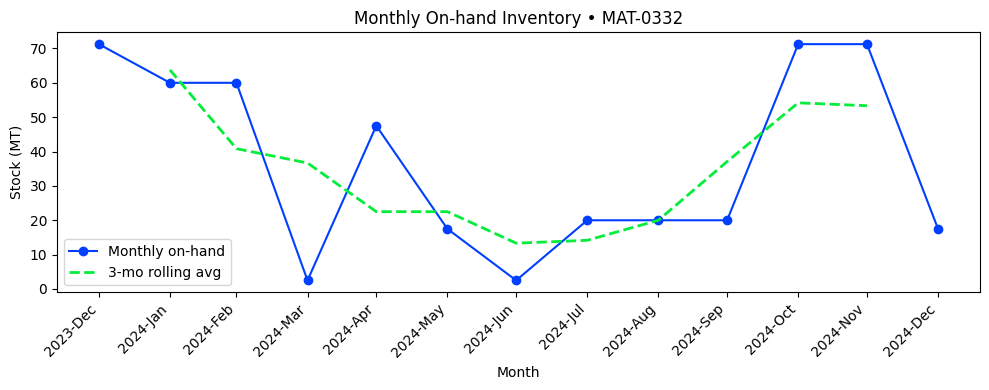

In [ ]:
# ------------------------------------------------------------------ 4. line graph
plt.figure(figsize=(10,4))

# main line
plt.plot(monthly_mat.index, monthly_mat,
         linestyle='-', marker='o', label='Monthly on-hand')

# optional: rolling 3-month average to smooth noise
plt.plot(monthly_mat.index,
         monthly_mat.rolling(3, center=True).mean(),
         linestyle='--', linewidth=2, label='3-mo rolling avg')

# optional: capacity line (uncomment & set value)
# CAPACITY_MT = 5_000
# plt.axhline(CAPACITY_MT, color='red', linestyle=':', label=f'Capacity {CAPACITY_MT:,} MT')

plt.title(f'Monthly On-hand Inventory • {MAT_CODE}')
plt.xlabel('Month')
plt.ylabel('Stock (MT)')
plt.xticks(monthly_mat.index,
           monthly_mat.index.strftime('%Y-%b'),
           rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


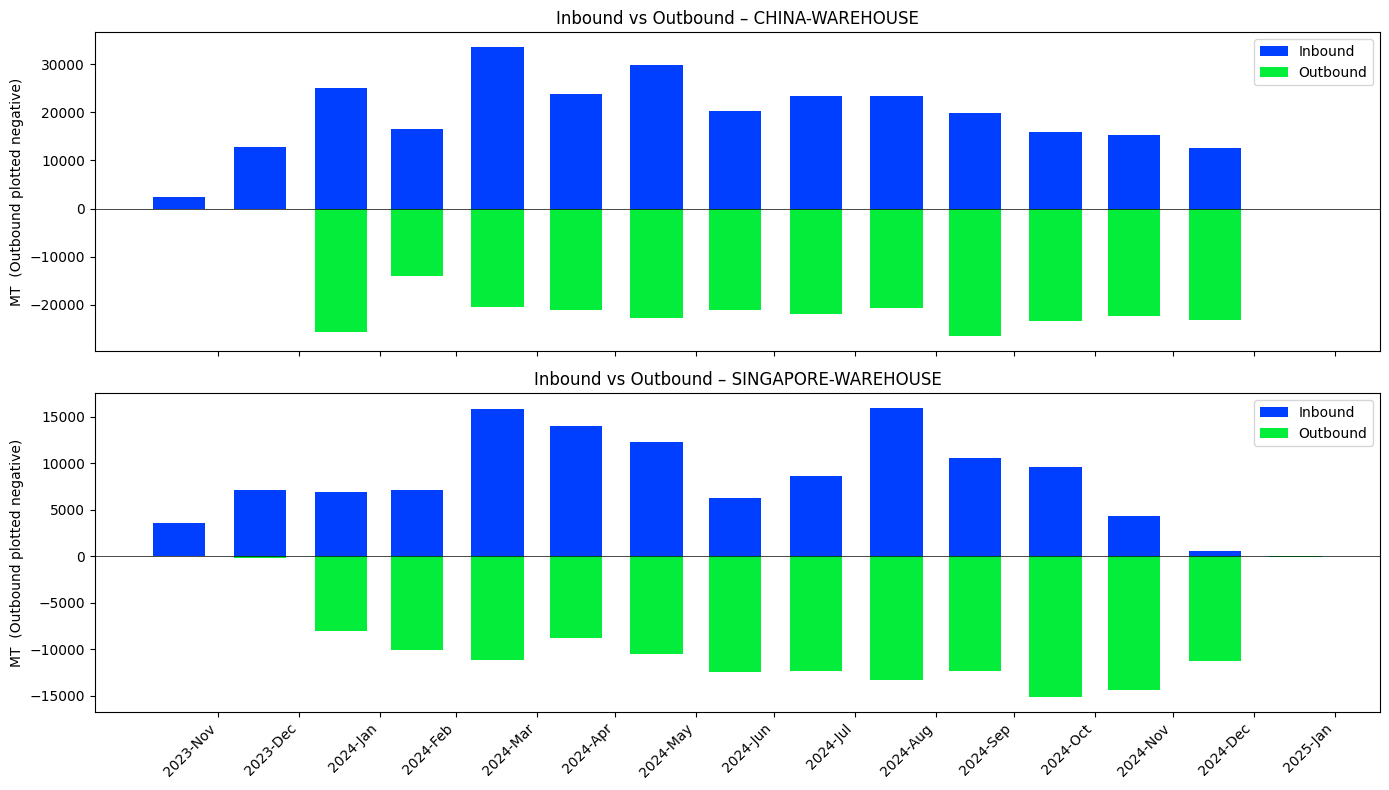

In [ ]:
# ---------------------------------------------------------------------------
#  Monthly Inbound vs Outbound by Warehouse / Plant
# ---------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# -------- 1. Load data (skip if you already have inbound/outbound in memory)
inbound  = pd.read_csv('Inbound.csv')
outbound = pd.read_csv('Outbound.csv')

# -------- 2. Prep – ensure dates & create Year-Month key
inbound['INBOUND_DATE']  = pd.to_datetime(inbound['INBOUND_DATE'])
outbound['OUTBOUND_DATE'] = pd.to_datetime(outbound['OUTBOUND_DATE'])

inbound['YearMonth']  = inbound['INBOUND_DATE'].dt.to_period('M')
outbound['YearMonth'] = outbound['OUTBOUND_DATE'].dt.to_period('M')

# -------- 3. Aggregate by Plant + YearMonth
inb_m  = (inbound
          .groupby(['PLANT_NAME', 'YearMonth'])['NET_QUANTITY_MT']
          .sum()
          .rename('Inbound_MT'))
out_m  = (outbound
          .groupby(['PLANT_NAME', 'YearMonth'])['NET_QUANTITY_MT']
          .sum()
          .rename('Outbound_MT'))

# Merge → single tidy frame
flows_m = (pd.concat([inb_m, out_m], axis=1)
             .fillna(0)
             .reset_index())

# List of plants to iterate over
plants = flows_m['PLANT_NAME'].unique()
plants.sort()

# -------- 4. Plot: one subplot per plant ------------------------------------
n_plants = len(plants)
fig, axes = plt.subplots(n_plants, 1, figsize=(14, 4*n_plants), sharex=True)

if n_plants == 1:       # when only one plant, axes isn't a list
    axes = [axes]

for ax, plant in zip(axes, plants):
    data = flows_m[flows_m['PLANT_NAME'] == plant].set_index('YearMonth')
    # Ensure YearMonth is sorted and continuous
    data = data.reindex(pd.period_range(data.index.min(),
                                        data.index.max(), freq='M'),
                        fill_value=0)
    # bar width = 20 (days) makes bars touch but not overlap
    ax.bar(data.index.to_timestamp(how='end') - pd.Timedelta(days=15),
           data['Inbound_MT'], width=20, label='Inbound')
    ax.bar(data.index.to_timestamp(how='end') - pd.Timedelta(days=15),
           -data['Outbound_MT'], width=20, label='Outbound')

    ax.axhline(0, color='k', linewidth=.5)
    ax.set_title(f'Inbound vs Outbound – {plant}')
    ax.set_ylabel('MT  (Outbound plotted negative)')
    ax.legend()

# Common X-labels
axes[-1].set_xticks(data.index.to_timestamp(how='end'))
axes[-1].set_xticklabels(data.index.strftime('%Y-%b'), rotation=45, ha='right')

plt.tight_layout()
plt.show()


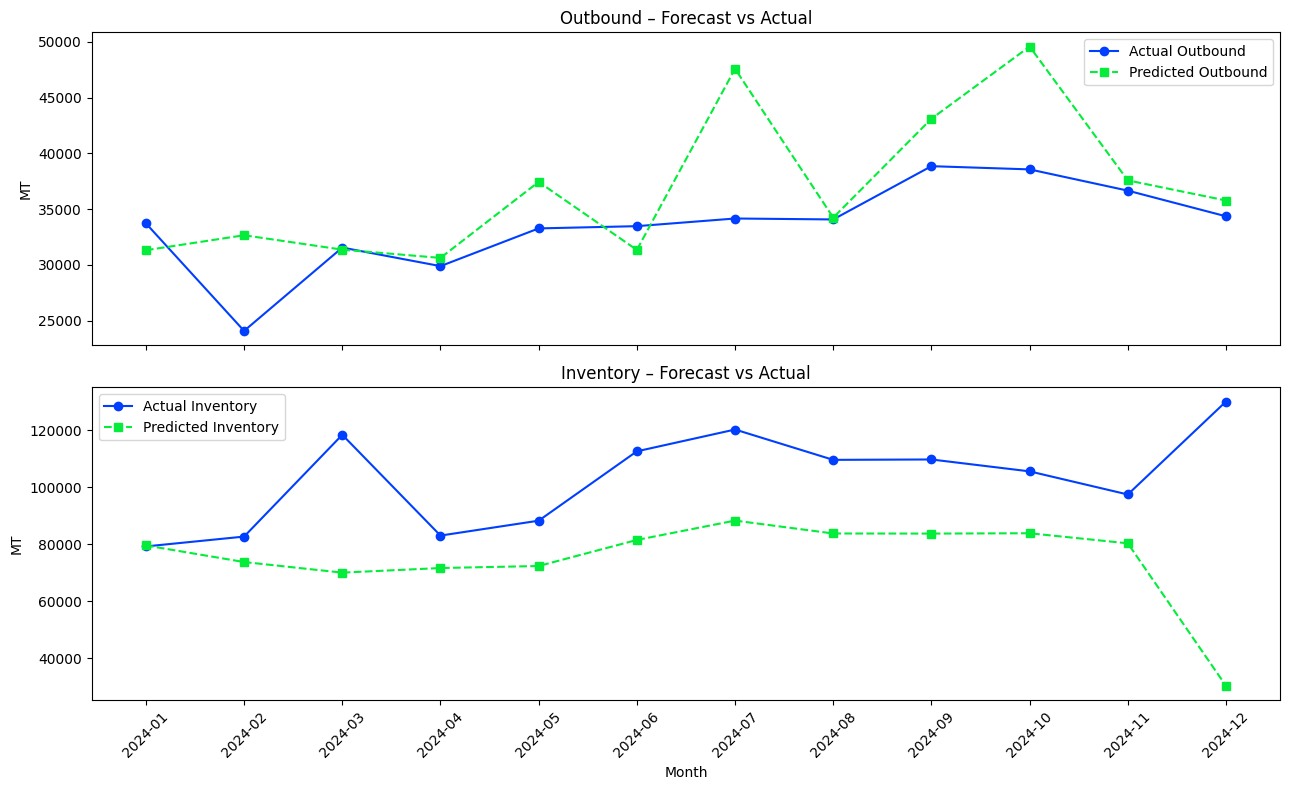

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, pathlib

# ── 🔧 FORECAST SHEET SETTINGS ──────────────────────────────────────────────
FORECAST_FILE = pathlib.Path('Forecast.xlsx')
SHEET_NAME    = 0          # tab index or name
ROW_BLOCKS    = [(2, 5, 6),  # (date_row, outbound_row, inventory_row) SGP
                 (14,17,18)] # CHN
START_COL     = 2          # first month column
# ── 🔧 INVENTORY UNIT  ('KG' or 'MT' or 'KT') ───────────────────────────────
INV_UNIT = 'KG'

# ── 1 ▸ BUILD FORECAST (tidy) ───────────────────────────────────────────────
wb = pd.read_excel(FORECAST_FILE, sheet_name=SHEET_NAME, header=None)
frames = []
for date_row, out_row, inv_row in ROW_BLOCKS:
    dates = pd.to_datetime(wb.iloc[date_row, START_COL:].dropna().values)
    ym    = pd.PeriodIndex(dates, freq='M')
    pred_out = pd.to_numeric(wb.iloc[out_row, START_COL:START_COL+len(ym)],  errors='coerce')*1_000
    pred_inv = pd.to_numeric(wb.iloc[inv_row, START_COL:START_COL+len(ym)],  errors='coerce')*1_000
    frames.append(pd.DataFrame({'YearMonth': ym,
                                'Pred_Out_MT': pred_out,
                                'Pred_Inv_MT': pred_inv}))
forecast = pd.concat(frames).groupby('YearMonth').sum().reset_index()

# ── 2 ▸ ACTUAL OUTBOUND ─────────────────────────────────────────────────────
outb = pd.read_csv('Outbound.csv', parse_dates=['OUTBOUND_DATE'])
outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')
actual_out = outb.groupby('YearMonth')['NET_QUANTITY_MT'].sum().rename('Actual_Out_MT')

# ── 3 ▸ ACTUAL INVENTORY  (max level each month) ────────────────────────────
inv = pd.read_csv('Inventory.csv', parse_dates=['BALANCE_AS_OF_DATE'])
inv['YearMonth'] = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')
if INV_UNIT.upper() == 'KG':
    inv['STOCK_MT'] = inv['UNRESRICTED_STOCK'] / 1_000
elif INV_UNIT.upper() == 'KT':
    inv['STOCK_MT'] = inv['UNRESRICTED_STOCK'] * 1_000
else:  # already MT
    inv['STOCK_MT'] = inv['UNRESRICTED_STOCK']
actual_inv = (inv.groupby(['YearMonth','BALANCE_AS_OF_DATE'])['STOCK_MT']
                 .sum()
                 .groupby('YearMonth')
                 .max()
                 .rename('Actual_Inv_MT'))

# ── 4 ▸ MERGE & PLOT ────────────────────────────────────────────────────────
cmp = (forecast.merge(actual_out, on='YearMonth', how='left')
              .merge(actual_inv, on='YearMonth', how='left')
              .sort_values('YearMonth'))

fig, ax = plt.subplots(2,1, figsize=(13,8), sharex=True)

# Outbound
ax[0].plot(cmp['YearMonth'].astype(str), cmp['Actual_Out_MT'], 'o-', label='Actual Outbound')
ax[0].plot(cmp['YearMonth'].astype(str), cmp['Pred_Out_MT'],  's--', label='Predicted Outbound')
ax[0].set_title('Outbound – Forecast vs Actual'); ax[0].set_ylabel('MT'); ax[0].legend()

# Inventory
ax[1].plot(cmp['YearMonth'].astype(str), cmp['Actual_Inv_MT'], 'o-', label='Actual Inventory')
ax[1].plot(cmp['YearMonth'].astype(str), cmp['Pred_Inv_MT'],  's--', label='Predicted Inventory')
ax[1].set_title('Inventory – Forecast vs Actual'); ax[1].set_ylabel('MT'); ax[1].legend()
ax[1].set_xlabel('Month'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


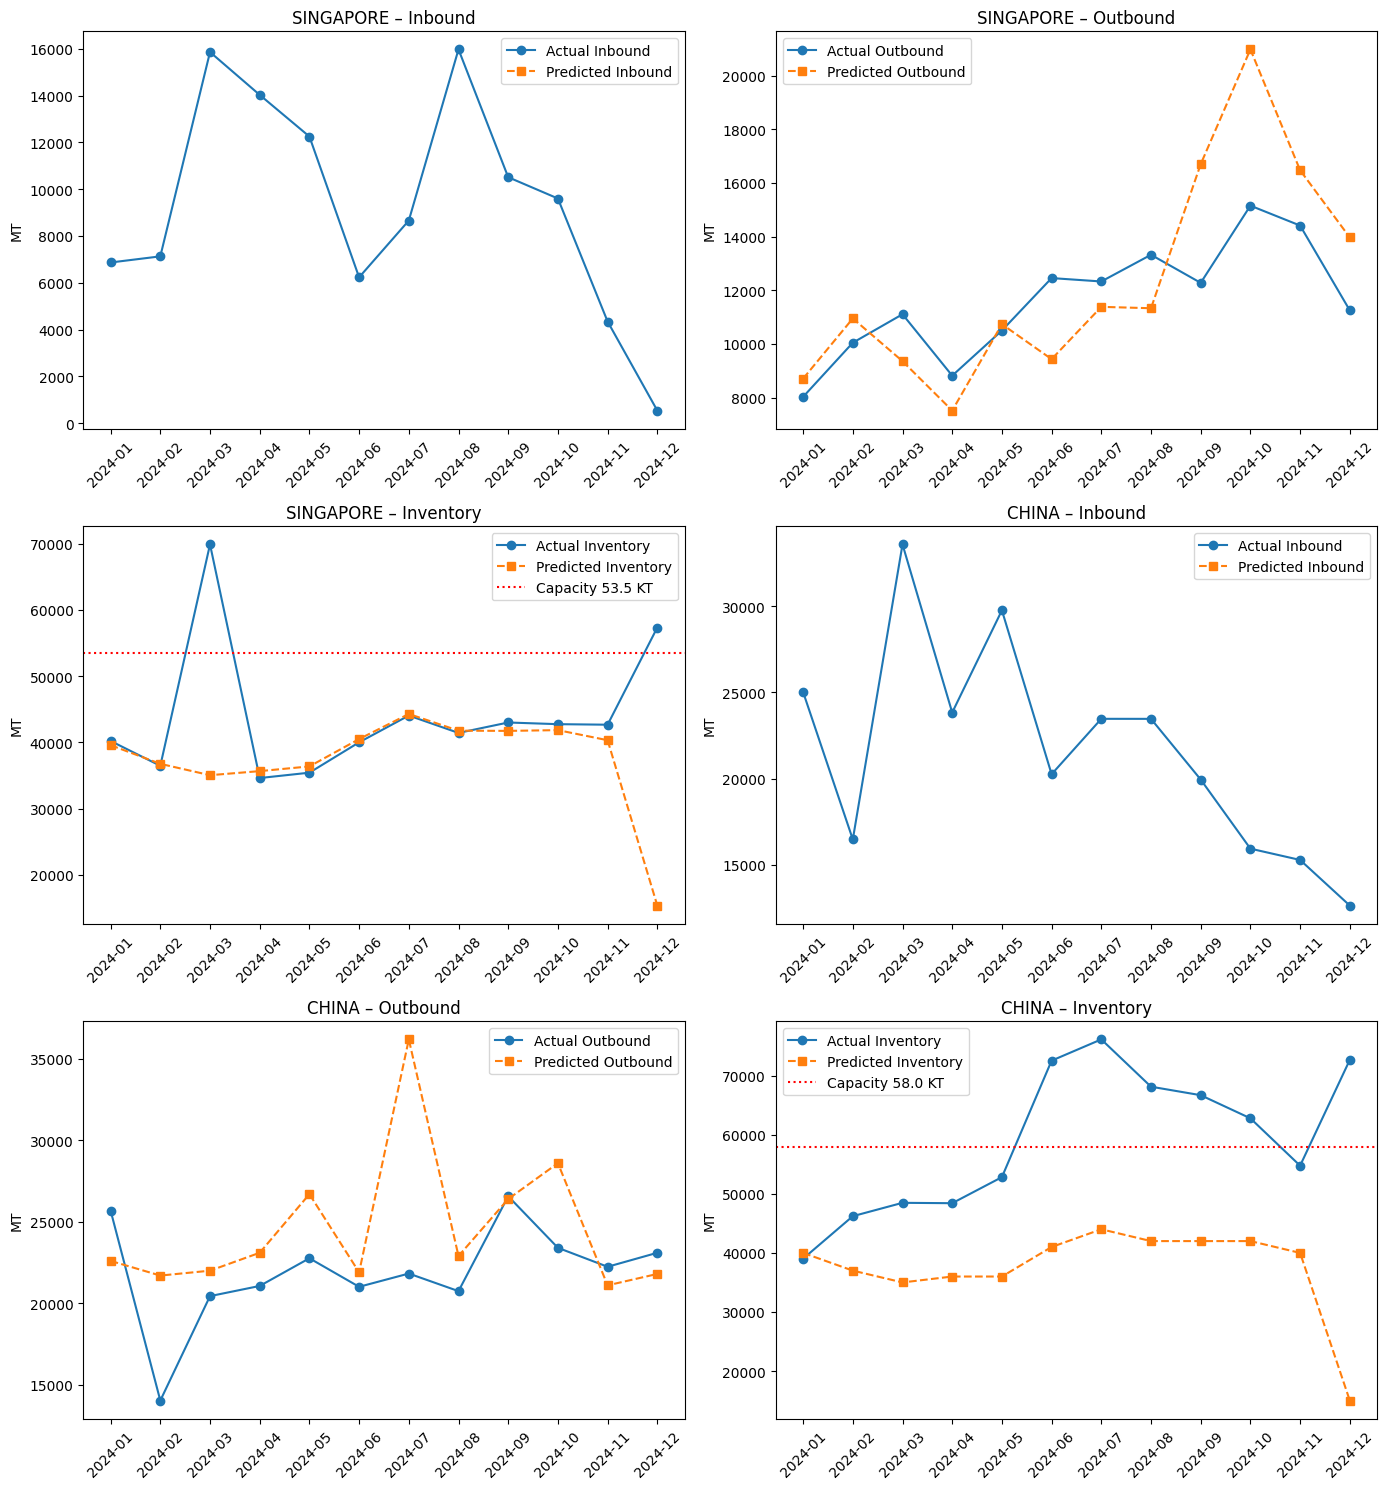

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, pathlib, re

# ── 🔧 1. Paths ──────────────────────────────────────────────────────────────
FORECAST_XLSX = pathlib.Path('/content/Forecast.xlsx')
OUTBOUND_CSV  = pathlib.Path('/content/Outbound.csv')
INVENT_CSV    = pathlib.Path('/content/Inventory.csv')
INBOUND_CSV   = pathlib.Path('/content/Inbound.csv') # Added Inbound CSV path


# ── 🔧 2. Forecast-sheet block positions: (date_row, outbound_row, inventory_row, capacity_row, inbound_row, warehouse) # Added inbound_row
BLOCKS = [(2, 5,  6,  1, 4, 'SINGAPORE'), # Added inbound_row for SINGAPORE
          (14,17, 18, 13, 16, 'CHINA')] # Added inbound_row for CHINA

START_COL = 2           # first column that holds months
INV_UNIT  = 'KG'        # 'KG', 'MT' or 'KT' in Inventory.csv

# ── 3. Load & reshape forecast ------------------------------------------------
wb = pd.read_excel(FORECAST_XLSX, header=None, sheet_name=0)
fc_dict, cap_dict = {}, {}

for d_row, o_row, i_row, c_row, in_row, wh in BLOCKS: # Added in_row
    dates = pd.to_datetime(wb.iloc[d_row, START_COL:].dropna().values)
    ym    = pd.PeriodIndex(dates, freq='M')

    fc_dict[wh] = pd.DataFrame({
        'YearMonth'   : ym,
        'Pred_Out_MT' : pd.to_numeric(wb.iloc[o_row, START_COL:START_COL+len(ym)], errors='coerce')*1_000,
        'Pred_Inv_MT' : pd.to_numeric(wb.iloc[i_row, START_COL:START_COL+len(ym)], errors='coerce')*1_000,
        'Pred_In_MT'  : pd.to_numeric(wb.iloc[in_row, START_COL:START_COL+len(ym)], errors='coerce')*1_000 # Added Pred_In_MT
    })

    cap_dict[wh] = float(wb.iloc[c_row, START_COL]) * 1_000   # KT → MT

# ── 4. Actual outbound per plant --------------------------------------------
outb = pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')

# crude mapping from PLANT_NAME to warehouse tag
def plant_tag(name):
    return 'SINGAPORE' if re.search('SINGAPORE', name, re.I) else 'CHINA'

outb['WH'] = outb['PLANT_NAME'].apply(plant_tag)
act_out = (outb.groupby(['WH','YearMonth'])['NET_QUANTITY_MT']
                .sum()
                .rename('Actual_Out_MT')
                .reset_index())

# ── 5. Actual inventory per plant (max level each month) --------------------
inv = pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
inv['YearMonth'] = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')

if INV_UNIT.upper() == 'KG':
    inv['STOCK_MT'] = inv['UNRESRICTED_STOCK'] / 1_000
elif INV_UNIT.upper() == 'KT':
    inv['STOCK_MT'] = inv['UNRESRICTED_STOCK'] * 1_000
else:
    inv['STOCK_MT'] = inv['UNRESRICTED_STOCK']

inv['WH'] = inv['PLANT_NAME'].apply(plant_tag)

act_inv = (inv.groupby(['WH','YearMonth','BALANCE_AS_OF_DATE'])['STOCK_MT']
             .sum()
             .groupby(['WH','YearMonth'])
             .max()
             .rename('Actual_Inv_MT')
             .reset_index())

# ── 5a. Actual inbound per plant -------------------------------------------- # Added actual inbound
inb = pd.read_csv(INBOUND_CSV, parse_dates=['INBOUND_DATE'])
inb['YearMonth'] = inb['INBOUND_DATE'].dt.to_period('M')
inb['WH'] = inb['PLANT_NAME'].apply(plant_tag)

act_in = (inb.groupby(['WH','YearMonth'])['NET_QUANTITY_MT']
               .sum()
               .rename('Actual_In_MT')
               .reset_index())


# ── 6. Plot for each warehouse ----------------------------------------------
plt.figure(figsize=(14,15)) # Increased figure size
pos = 1

for wh in ['SINGAPORE','CHINA']:
    fc   = fc_dict[wh]
    ao   = act_out[act_out['WH'] == wh]
    ai   = act_inv[act_inv['WH'] == wh]
    ain  = act_in[act_in['WH'] == wh] # Added actual inbound for merging

    cmp  = (fc.merge(ao, on='YearMonth', how='left')
               .merge(ai, on='YearMonth', how='left')
               .merge(ain, on='YearMonth', how='left') # Merged with actual inbound
               .sort_values('YearMonth'))

    # ── Inbound # Added Inbound plot
    ax = plt.subplot(3,2,pos); pos += 1 # Adjusted subplot grid
    ax.plot(cmp['YearMonth'].astype(str), cmp['Actual_In_MT'],
            'o-', label='Actual Inbound')
    ax.plot(cmp['YearMonth'].astype(str), cmp['Pred_In_MT'],
            's--', label='Predicted Inbound')
    ax.set_title(f'{wh} – Inbound'); ax.set_ylabel('MT'); ax.legend()
    ax.tick_params(axis='x', rotation=45)


    # ── Outbound
    ax = plt.subplot(3,2,pos); pos += 1 # Adjusted subplot grid
    ax.plot(cmp['YearMonth'].astype(str), cmp['Actual_Out_MT'],
            'o-', label='Actual Outbound')
    ax.plot(cmp['YearMonth'].astype(str), cmp['Pred_Out_MT'],
            's--', label='Predicted Outbound')
    ax.set_title(f'{wh} – Outbound'); ax.set_ylabel('MT'); ax.legend()
    ax.tick_params(axis='x', rotation=45)

    # ── Inventory
    ax = plt.subplot(3,2,pos); pos += 1 # Adjusted subplot grid
    ax.plot(cmp['YearMonth'].astype(str), cmp['Actual_Inv_MT'],
            'o-', label='Actual Inventory')
    ax.plot(cmp['YearMonth'].astype(str), cmp['Pred_Inv_MT'],
            's--', label='Predicted Inventory')
    ax.axhline(cap_dict[wh], ls=':', color='red',
               label=f'Capacity {cap_dict[wh]/1000:.1f} KT')
    ax.set_title(f'{wh} – Inventory'); ax.set_ylabel('MT'); ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

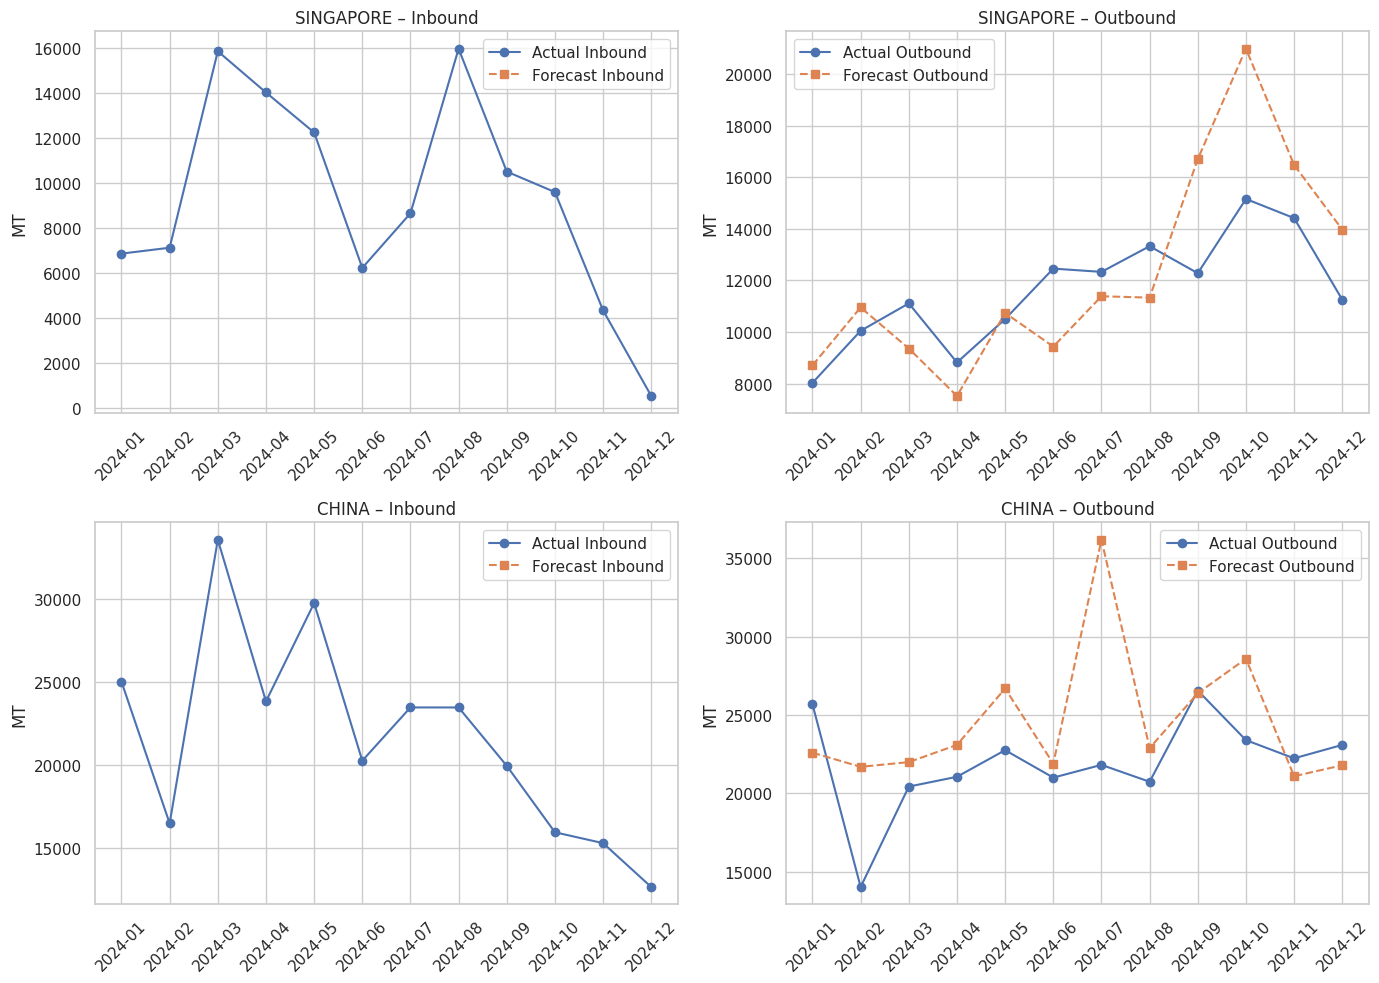

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, pathlib, re

# ── 🔧 1. Paths ──────────────────────────────────────────────────────────────
FORECAST_XLSX = pathlib.Path('/content/Forecast.xlsx')
OUTBOUND_CSV  = pathlib.Path('/content/Outbound.csv')
INBOUND_CSV   = pathlib.Path('/content/Inbound.csv')

# ── 🔧 2. Forecast-sheet block positions: (date_row, outbound_row, inventory_row, capacity_row, inbound_row, warehouse)
BLOCKS = [(2, 5,  6,  1, 4, 'SINGAPORE'),
          (14,17, 18, 13, 16, 'CHINA')]

START_COL = 2  # First column with dates

# ── 3. Load forecast ----------------------------------------------------------
wb = pd.read_excel(FORECAST_XLSX, header=None, sheet_name=0)
fc_dict = {}

for d_row, o_row, i_row, c_row, in_row, wh in BLOCKS:
    dates = pd.to_datetime(wb.iloc[d_row, START_COL:].dropna().values)
    ym = pd.PeriodIndex(dates, freq='M')

    fc_dict[wh] = pd.DataFrame({
        'YearMonth': ym,
        'Pred_Out_MT': pd.to_numeric(wb.iloc[o_row, START_COL:START_COL+len(ym)], errors='coerce') * 1_000,
        'Pred_In_MT' : pd.to_numeric(wb.iloc[in_row, START_COL:START_COL+len(ym)], errors='coerce') * 1_000
    })

# ── 4. Load actuals -----------------------------------------------------------
def plant_tag(name):
    return 'SINGAPORE' if re.search('SINGAPORE', name, re.I) else 'CHINA'

# Inbound
inb = pd.read_csv(INBOUND_CSV, parse_dates=['INBOUND_DATE'])
inb['YearMonth'] = inb['INBOUND_DATE'].dt.to_period('M')
inb['WH'] = inb['PLANT_NAME'].apply(plant_tag)
act_in = (inb.groupby(['WH', 'YearMonth'])['NET_QUANTITY_MT']
             .sum()
             .rename('Actual_In_MT')
             .reset_index())

# Outbound
outb = pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')
outb['WH'] = outb['PLANT_NAME'].apply(plant_tag)
act_out = (outb.groupby(['WH', 'YearMonth'])['NET_QUANTITY_MT']
              .sum()
              .rename('Actual_Out_MT')
              .reset_index())

# ── 5. Plotting ---------------------------------------------------------------
plt.figure(figsize=(14, 10))
pos = 1

for wh in ['SINGAPORE', 'CHINA']:
    fc = fc_dict[wh]
    ain = act_in[act_in['WH'] == wh]
    aout = act_out[act_out['WH'] == wh]

    cmp = (fc.merge(ain, on='YearMonth', how='left')
              .merge(aout, on='YearMonth', how='left')
              .sort_values('YearMonth'))

    # Inbound
    ax = plt.subplot(2, 2, pos); pos += 1
    ax.plot(cmp['YearMonth'].astype(str), cmp['Actual_In_MT'], 'o-', label='Actual Inbound')
    ax.plot(cmp['YearMonth'].astype(str), cmp['Pred_In_MT'], 's--', label='Forecast Inbound')
    ax.set_title(f'{wh} – Inbound')
    ax.set_ylabel('MT'); ax.legend()
    ax.tick_params(axis='x', rotation=45)

    # Outbound
    ax = plt.subplot(2, 2, pos); pos += 1
    ax.plot(cmp['YearMonth'].astype(str), cmp['Actual_Out_MT'], 'o-', label='Actual Outbound')
    ax.plot(cmp['YearMonth'].astype(str), cmp['Pred_Out_MT'], 's--', label='Forecast Outbound')
    ax.set_title(f'{wh} – Outbound')
    ax.set_ylabel('MT'); ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


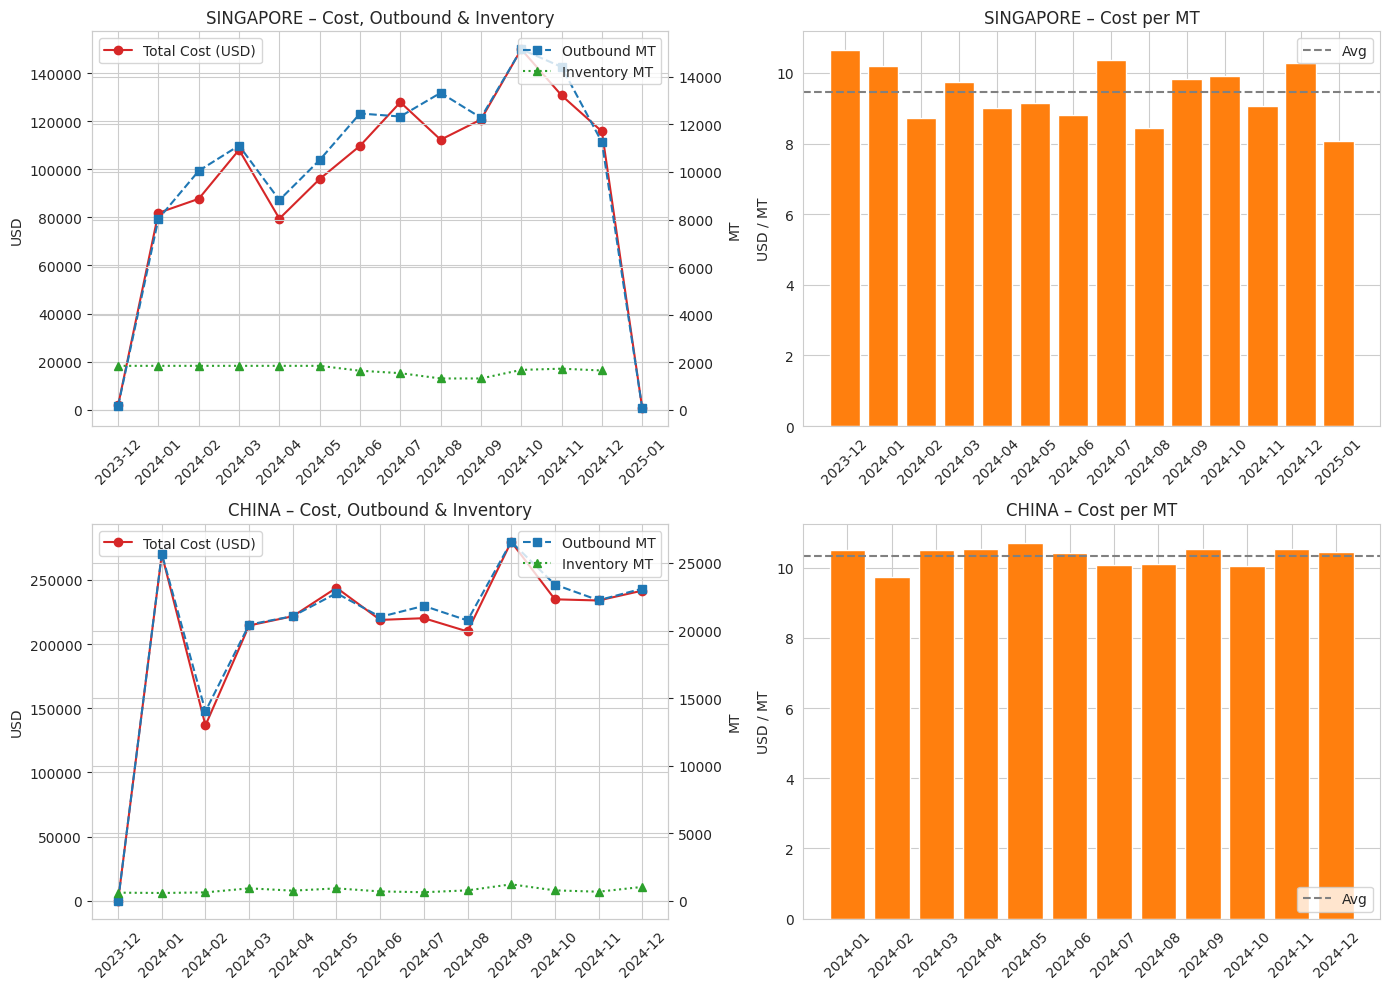

In [ ]:
# =============================================================================
#  Monthly cost overlay & efficiency — Singapore vs China
# =============================================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import calendar, pathlib, re, sys

# ── 1. PATHS ────────────────────────────────────────────────────────────────
BASE        = pathlib.Path('/content')      # << change if your files live elsewhere
OUTBOUND_CSV = BASE/'Outbound.csv'
INVENT_CSV   = BASE/'Inventory.csv'
OPCOST_CSV   = BASE/'OperationCost.csv'

# ── 2. INVENTORY UNIT IN Inventory.csv  ('KG', 'MT', 'KT') ─────────────────
INV_UNIT = 'KG'

# ── 3. OP-COST KEYS  – must match Operation column strings 100 % ───────────
COST_KEYS = {
    'Transfer' : 'Transfer cost per container',   # one rate for every container
    'Storage'  : 'Inventory Storage per MT per day'
}

# ── 4. READ OPERATION COSTS ─────────────────────────────────────────────────
opc = pd.read_csv(OPCOST_CSV)

def get_cost(exact_key):
    row = opc[opc['Operation'].str.contains(exact_key, case=False, na=False)]
    if row.empty:
        print(f"❌  '{exact_key}' not found in OperationCost.csv.\n"
              f"Available names:\n{opc['Operation'].unique()}")
        sys.exit(1)
    return float(row['Cost'].iloc[0])

COST_TRANSFER = get_cost(COST_KEYS['Transfer'])    # USD / container
COST_STORAGE  = get_cost(COST_KEYS['Storage'])     # SGD / MT / day
SGD2USD       = 1 / 1.35                           # FX assumption

# ── 5. READ OUTBOUND & INVENTORY ─────────────────────────────────────────────
outb = pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
inv  = pd.read_csv(INVENT_CSV,   parse_dates=['BALANCE_AS_OF_DATE'])

def wh_tag(name):                                   # tweak if more plants
    return 'SINGAPORE' if re.search('SINGAPORE', name, re.I) else 'CHINA'

outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')
outb['WH']        = outb['PLANT_NAME'].apply(wh_tag)

inv['YearMonth']  = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')
inv['WH']         = inv['PLANT_NAME'].apply(wh_tag)
inv_factor        = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]
inv['STOCK_MT']   = inv['UNRESRICTED_STOCK'] * inv_factor

# ── 6. BUILD MONTHLY METRICS ────────────────────────────────────────────────
records = []
for wh in ['SINGAPORE', 'CHINA']:
    ob_wh = outb[outb['WH'] == wh]
    mt_by_month = ob_wh.groupby('YearMonth')['NET_QUANTITY_MT'].sum()
    conts       = ob_wh.groupby('YearMonth').size()   # 1 row = 1 container

    iv_wh = inv[inv['WH'] == wh]
    max_stock = (iv_wh.groupby(['YearMonth','BALANCE_AS_OF_DATE'])['STOCK_MT']
                       .sum().groupby('YearMonth').max())

    for ym in sorted(mt_by_month.index.union(max_stock.index)):
        mt        = mt_by_month.get(ym, 0.0)
        c_trans   = conts.get(ym, 0) * COST_TRANSFER
        days      = calendar.monthrange(ym.year, ym.month)[1]
        c_store   = max_stock.get(ym, 0.0) * COST_STORAGE * days * SGD2USD
        total     = c_trans
        cost_per  = total / mt if mt else np.nan
        records.append({'WH': wh, 'YearMonth': ym,
                        'Outbound_MT': mt,
                        'Total_Cost': total,
                        'Cost_per_MT': cost_per})

df = pd.DataFrame(records)

# ── Add max monthly inventory per WH to df for plotting ──
max_inventory = (inv.groupby(['WH', 'YearMonth'])['STOCK_MT'].max().reset_index()
                 .rename(columns={'STOCK_MT': 'Max_Inventory_MT'}))
df = df.merge(max_inventory, on=['WH', 'YearMonth'], how='left')

# ── 7. PLOT 4 COMPARISON CHARTS ─────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14,10)); axes = axes.ravel(); i = 0
for wh in ['SINGAPORE', 'CHINA']:
    sub = df[df['WH'] == wh].sort_values('YearMonth')
    x   = sub['YearMonth'].astype(str)

    # (a) Total Cost vs Outbound + Inventory
    ax  = axes[i]; i += 1
    ax.plot(x, sub['Total_Cost'], 'tab:red', marker='o', label='Total Cost (USD)')
    ax.set_ylabel('USD')
    ax2 = ax.twinx()
    ax2.plot(x, sub['Outbound_MT'], 'tab:blue', marker='s', linestyle='--',
             label='Outbound MT')
    ax2.plot(x, sub['Max_Inventory_MT'], 'tab:green', marker='^', linestyle=':',
             label='Inventory MT')
    ax.set_title(f'{wh} – Cost, Outbound & Inventory'); ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right'); ax2.set_ylabel('MT')

    # (b) Cost per MT
    ax  = axes[i]; i += 1
    ax.bar(x, sub['Cost_per_MT'], color='tab:orange')
    ax.axhline(sub['Cost_per_MT'].mean(), ls='--', color='gray', label='Avg')
    ax.set_title(f'{wh} – Cost per MT'); ax.set_ylabel('USD / MT')
    ax.tick_params(axis='x', rotation=45); ax.legend()
plt.tight_layout(); plt.show()



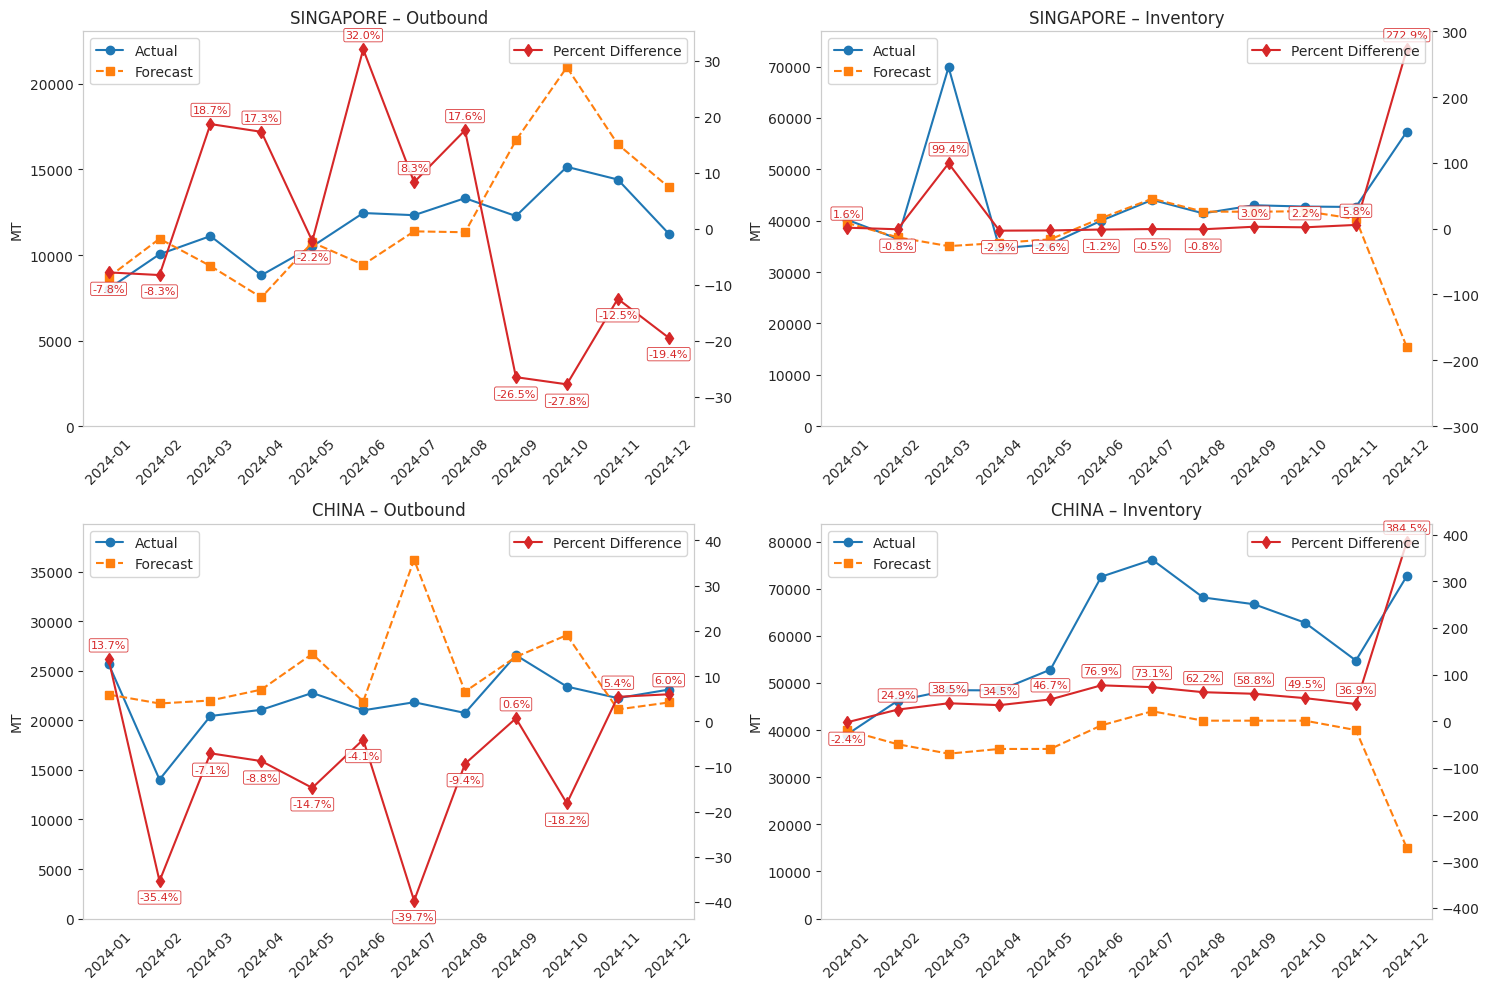

In [ ]:
# =============================================================================
#  Forecast-accuracy dashboard  (4 panels, twin-axis)
# =============================================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pathlib, re, calendar

# ── 🔧 1. FILE LOCATIONS ────────────────────────────────────────────────────
BASE           = pathlib.Path('/content')        # change if needed
FORECAST_XLSX  = BASE/'Forecast.xlsx'
OUTBOUND_CSV   = BASE/'Outbound.csv'
INVENT_CSV     = BASE/'Inventory.csv'

# ── 🔧 2. INVENTORY UNITS IN Inventory.csv  ('KG','MT','KT') ────────────────
INV_UNIT = 'KG'

# ── 🔧 3. ROW BLOCKS IN FORECAST SHEET (date_row, out_row, inv_row, warehouse)
BLOCKS = [(2, 5,  6,  'SINGAPORE'),
          (14,17, 18, 'CHINA')]
START_COL = 2           # first month column

# ────────────────────────────────────────────────────────────────────────────
# 1 ▸  Load & tidy forecast  (wide sheet → long dataframe)
# ────────────────────────────────────────────────────────────────────────────
wb = pd.read_excel(FORECAST_XLSX, header=None, sheet_name=0)
fc_frames = []

for d_row, o_row, i_row, wh in BLOCKS:
    dates = pd.to_datetime(wb.iloc[d_row, START_COL:].dropna().values)
    ym    = pd.PeriodIndex(dates, freq='M')
    fc_frames.append(
        pd.DataFrame({
            'WH'           : wh,
            'YearMonth'    : ym,
            'FC_Outbound'  : pd.to_numeric(wb.iloc[o_row, START_COL:START_COL+len(ym)], errors='coerce')*1_000,
            'FC_Inventory' : pd.to_numeric(wb.iloc[i_row, START_COL:START_COL+len(ym)], errors='coerce')*1_000
        })
    )
forecast = pd.concat(fc_frames)

# ────────────────────────────────────────────────────────────────────────────
# 2 ▸  Actual outbound per plant
# ────────────────────────────────────────────────────────────────────────────
outb = pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')
outb['WH']        = outb['PLANT_NAME'].str.contains('SINGAPORE', case=False).map({True:'SINGAPORE', False:'CHINA'})
act_out = (outb.groupby(['WH','YearMonth'])['NET_QUANTITY_MT']
                 .sum()
                 .rename('AC_Outbound')
                 .reset_index())

# ────────────────────────────────────────────────────────────────────────────
# 3 ▸  Actual inventory (month-end maximum) per plant
# ────────────────────────────────────────────────────────────────────────────
inv = pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
inv['YearMonth'] = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')
inv['WH']        = inv['PLANT_NAME'].str.contains('SINGAPORE', case=False).map({True:'SINGAPORE', False:'CHINA'})
conv = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]
inv['STOCK_MT'] = inv['UNRESRICTED_STOCK'] * conv

act_inv = (inv.groupby(['WH','YearMonth','BALANCE_AS_OF_DATE'])['STOCK_MT']
              .sum()
              .groupby(['WH','YearMonth'])
              .max()
              .rename('AC_Inventory')
              .reset_index())

# ────────────────────────────────────────────────────────────────────────────
# 4 ▸  Merge forecast & actual  + compute accuracy %
# ────────────────────────────────────────────────────────────────────────────
df = (forecast
      .merge(act_out, on=['WH','YearMonth'], how='left')
      .merge(act_inv, on=['WH','YearMonth'], how='left'))

for col_ac, col_fc in [('AC_Outbound','FC_Outbound'), ('AC_Inventory','FC_Inventory')]:
    df[f'ACC_{col_ac.split("_")[1]}'] = ((df[col_ac] / df[col_fc])-1) * 100

# ────────────────────────────────────────────────────────────────────────────
# ────────────────────────────────────────────────────────────────────────────
# ────────────────────────────────────────────────────────────────────────────
# 5 ▸ Plot (4 panels, twin axis)  – no grid, % labels highlighted
# ---------------------------------------------------------------------------
import numpy as np
fig, axes = plt.subplots(2, 2, figsize=(15,10)); axes = axes.ravel(); p = 0
plot_plan = [
    ('SINGAPORE', 'Outbound'),
    ('SINGAPORE', 'Inventory'),
    ('CHINA',     'Outbound'),
    ('CHINA',     'Inventory')
]

for wh, metric in plot_plan:
    sub    = df[df['WH'] == wh].sort_values('YearMonth').reset_index(drop=True)
    pos    = np.arange(len(sub))
    labels = sub['YearMonth'].astype(str)

    ac  = sub[f'AC_{metric}']
    fc  = sub[f'FC_{metric}']
    acc = sub[f'ACC_{metric}']

    # primary axis  (Actual & Forecast)
    ax = axes[p]; p += 1
    ax.plot(pos, ac, 'o-', label='Actual')
    ax.plot(pos, fc, 's--', label='Forecast')
    ax.set_xlim(-0.5, len(pos)-0.5)
    ax.set_ylim(0, max(ac.max(), fc.max()) * 1.1)
    ax.set_ylabel('MT')
    ax.set_title(f'{wh} – {metric}')
    ax.set_xticks(pos); ax.set_xticklabels(labels, rotation=45)
    ax.legend(loc='upper left')
    ax.grid(False)

    # secondary axis  (Percent difference)
    ax2 = ax.twinx()
    ax2.plot(pos, acc, 'd-', color='tab:red', label='Percent Difference')
    acc_lim = max(abs(acc.min()), abs(acc.max()), 25)
    ax2.set_ylim(-acc_lim*1.1, acc_lim*1.1)
    ax2.set_ylabel('')                     # remove y-axis label
    ax2.grid(False)

    # show legend for the red line
    ax2.legend(loc='upper right')

    # add highlighted data labels
    for x, y in zip(pos, acc):
        offset = 8 if y >= 0 else -14
        ax2.annotate(f'{y:,.1f}%',
                     (x, y),
                     xytext=(0, offset),
                     textcoords='offset points',
                     ha='center',
                     fontsize=8,
                     color='tab:red',
                     bbox=dict(boxstyle='round,pad=0.15',
                               facecolor='white',
                               edgecolor='tab:red',
                               linewidth=0.6,
                               alpha=0.9))

plt.tight_layout(); plt.show()





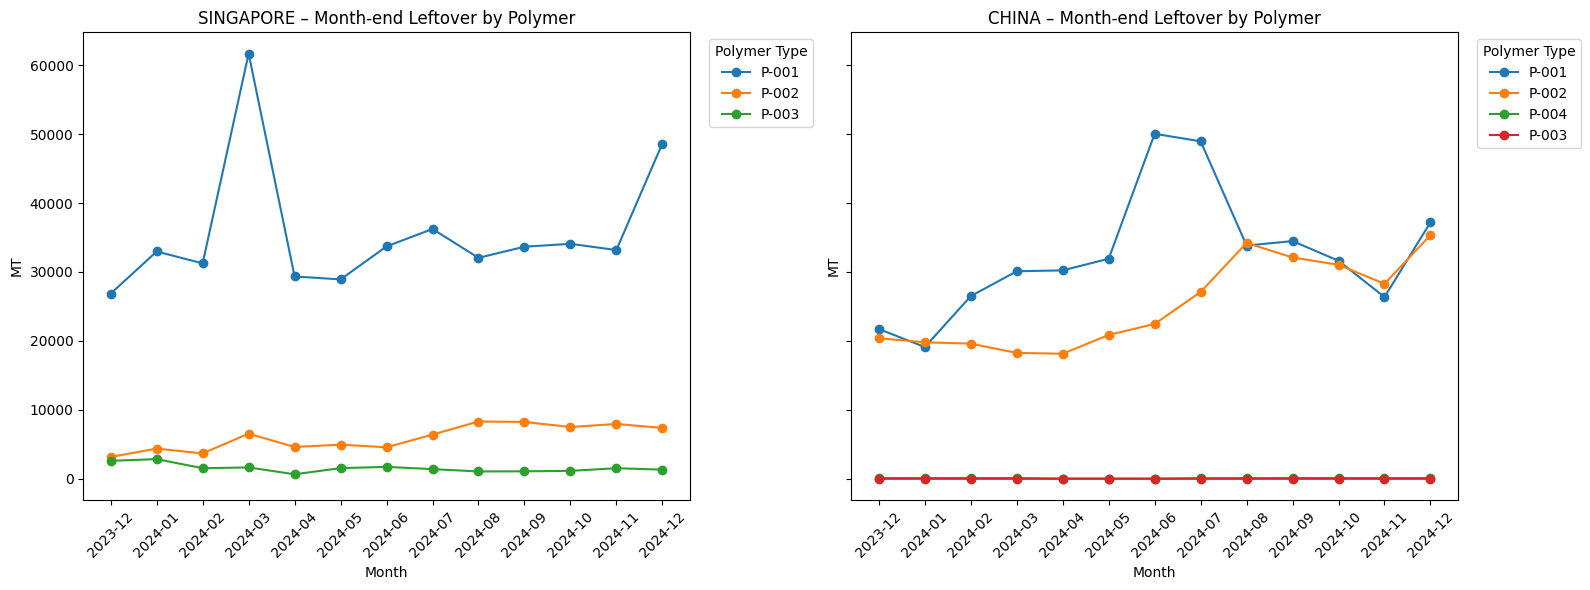

In [ ]:
# =============================================================================
#  Month-end leftover inventory by polymer family  (SG vs CN)
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, pathlib, re

# ── 🔧 1. FILE LOCATIONS ────────────────────────────────────────────────────
BASE          = pathlib.Path('/content')          # change if needed
INVENT_CSV    = BASE/'Inventory.csv'
MATERIAL_CSV  = BASE/'MaterialMaster.csv'         # must contain POLYMER_TYPE

# ── 🔧 2. INVENTORY UNITS ('KG','MT','KT') ───────────────────────────────────
INV_UNIT = 'KG'

# ── 3. READ & MERGE  ────────────────────────────────────────────────────────
inv  = pd.read_csv(INVENT_CSV,   parse_dates=['BALANCE_AS_OF_DATE'])
mat  = pd.read_csv(MATERIAL_CSV)[['MATERIAL_NAME','POLYMER_TYPE']]

inv['YearMonth'] = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')
inv['WH']        = inv['PLANT_NAME'].str.contains('SINGAPORE', case=False)\
                     .map({True:'SINGAPORE', False:'CHINA'})

conv = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]
inv['STOCK_MT'] = inv['UNRESRICTED_STOCK'] * conv

# add polymer label
inv = inv.merge(mat, on='MATERIAL_NAME', how='left')

# ── 4. BUILD MONTH-END MAX STOCK BY POLYMER ────────────────────────────────
dfs = []
for wh in ['SINGAPORE', 'CHINA']:
    iv = inv[inv['WH']==wh]
    month_max = (iv.groupby(['YearMonth','BALANCE_AS_OF_DATE','POLYMER_TYPE'])['STOCK_MT']
                   .sum()
                   .groupby(['YearMonth','POLYMER_TYPE'])
                   .max()
                   .unstack(fill_value=0))               # rows = months, cols = polymer
    dfs.append((wh, month_max))

# ── 5. PLOT — twin panels, one per warehouse ───────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

for ax, (wh, pivot) in zip(axes, dfs):
    pivot = pivot.sort_index()                      # ensure chronological
    # choose 5 biggest polymers to avoid clutter; drop others
    top_cols = pivot.sum().sort_values(ascending=False).head(5).index
    data = pivot[top_cols]

    # line plot for each polymer
    for col in data.columns:
        ax.plot(data.index.astype(str), data[col],
                marker='o', label=col)
    ax.set_title(f'{wh} – Month-end Leftover by Polymer')
    ax.set_xlabel('Month'); ax.set_ylabel('MT')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Polymer Type', bbox_to_anchor=(1.02,1), loc='upper left')

plt.tight_layout(); plt.show()


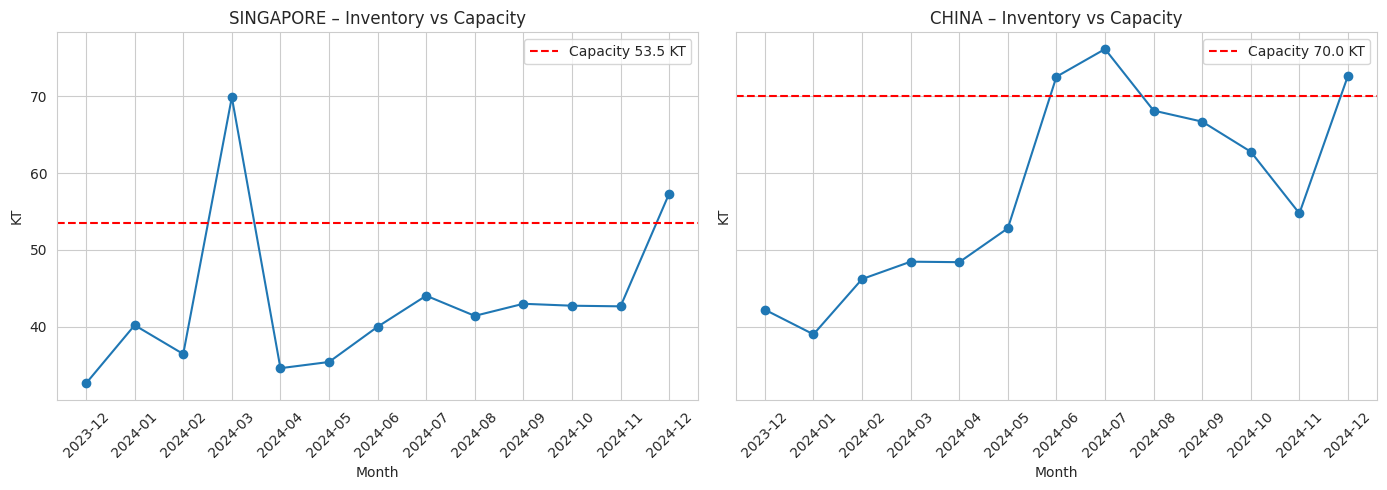

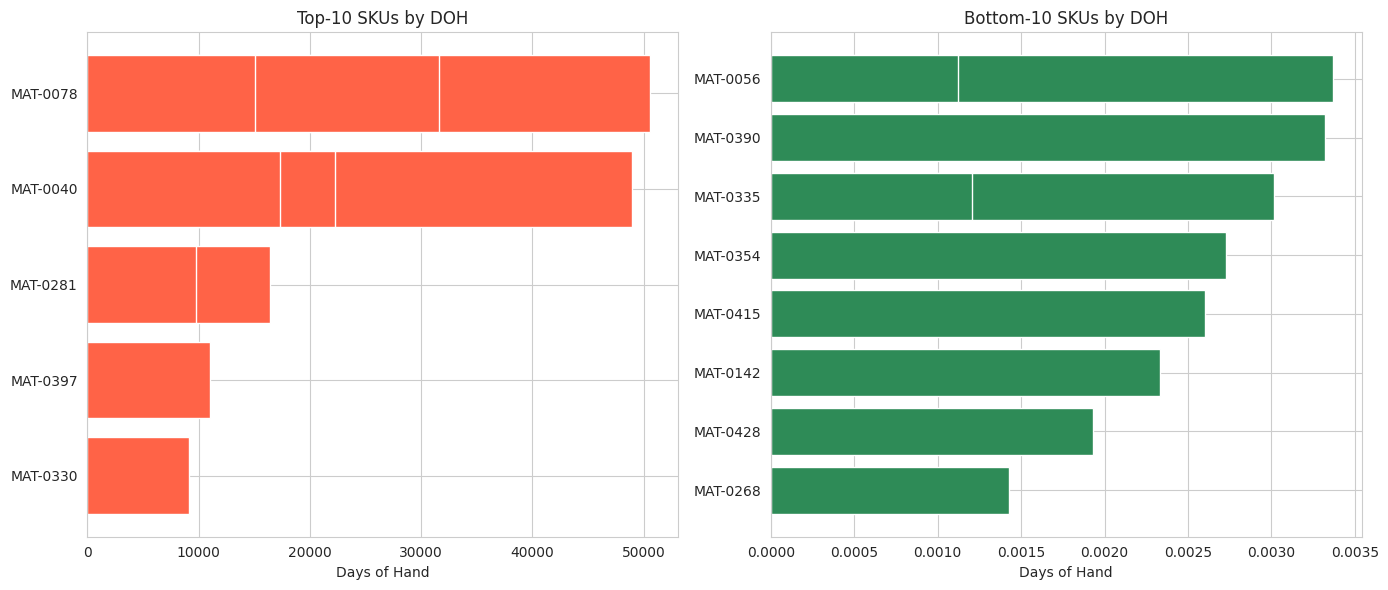

In [ ]:
# =============================================================================
#  Poor-Replenishment Dashboard
#  - Line: Inventory vs Capacity  (SG & CN)
#  - Bars: DOH top-10 / bottom-10 SKUs (combined warehouses or filter per WH)
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, pathlib, re, warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.autolayout'] = True

# ── 🔧 CONFIG ────────────────────────────────────────────────────────────────
BASE             = pathlib.Path('/content')          # folder with your CSVs
INVENT_CSV       = BASE/'Inventory.csv'
OUTBOUND_CSV     = BASE/'Outbound.csv'
INV_UNIT         = 'KG'                              # KG | MT | KT
CAPACITY_KT      = {'SINGAPORE': 53.5, 'CHINA': 70}  # in kilo-tonnes
MONTH_DAYS       = 30                                # divisor for daily usage
# ---------------------------------------------------------------------------

# helper to tag warehouse
wh_tag = lambda name: 'SINGAPORE' if re.search('SINGAPORE', name, re.I) else 'CHINA'

# 1 ▸ LOAD & NORMALISE INVENTORY --------------------------------------------
inv = pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
conv = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]
inv['STOCK_MT']   = inv['UNRESRICTED_STOCK'] * conv
inv['YearMonth']  = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')
inv['WH']         = inv['PLANT_NAME'].apply(wh_tag)

# latest snapshot for DOH calculation
latest_date = inv['BALANCE_AS_OF_DATE'].max()
inv_latest  = inv[inv['BALANCE_AS_OF_DATE'] == latest_date]

# 2 ▸ LOAD & BUILD AVERAGE DAILY USAGE --------------------------------------
outb = pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')
# monthly usage per SKU → average per day
monthly_use = (outb.groupby(['MATERIAL_NAME','YearMonth'])['NET_QUANTITY_MT']
                    .sum().div(MONTH_DAYS)
                    .groupby('MATERIAL_NAME')
                    .mean()                       # long-run average daily usage
                    .rename('AVG_DAILY_USAGE_MT')
                    .reset_index())

# 3 ▸ DOH per SKU -----------------------------------------------------------
doh = (inv_latest[['MATERIAL_NAME','UNRESRICTED_STOCK']]
          .merge(monthly_use, on='MATERIAL_NAME', how='left'))
doh['AVG_DAILY_USAGE_MT'].replace(0, pd.NA, inplace=True)  # avoid div by zero
doh['DOH'] = doh['UNRESRICTED_STOCK'] * conv / doh['AVG_DAILY_USAGE_MT']
doh = doh.dropna(subset=['DOH']).sort_values('DOH', ascending=False)

# 4 ▸ INVENTORY vs CAPACITY  (line charts) ----------------------------------
tot_month = (inv.groupby(['WH','YearMonth'])['STOCK_MT']
                .sum().reset_index())

fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for ax, wh in zip(axes, ['SINGAPORE','CHINA']):
    sub = tot_month[tot_month['WH']==wh]
    ax.plot(sub['YearMonth'].astype(str), sub['STOCK_MT']/1000, marker='o')  # MT → KT
    cap = CAPACITY_KT[wh]
    ax.axhline(cap, ls='--', color='red', label=f'Capacity {cap:.1f} KT')
    ax.set_title(f'{wh} – Inventory vs Capacity'); ax.set_xlabel('Month'); ax.set_ylabel('KT')
    ax.tick_params(axis='x', rotation=45); ax.legend()

plt.show()

# 5 ▸ DOH BAR CHARTS  (Top-10 & Bottom-10) ----------------------------------
top10    = doh.head(10)
bottom10 = doh[doh['DOH']>0].tail(10)        # exclude zeros & negatives

fig, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].barh(top10['MATERIAL_NAME'], top10['DOH'], color='tomato')
axes[0].set_title('Top-10 SKUs by DOH'); axes[0].set_xlabel('Days of Hand')
axes[0].invert_yaxis()

axes[1].barh(bottom10['MATERIAL_NAME'], bottom10['DOH'], color='seagreen')
axes[1].set_title('Bottom-10 SKUs by DOH'); axes[1].set_xlabel('Days of Hand')
axes[1].invert_yaxis()

plt.tight_layout(); plt.show()

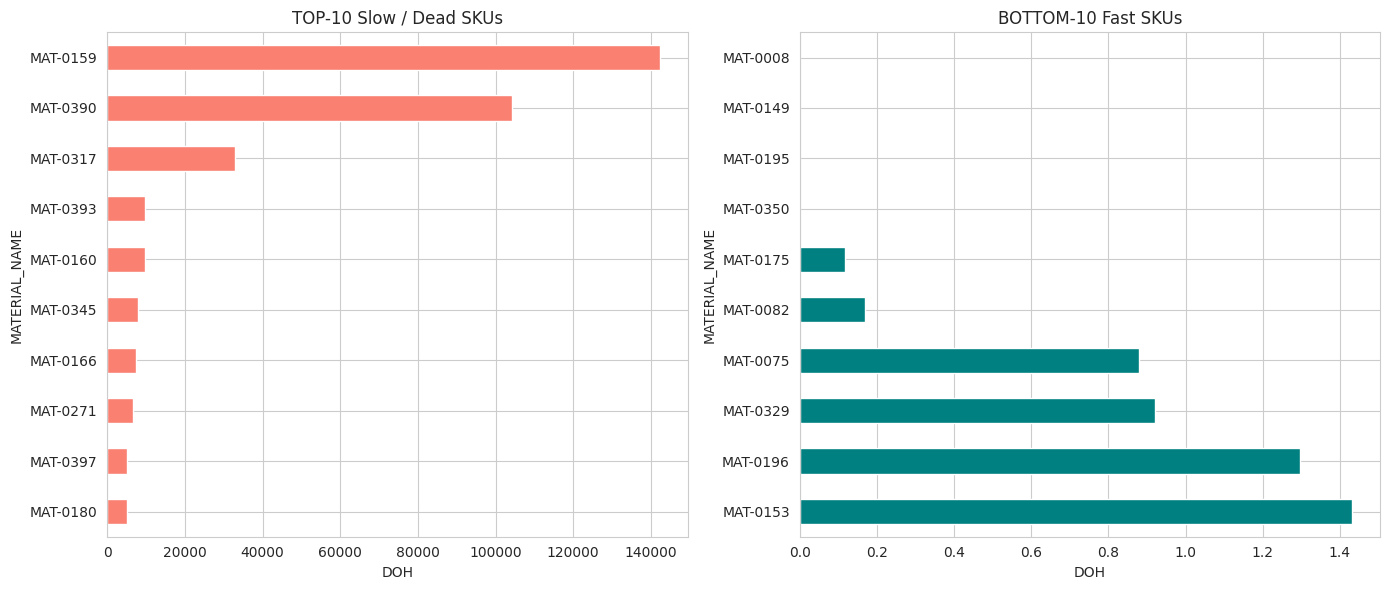

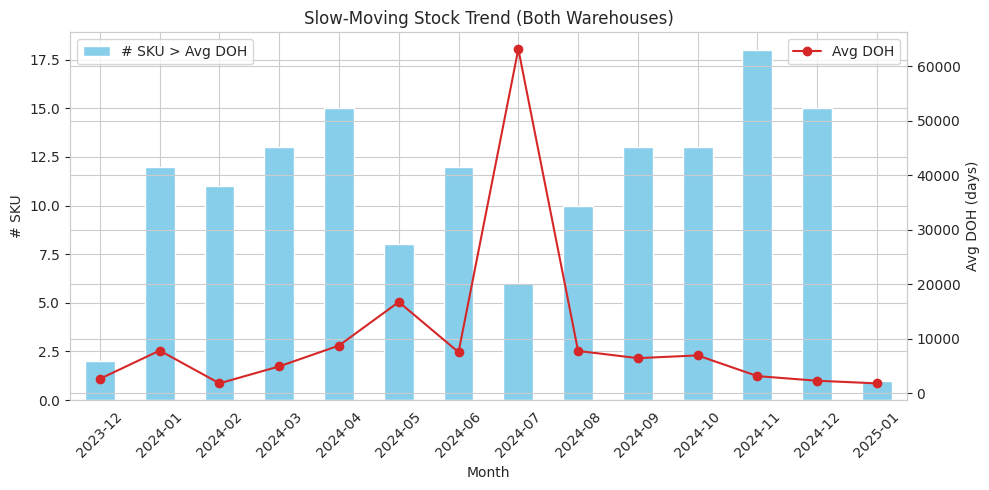

In [ ]:
# =============================================================================
#  DOH (Days-on-Hand) analytics & visuals
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, pathlib, numpy as np, seaborn as sns
sns.set_style("whitegrid")

# ── 🔧 1. FILE LOCATIONS ─────────────────────────────────────────────────────
BASE           = pathlib.Path('/content')
INVENT_CSV     = BASE/'Inventory.csv'
OUTBOUND_CSV   = BASE/'Outbound.csv'

# ── 🔧 2. INVENTORY UNIT  ('KG', 'MT', 'KT') ────────────────────────────────
INV_UNIT       = 'KG'

# ── 3. LOAD DATA ────────────────────────────────────────────────────────────
inv  = pd.read_csv(INVENT_CSV,  parse_dates=['BALANCE_AS_OF_DATE'])
outb = pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])

# ── 4. DAILY-USAGE  (avg per SKU per month) ─────────────────────────────────
outb['Month'] = outb['OUTBOUND_DATE'].dt.to_period('M')
daily_usage = (outb.groupby(['MATERIAL_NAME','Month'])['NET_QUANTITY_MT']
                  .sum()
                  .rename('Monthly_Usage_MT') / 30)           # ≈ daily usage
daily_usage = daily_usage.reset_index()

# ── 5. CURRENT STOCK (latest snapshot) ──────────────────────────────────────
latest = inv['BALANCE_AS_OF_DATE'].max()
stock  = (inv[inv['BALANCE_AS_OF_DATE'] == latest]
          .groupby('MATERIAL_NAME')['UNRESRICTED_STOCK']
          .sum()
          .rename('Stock_raw'))

conv   = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]
stock  = (stock * conv).rename('Stock_MT').reset_index()

# ── 6. MERGE  &  DOH  (for most-recent month with usage) ───────────────────
usage_last3   = (daily_usage[daily_usage['Month'] >=
                             (daily_usage['Month'].max()-2)])  # last 3 months
avg_daily     = (usage_last3.groupby('MATERIAL_NAME')['Monthly_Usage_MT']
                              .mean()
                              .rename('AVG_Daily_Usage'))
df = (stock.merge(avg_daily, on='MATERIAL_NAME', how='left')
           .dropna())                         # drop SKUs with no usage history
df['DOH'] = df['Stock_MT'] / df['AVG_Daily_Usage']

# ── 7. FIGURE 1  –  Top & bottom 10 DOH  ====================================
top10    = df.nlargest(10, 'DOH').set_index('MATERIAL_NAME')
bottom10 = df.nsmallest(10,'DOH').set_index('MATERIAL_NAME')

fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=False)
top10['DOH'].plot(kind='barh', ax=axes[0], color='salmon')
axes[0].set_title('TOP-10 Slow / Dead SKUs'); axes[0].set_xlabel('DOH')
axes[0].invert_yaxis()

bottom10['DOH'].plot(kind='barh', ax=axes[1], color='teal')
axes[1].set_title('BOTTOM-10 Fast SKUs'); axes[1].set_xlabel('DOH')
axes[1].invert_yaxis()

plt.tight_layout()

# ── 8. FIGURE 2  –  Monthly SKU count > Avg DOH  +  Avg DOH line  ===========
# compute DOH per SKU per month
merged = (daily_usage.merge(stock, on='MATERIAL_NAME', how='left')
                    .dropna())
merged['DOH'] = merged['Stock_MT'] / merged['Monthly_Usage_MT']

month_stats = (merged.groupby('Month')
                      .apply(lambda g: pd.Series({
                          'Avg_DOH'   : g['DOH'].mean(),
                          'SKU_Above' : (g['DOH'] > g['DOH'].mean()).sum()
                      }))
              .sort_index())

fig, ax1 = plt.subplots(figsize=(10,5))
month_stats['SKU_Above'].plot(kind='bar', ax=ax1, color='skyblue',
                              label='# SKU > Avg DOH')
ax1.set_ylabel('# SKU'); ax1.set_xlabel('Month')

ax2 = ax1.twinx()
ax2.plot(month_stats.index.astype(str), month_stats['Avg_DOH'],
         color='tab:red', marker='o', label='Avg DOH')
ax2.set_ylabel('Avg DOH (days)')

ax1.set_title('Slow-Moving Stock Trend (Both Warehouses)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.tight_layout(); plt.show()


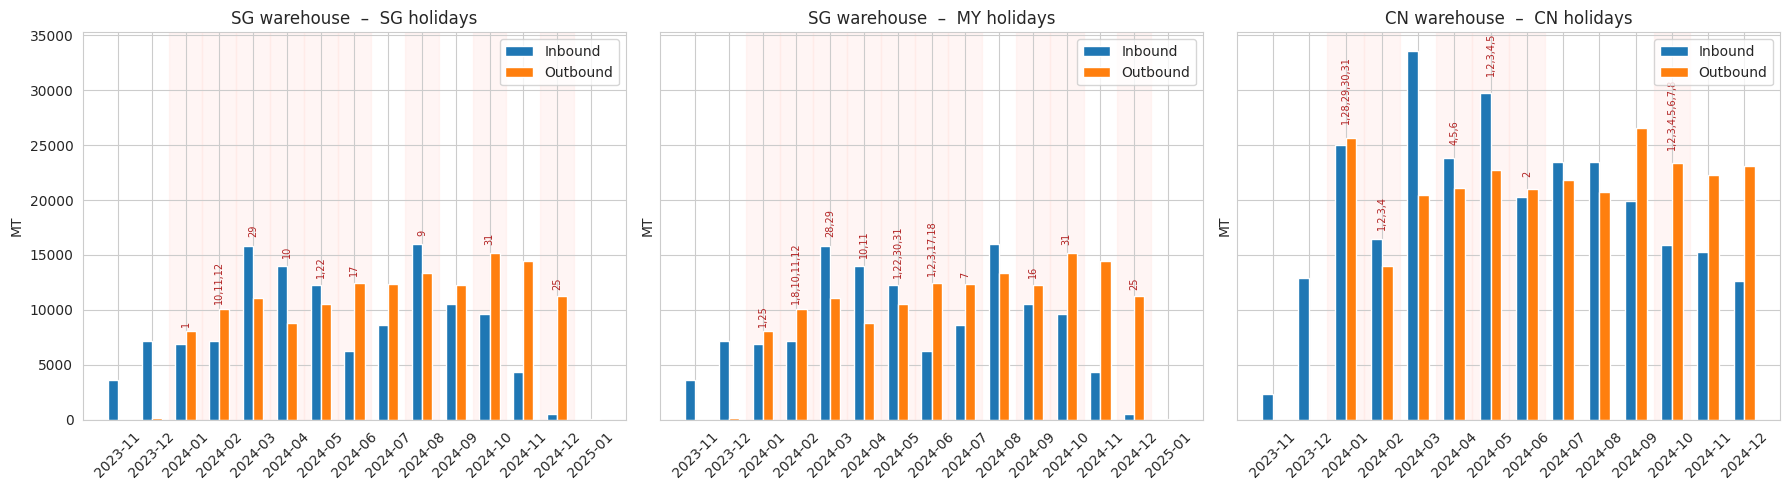

In [ ]:
# =============================================================================
#  Flow vs EVERY listed holiday  ·  3 annotated bar charts
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np, pathlib, re, seaborn as sns
sns.set_style('whitegrid')

# ── 🔧 1. CSV paths -----------------------------------------------------------
BASE         = pathlib.Path('/content')
INBOUND_CSV  = BASE/'Inbound.csv'
OUTBOUND_CSV = BASE/'Outbound.csv'

# ── 🔧 2.1  SINGAPORE holidays  (exact dates)  --------------------------------
SG_HOLI = pd.to_datetime([
    '2024-01-01','2024-02-10','2024-02-11','2024-02-12','2024-03-29',
    '2024-04-10','2024-05-01','2024-05-22','2024-06-17','2024-08-09',
    '2024-10-31','2024-12-25'
])

# ── 🔧 2.2  MALAYSIA holidays  ------------------------------------------------
MY_HOLI = pd.to_datetime([
    '2024-01-01','2024-01-25','2024-02-01','2024-02-08',
    '2024-02-10','2024-02-11','2024-02-12',
    '2024-03-28','2024-03-29',
    '2024-04-10','2024-04-11',
    '2024-05-01','2024-05-22','2024-05-30','2024-05-31',
    '2024-06-01','2024-06-02','2024-06-03',
    '2024-06-17','2024-06-18',
    '2024-07-07',
    '2024-09-16',
    '2024-10-31','2024-12-25'
])

# ── 🔧 2.3  PRC holidays  -----------------------------------------------------
CN_HOLI = pd.to_datetime([
    '2024-01-01',
    *pd.date_range('2024-01-28','2024-02-04'),
    *pd.date_range('2024-04-04','2024-04-06'),
    *pd.date_range('2024-05-01','2024-05-05'),
    '2024-06-02',
    *pd.date_range('2024-10-01','2024-10-08')
])

# helper: map plant names to warehouse tag
def wh_tag(p): return 'SINGAPORE' if 'SINGAPORE' in p.upper() else 'CHINA'

# ── 3. Load inbound / outbound & roll-up monthly -----------------------------
inb  = pd.read_csv(INBOUND_CSV,  parse_dates=['INBOUND_DATE'])
out = pd.read_csv(OUTBOUND_CSV,  parse_dates=['OUTBOUND_DATE'])

for df,col in ((inb,'INBOUND_DATE'), (out,'OUTBOUND_DATE')):
    df['WH']  = df['PLANT_NAME'].map(wh_tag)
    df['YM']  = df[col].dt.to_period('M')

flow = (pd.concat([
            inb.groupby(['WH','YM'])['NET_QUANTITY_MT'].sum().rename('Inbound'),
            out.groupby(['WH','YM'])['NET_QUANTITY_MT'].sum().rename('Outbound')
        ], axis=1).reset_index().fillna(0))

# function to plot one panel --------------------------------------------------
def draw_panel(ax, wh, holidays, title):
    sub = flow[flow['WH']==wh].sort_values('YM').reset_index(drop=True)
    x   = np.arange(len(sub))
    ax.bar(x-0.15, sub['Inbound'],  0.3, label='Inbound',  color='tab:blue')
    ax.bar(x+0.15, sub['Outbound'], 0.3, label='Outbound', color='tab:orange')
    ax.set_xticks(x); ax.set_xticklabels(sub['YM'].astype(str), rotation=45)
    ax.set_title(title); ax.set_ylabel('MT'); ax.legend()

    # annotate every single holiday:
    holi_months = set(h.to_period('M') for h in holidays)
    for i,row in sub.iterrows():
        if row['YM'] in holi_months:
            ax.axvspan(i-0.5,i+0.5, color='mistyrose', alpha=.35, zorder=0)
            # label above tallest bar (avoid overlap)
            peak = max(row['Inbound'], row['Outbound'])*1.05
            txt  = ','.join(str(d.day) for d in holidays if d.to_period('M')==row['YM'])
            ax.text(i, peak, txt, ha='center', va='bottom', fontsize=7, rotation=90, color='firebrick')

# ── 4. Make the three requested graphs ---------------------------------------
fig, axes = plt.subplots(1,3, figsize=(18,5), sharey=True)

draw_panel(axes[0], 'SINGAPORE', SG_HOLI, 'SG warehouse  –  SG holidays')
draw_panel(axes[1], 'SINGAPORE', MY_HOLI, 'SG warehouse  –  MY holidays')
draw_panel(axes[2], 'CHINA',     CN_HOLI, 'CN warehouse  –  CN holidays')

plt.tight_layout(); plt.show()


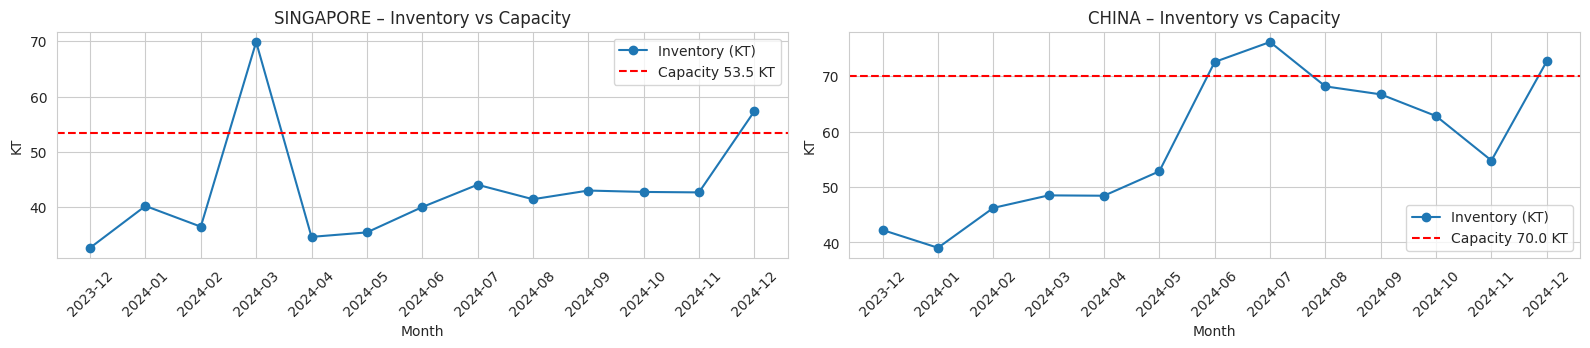

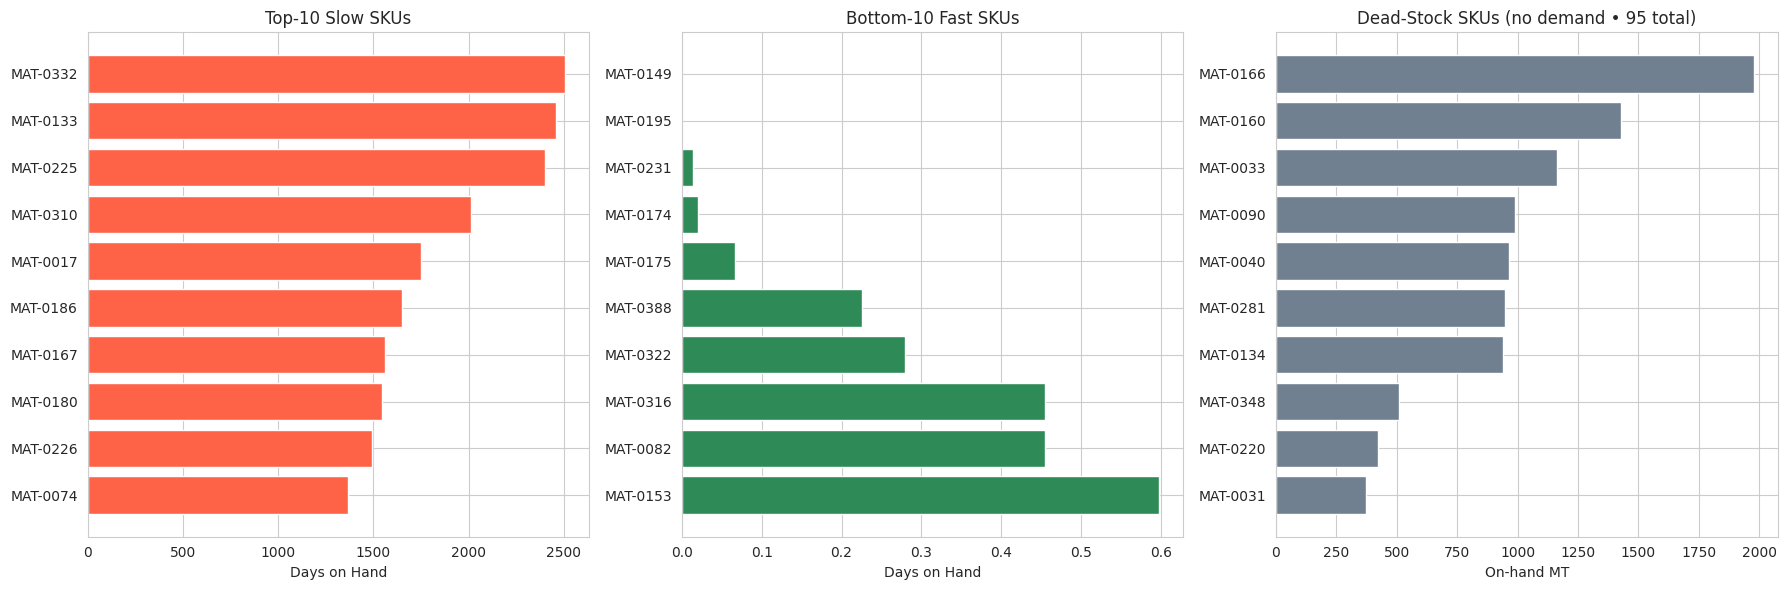

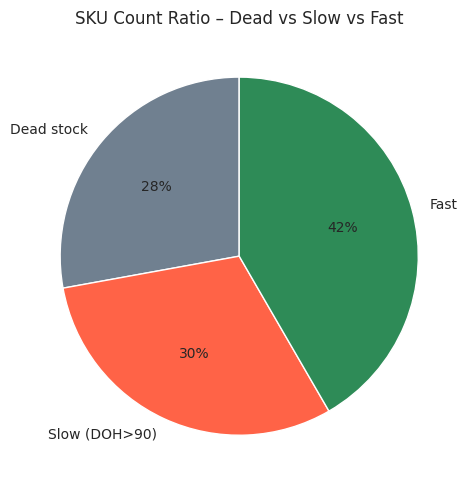

In [ ]:
# =============================================================================
#  Normal-DOH Replenishment Dashboard  (NO capping)
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np, pathlib, re, warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.autolayout'] = True

# ── 🔧 CONFIG ────────────────────────────────────────────────────────────────
BASE            = pathlib.Path('/content')
INVENT_CSV      = BASE/'Inventory.csv'
OUTBOUND_CSV    = BASE/'Outbound.csv'

INV_UNIT        = 'KG'                        # KG | MT | KT
CAPACITY_KT     = {'SINGAPORE': 53.5, 'CHINA': 70.0}
LOOKBACK_MONTHS = 6                           # recent usage window
MIN_DAILY_USE   = 0.14                        # MT/day floor
MONTH_DAYS      = 30
# ────────────────────────────────────────────────────────────────────────────

# helper
wh_tag = lambda n: 'SINGAPORE' if 'SINGAPORE' in n.upper() else 'CHINA'
conv   = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]

# 1 ▸ INVENTORY ----------------------------------------------------------------
inv = pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
inv['STOCK_MT']  = inv['UNRESRICTED_STOCK'] * conv
inv['YearMonth'] = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')
inv['WH']        = inv['PLANT_NAME'].apply(wh_tag)

latest_date = inv['BALANCE_AS_OF_DATE'].max()
stock_now   = (inv[inv['BALANCE_AS_OF_DATE'] == latest_date]
               .groupby('MATERIAL_NAME')['STOCK_MT']
               .sum())

# 2 ▸ OUTBOUND  – recent usage -------------------------------------------------
outb = pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')
outb['WH']        = outb['PLANT_NAME'].apply(wh_tag)

cutoff = (latest_date - pd.DateOffset(months=LOOKBACK_MONTHS)).to_period('M')
recent = outb[outb['YearMonth'] >= cutoff]

avg_daily_use = (recent.groupby(['MATERIAL_NAME','YearMonth'])['NET_QUANTITY_MT']
                         .sum()
                         .groupby('MATERIAL_NAME')
                         .mean()
                         .div(MONTH_DAYS)
                         .rename('AvgDaily_MT'))

# 3 ▸ DOH table (no capping) ---------------------------------------------------
doh = pd.concat([stock_now, avg_daily_use], axis=1).dropna()
doh = doh[doh['AvgDaily_MT'] >= MIN_DAILY_USE]         # filter near-zero demand
doh['DOH'] = doh['STOCK_MT'] / doh['AvgDaily_MT']      # full DOH

top10    = doh.nlargest(10, 'DOH')
bottom10 = doh.nsmallest(10, 'DOH')

dead_stock = stock_now[~stock_now.index.isin(doh.index)]

# 4 ▸ INVENTORY vs CAPACITY ----------------------------------------------------
monthly_inv = (inv.groupby(['WH','YearMonth'])['STOCK_MT']
                 .sum().reset_index())

fig = plt.figure(figsize=(16,6))

for i, wh in enumerate(['SINGAPORE','CHINA']):
    ax = fig.add_subplot(2,2,i+1)
    sub = monthly_inv[monthly_inv['WH']==wh].sort_values('YearMonth')
    ax.plot(sub['YearMonth'].astype(str),
            sub['STOCK_MT']/1000, marker='o', label='Inventory (KT)')
    ax.axhline(CAPACITY_KT[wh], ls='--', color='red',
               label=f'Capacity {CAPACITY_KT[wh]:.1f} KT')
    ax.set_title(f'{wh} – Inventory vs Capacity')
    ax.set_xlabel('Month'); ax.set_ylabel('KT')
    ax.tick_params(axis='x', rotation=45); ax.legend()

# 5 ▸ DOH VISUALS  -----------------------------------------------------------
# ────────────────────────────────────────────────────────────────────────────
# Split into three sets:
#   • top10_slow   – highest DOH among *active* SKUs
#   • bottom10_fast – lowest DOH among *active* SKUs
#   • dead_stock   – no demand in the recent window

top10_slow    = doh.nlargest(10, 'DOH')          # already active only
bottom10_fast = doh.nsmallest(10, 'DOH')

dead_df = (stock_now.drop(index=doh.index)       # SKUs filtered out earlier
                    .sort_values(ascending=False)
                    .reset_index(name='Stock_MT'))

# ── PLOT  -------------------------------------------------------------------
fig = plt.figure(figsize=(18,6))

# A) Top-10 slow movers
ax1 = fig.add_subplot(1,3,1)
ax1.barh(top10_slow.index, top10_slow['DOH'], color='tomato')
ax1.set_title('Top-10 Slow SKUs'); ax1.set_xlabel('Days on Hand')
ax1.invert_yaxis()

# B) Bottom-10 fast movers
ax2 = fig.add_subplot(1,3,2)
ax2.barh(bottom10_fast.index, bottom10_fast['DOH'], color='seagreen')
ax2.set_title('Bottom-10 Fast SKUs'); ax2.set_xlabel('Days on Hand')
ax2.invert_yaxis()

# C) Dead-stock — on-hand MT (top 10 just for readability)
top_dead = dead_df.head(10)
ax3 = fig.add_subplot(1,3,3)
ax3.barh(top_dead['MATERIAL_NAME'], top_dead['Stock_MT'], color='slategray')
ax3.set_title(f'Dead-Stock SKUs (no demand • {len(dead_df)} total)')
ax3.set_xlabel('On-hand MT')
ax3.invert_yaxis()

plt.tight_layout(); plt.show()

# ────────────────────────────────────────────────────────────────────────────
# 6 ▸  Pie chart: SKU count ratio  (Dead  •  Slow  •  Fast)
# ────────────────────────────────────────────────────────────────────────────
SLOW_DOH_THRESHOLD = 90      # days; change if your business rule differs

# -------- counts ----------
dead_count  = len(dead_df)

slow_count  = len(doh[doh['DOH'] >  SLOW_DOH_THRESHOLD])
fast_count  = len(doh[doh['DOH'] <= SLOW_DOH_THRESHOLD])

labels = ['Dead stock', f'Slow (DOH>{SLOW_DOH_THRESHOLD})', 'Fast']
sizes  = [dead_count, slow_count, fast_count]
colors = ['slategray', 'tomato', 'seagreen']

# -------- pie chart -------
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%',
        startangle=90, wedgeprops=dict(edgecolor='white'))
plt.title('SKU Count Ratio – Dead vs Slow vs Fast')
plt.show()





In [ ]:
import pandas as pd

SKU = 'MAT-0078'                     # ← change if your material code differs

# ── 1.  FILTER TO THE ONE SKU ───────────────────────────────────────────────
inv_sku  = inv[inv['MATERIAL_NAME'] == SKU].copy()
out_sku  = outb[outb['MATERIAL_NAME'] == SKU].copy()

# ── 2.  ADD QUARTER COLUMN (e.g. 2024Q1) ────────────────────────────────────
inv_sku['Quarter']  = inv_sku['BALANCE_AS_OF_DATE'].dt.to_period('Q')
out_sku['Quarter']  = out_sku['OUTBOUND_DATE'].dt.to_period('Q')

# ── 3A.  END-OF-QUARTER STOCK  (take latest snapshot in the quarter) ────────
q_stock = (inv_sku.sort_values('BALANCE_AS_OF_DATE')
                   .groupby('Quarter')
                   .tail(1)                       # last row in each quarter
                   [['Quarter','STOCK_MT']]
                   .set_index('Quarter'))

# ── 3B.  TOTAL OUTBOUND PER QUARTER  ────────────────────────────────────────
q_out = (out_sku.groupby('Quarter')['NET_QUANTITY_MT']
                  .sum()
                  .rename('Outbound_MT'))

# ── 4.  MERGE & DISPLAY  ────────────────────────────────────────────────────
q_tbl = q_stock.join(q_out, how='outer').fillna(0)  # zeros if no movement
q_tbl = q_tbl.astype({'STOCK_MT':'float','Outbound_MT':'float'})

print(f"MAT-0332  —  Ending Stock & Outbound by Quarter\n{q_tbl}\n")

# Optional: quick check against the 3 000 MT target
over_3k = q_tbl[(q_tbl['STOCK_MT'] >= 3000) | (q_tbl['Outbound_MT'] >= 3000)]
if over_3k.empty:
    print("No quarter hits or exceeds 3 000 MT for stock or outbound.")
else:
    print("Quarters reaching ≥3 000 MT:\n", over_3k)


MAT-0332  —  Ending Stock & Outbound by Quarter
         STOCK_MT  Outbound_MT
Quarter                       
2023Q4     50.575         0.00
2024Q1     31.575         0.00
2024Q2     50.575         0.00
2024Q3     50.575         0.03
2024Q4     50.575         0.00

No quarter hits or exceeds 3 000 MT for stock or outbound.


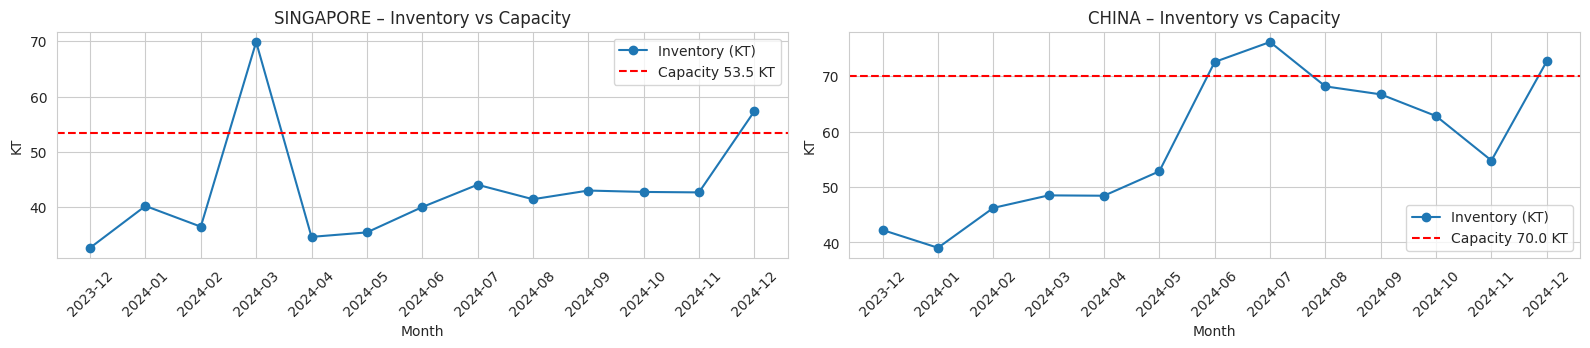

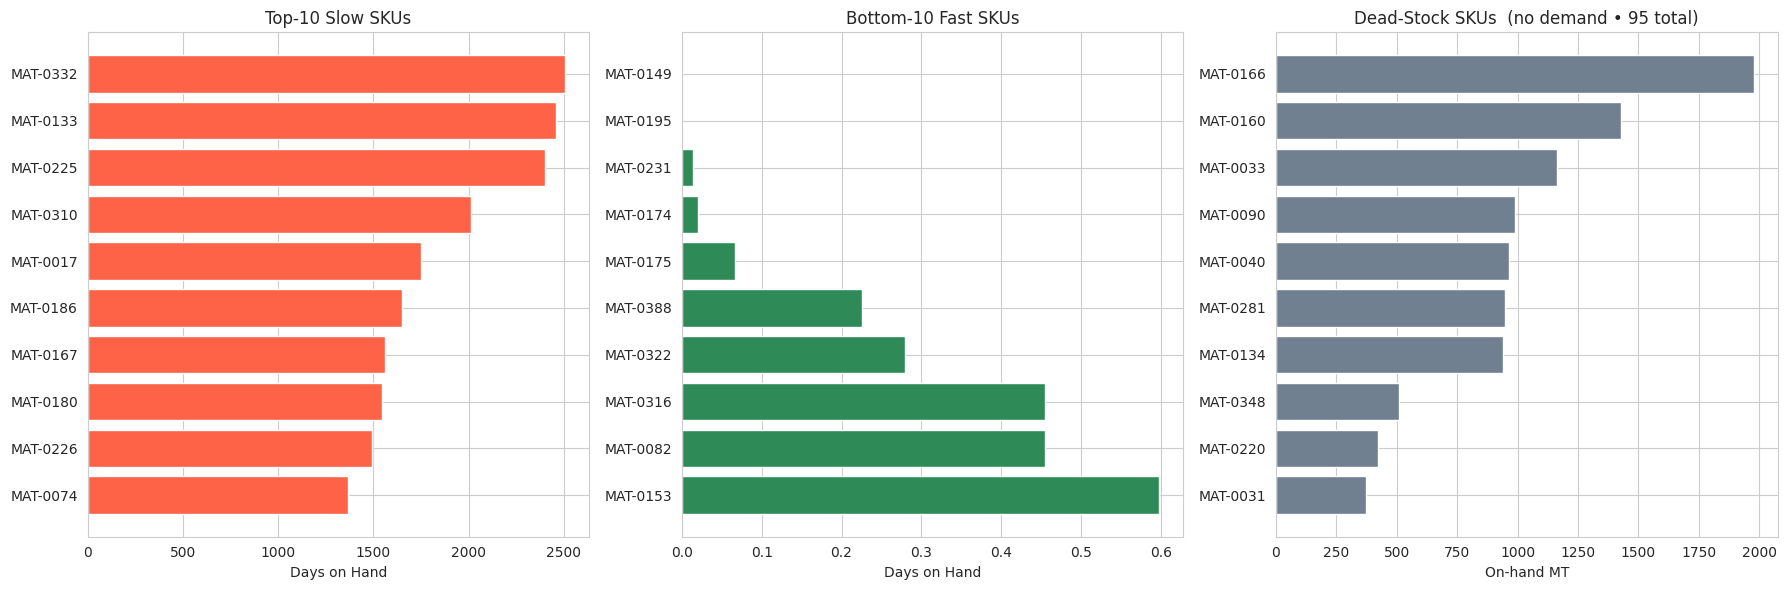

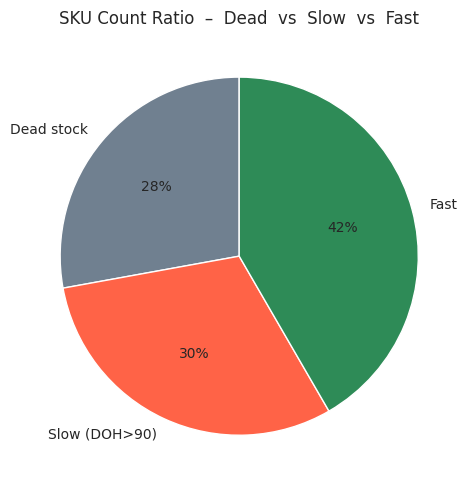

In [ ]:
# =============================================================================
#  Normal-DOH Replenishment Dashboard  (no capping, NaNs removed)
#    • Inventory vs capacity (SG & CN)
#    • Top-10 slow / Bottom-10 fast SKUs
#    • Dead-stock table (no demand in last 6 mo)
#    • Pie chart: Dead / Slow / Fast SKU counts
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np, pathlib, re, warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.autolayout'] = True

# ── 🔧 CONFIG ────────────────────────────────────────────────────────────────
BASE            = pathlib.Path('/content')
INVENT_CSV      = BASE/'Inventory.csv'
OUTBOUND_CSV    = BASE/'Outbound.csv'

INV_UNIT        = 'KG'                        # KG | MT | KT
CAPACITY_KT     = {'SINGAPORE': 53.5, 'CHINA': 70.0}
LOOKBACK_MONTHS = 6                           # usage window
MIN_DAILY_USE   = 0.14                        # MT/day floor
MONTH_DAYS      = 30
SLOW_DOH_THRESHOLD = 90                       # days → slow / fast split
# ────────────────────────────────────────────────────────────────────────────

wh_tag = lambda n: 'SINGAPORE' if 'SINGAPORE' in n.upper() else 'CHINA'
conv   = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]

# 1 ▸ INVENTORY  (drop NaN qty rows) ------------------------------------------
inv = (pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
         .dropna(subset=['UNRESRICTED_STOCK']))

inv['STOCK_MT']  = inv['UNRESRICTED_STOCK'] * conv
inv['YearMonth'] = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')
inv['WH']        = inv['PLANT_NAME'].apply(wh_tag)

latest_date = inv['BALANCE_AS_OF_DATE'].max()
stock_now   = (inv[inv['BALANCE_AS_OF_DATE'] == latest_date]
               .groupby('MATERIAL_NAME')['STOCK_MT']
               .sum())

# 2 ▸ OUTBOUND  (drop NaN qty rows) -------------------------------------------
outb = (pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
         .dropna(subset=['NET_QUANTITY_MT']))

outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')
outb['WH']        = outb['PLANT_NAME'].apply(wh_tag)

cutoff = (latest_date - pd.DateOffset(months=LOOKBACK_MONTHS)).to_period('M')
recent = outb[outb['YearMonth'] >= cutoff]

avg_daily_use = (recent.groupby(['MATERIAL_NAME','YearMonth'])['NET_QUANTITY_MT']
                         .sum()
                         .groupby('MATERIAL_NAME')
                         .mean()
                         .div(MONTH_DAYS)
                         .rename('AvgDaily_MT'))

# 3 ▸ DOH & buckets -----------------------------------------------------------
doh = pd.concat([stock_now, avg_daily_use], axis=1).dropna()
doh = doh[doh['AvgDaily_MT'] >= MIN_DAILY_USE]
doh['DOH'] = doh['STOCK_MT'] / doh['AvgDaily_MT']

top10_slow    = doh.nlargest(10, 'DOH')
bottom10_fast = doh.nsmallest(10, 'DOH')
dead_df       = (stock_now.drop(index=doh.index)
                           .sort_values(ascending=False)
                           .reset_index(name='Stock_MT'))

# 4 ▸ Inventory-vs-capacity lines --------------------------------------------
monthly_inv = (inv.groupby(['WH','YearMonth'])['STOCK_MT']
                 .sum().reset_index())

fig = plt.figure(figsize=(16,6))
for i, wh in enumerate(['SINGAPORE','CHINA']):
    ax = fig.add_subplot(2,2,i+1)
    sub = monthly_inv[monthly_inv['WH']==wh].sort_values('YearMonth')
    ax.plot(sub['YearMonth'].astype(str), sub['STOCK_MT']/1000,
            marker='o', label='Inventory (KT)')
    ax.axhline(CAPACITY_KT[wh], ls='--', color='red',
               label=f'Capacity {CAPACITY_KT[wh]:.1f} KT')
    ax.set_title(f'{wh} – Inventory vs Capacity')
    ax.set_xlabel('Month'); ax.set_ylabel('KT')
    ax.tick_params(axis='x', rotation=45); ax.legend()

# 5 ▸ DOH bar charts + dead-stock --------------------------------------------
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
ax1.barh(top10_slow.index, top10_slow['DOH'], color='tomato')
ax1.set_title('Top-10 Slow SKUs'); ax1.set_xlabel('Days on Hand'); ax1.invert_yaxis()

ax2 = fig.add_subplot(1,3,2)
ax2.barh(bottom10_fast.index, bottom10_fast['DOH'], color='seagreen')
ax2.set_title('Bottom-10 Fast SKUs'); ax2.set_xlabel('Days on Hand'); ax2.invert_yaxis()

top_dead = dead_df.head(10)
ax3 = fig.add_subplot(1,3,3)
ax3.barh(top_dead['MATERIAL_NAME'], top_dead['Stock_MT'], color='slategray')
ax3.set_title(f'Dead-Stock SKUs  (no demand • {len(dead_df)} total)')
ax3.set_xlabel('On-hand MT'); ax3.invert_yaxis()

plt.tight_layout(); plt.show()

# 6 ▸ Pie chart  – SKU count ratio -------------------------------------------
dead_count  = len(dead_df)
slow_count  = len(doh[doh['DOH'] >  SLOW_DOH_THRESHOLD])
fast_count  = len(doh[doh['DOH'] <= SLOW_DOH_THRESHOLD])

labels = ['Dead stock',
          f'Slow (DOH>{SLOW_DOH_THRESHOLD})',
          'Fast']
sizes  = [dead_count, slow_count, fast_count]
colors = ['slategray', 'tomato', 'seagreen']

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%',
        startangle=90, wedgeprops=dict(edgecolor='white'))
plt.title('SKU Count Ratio  –  Dead  vs  Slow  vs  Fast')
plt.show()


In [ ]:
# =============================================================================
#  Quarterly snapshot for a single SKU  (ending stock + outbound total)
# =============================================================================
import pandas as pd

SKU            = 'MAT-0078'   # ← change to any material code you need
TARGET_MT      = 3000         # threshold you care about

# 1 ▸ FILTER cleaned data down to one SKU
inv_sku  = inv[inv['MATERIAL_NAME'] == SKU].copy()
out_sku  = outb[outb['MATERIAL_NAME'] == SKU].copy()

# 2 ▸ Add quarter column (e.g. '2024Q1')
inv_sku['Quarter']  = inv_sku['BALANCE_AS_OF_DATE'].dt.to_period('Q')
out_sku['Quarter']  = out_sku['OUTBOUND_DATE'].dt.to_period('Q')

# 3A ▸ End-of-quarter stock  (latest snapshot in each quarter)
q_stock = (inv_sku.sort_values('BALANCE_AS_OF_DATE')
                   .groupby('Quarter')
                   .tail(1)              # last row in the quarter
                   .set_index('Quarter')['STOCK_MT'])

# 3B ▸ Total outbound per quarter
q_out = (out_sku.groupby('Quarter')['NET_QUANTITY_MT']
                  .sum()
                  .rename('Outbound_MT'))

# 4 ▸ Merge   &   show
q_tbl = (pd.concat([q_stock, q_out], axis=1)
           .fillna(0)
           .astype({'STOCK_MT':float, 'Outbound_MT':float}))

print(f"{SKU}  —  Ending Stock & Outbound by Quarter")
print(q_tbl, "\n")

hits = q_tbl[(q_tbl['STOCK_MT']   >= TARGET_MT) |
             (q_tbl['Outbound_MT'] >= TARGET_MT)]

if hits.empty:
    print(f"No quarter hits ≥ {TARGET_MT:,} MT for stock or outbound.")
else:
    print(f"Quarters reaching ≥ {TARGET_MT:,} MT:\n{hits}\n")


MAT-0078  —  Ending Stock & Outbound by Quarter
         STOCK_MT  Outbound_MT
Quarter                       
2023Q4     50.575         0.00
2024Q1     31.575         0.00
2024Q2     50.575         0.00
2024Q3     50.575         0.03
2024Q4     50.575         0.00 

No quarter hits ≥ 3,000 MT for stock or outbound.


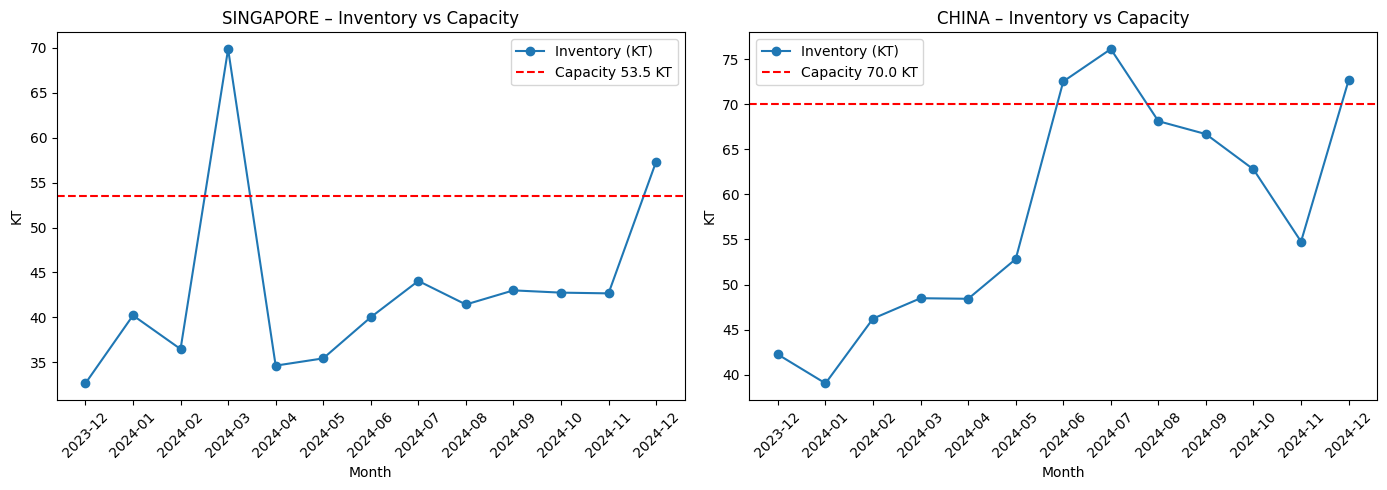

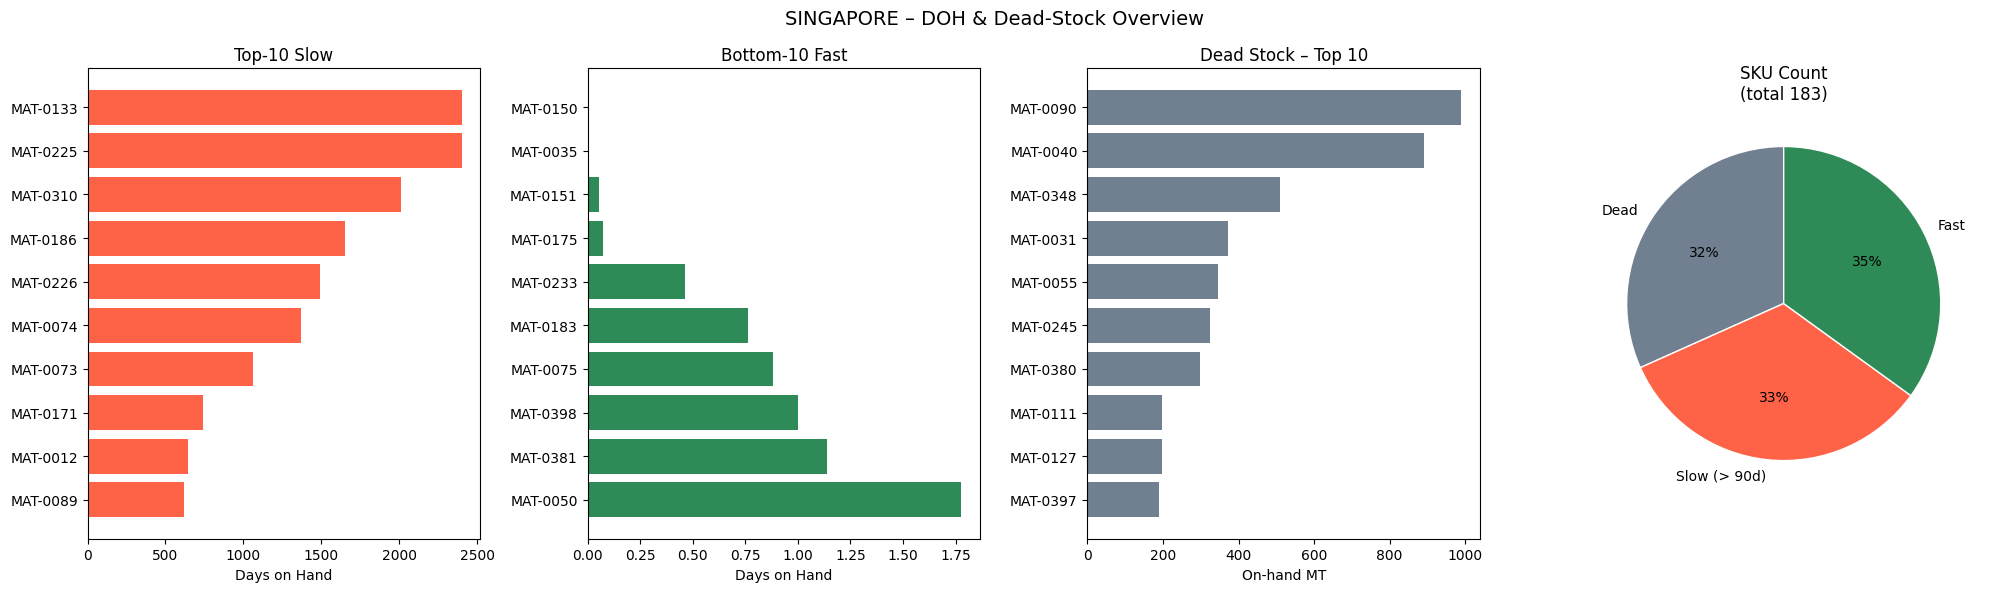

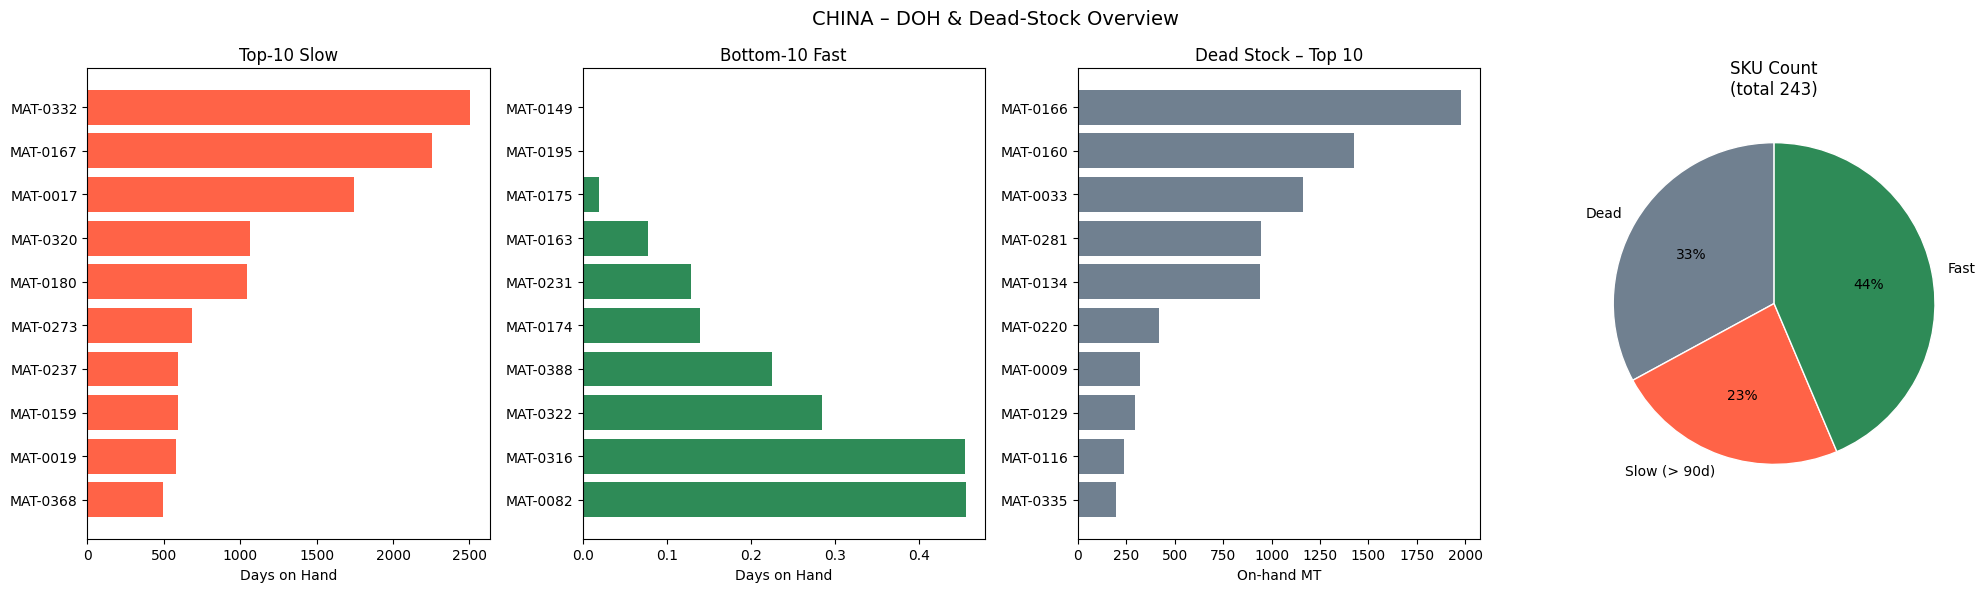

In [ ]:
# =============================================================================
#  Warehouse-specific DOH Dashboards  + Dead-stock graph   (NaNs removed)
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np, pathlib, re, warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.autolayout'] = True

# ── CONFIG ──────────────────────────────────────────────────────────────────
BASE            = pathlib.Path('/content')
INVENT_CSV      = BASE/'Inventory.csv'
OUTBOUND_CSV    = BASE/'Outbound.csv'

INV_UNIT        = 'KG'                       # KG | MT | KT
CAPACITY_KT     = {'SINGAPORE': 53.5, 'CHINA': 70.0}
LOOKBACK_MONTHS = 6
MIN_DAILY_USE   = 0.14                       # MT/day floor for “active”
SLOW_DOH_THRESH = 90                         # days → slow / fast split
MONTH_DAYS      = 30
# ────────────────────────────────────────────────────────────────────────────

wh_tag = lambda n: 'SINGAPORE' if 'SINGAPORE' in n.upper() else 'CHINA'
conv   = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]

# 1 ▸ INVENTORY --------------------------------------------------------------
inv = (pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
         .dropna(subset=['UNRESRICTED_STOCK']))
inv['STOCK_MT']  = inv['UNRESRICTED_STOCK'] * conv
inv['YearMonth'] = inv['BALANCE_AS_OF_DATE'].dt.to_period('M')
inv['WH']        = inv['PLANT_NAME'].apply(wh_tag)
latest_date      = inv['BALANCE_AS_OF_DATE'].max()

# 2 ▸ OUTBOUND ---------------------------------------------------------------
outb = (pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
         .dropna(subset=['NET_QUANTITY_MT']))
outb['YearMonth'] = outb['OUTBOUND_DATE'].dt.to_period('M')
outb['WH']        = outb['PLANT_NAME'].apply(wh_tag)

# 3 ▸ INVENTORY vs CAPACITY (shared lines) -----------------------------------
monthly = (inv.groupby(['WH','YearMonth'])['STOCK_MT'].sum().reset_index())
fig = plt.figure(figsize=(14,5))
for i, wh in enumerate(['SINGAPORE','CHINA']):
    ax = fig.add_subplot(1,2,i+1)
    sub = monthly[monthly['WH']==wh].sort_values('YearMonth')
    ax.plot(sub['YearMonth'].astype(str), sub['STOCK_MT']/1000,
            marker='o', label='Inventory (KT)')
    ax.axhline(CAPACITY_KT[wh], ls='--', color='red',
               label=f'Capacity {CAPACITY_KT[wh]:.1f} KT')
    ax.set_title(f'{wh} – Inventory vs Capacity')
    ax.set_xlabel('Month'); ax.set_ylabel('KT')
    ax.tick_params(axis='x', rotation=45); ax.legend()
plt.tight_layout(); plt.show()

# 4 ▸ PER-WAREHOUSE DASHBOARDS ----------------------------------------------
cutoff = (latest_date - pd.DateOffset(months=LOOKBACK_MONTHS)).to_period('M')

for wh in ['SINGAPORE','CHINA']:
    # latest stock for this WH
    stock_now = (inv[(inv['WH']==wh) & (inv['BALANCE_AS_OF_DATE']==latest_date)]
                 .groupby('MATERIAL_NAME')['STOCK_MT'].sum())

    # recent outbound usage
    recent = outb[(outb['WH']==wh) & (outb['YearMonth'] >= cutoff)]
    avg_use = (recent.groupby(['MATERIAL_NAME','YearMonth'])['NET_QUANTITY_MT']
                     .sum()
                     .groupby('MATERIAL_NAME')
                     .mean()
                     .div(MONTH_DAYS)
                     .rename('AvgDaily_MT'))

    # DOH table
    doh = pd.concat([stock_now, avg_use], axis=1).dropna()
    doh = doh[doh['AvgDaily_MT'] >= MIN_DAILY_USE]
    doh['DOH'] = doh['STOCK_MT'] / doh['AvgDaily_MT']

    top10_slow    = doh.nlargest(10, 'DOH')
    bottom10_fast = doh.nsmallest(10, 'DOH')
    dead_df       = (stock_now.drop(index=doh.index)
                               .sort_values(ascending=False)
                               .reset_index(name='Stock_MT'))

    # counts for pie
    dead_cnt = len(dead_df)
    slow_cnt = len(doh[doh['DOH'] >  SLOW_DOH_THRESH])
    fast_cnt = len(doh[doh['DOH'] <= SLOW_DOH_THRESH])

    # ── PLOT 4-panel figure ───────────────────────────────────────────────
    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f'{wh} – DOH & Dead-Stock Overview', fontsize=14)

    # A) Top-10 slow
    ax1 = fig.add_subplot(1,4,1)
    ax1.barh(top10_slow.index, top10_slow['DOH'], color='tomato')
    ax1.set_title('Top-10 Slow'); ax1.set_xlabel('Days on Hand'); ax1.invert_yaxis()

    # B) Bottom-10 fast
    ax2 = fig.add_subplot(1,4,2)
    ax2.barh(bottom10_fast.index, bottom10_fast['DOH'], color='seagreen')
    ax2.set_title('Bottom-10 Fast'); ax2.set_xlabel('Days on Hand'); ax2.invert_yaxis()

    # C) Dead-stock bar (top 10 by stock)
    top_dead = dead_df.head(10)
    ax3 = fig.add_subplot(1,4,3)
    ax3.barh(top_dead['MATERIAL_NAME'], top_dead['Stock_MT'], color='slategray')
    ax3.set_title(f'Dead Stock – Top 10'); ax3.set_xlabel('On-hand MT')
    ax3.invert_yaxis()

    # D) Pie chart
    ax4 = fig.add_subplot(1,4,4)
    labels = ['Dead', f'Slow (> {SLOW_DOH_THRESH}d)', 'Fast']
    sizes  = [dead_cnt, slow_cnt, fast_cnt]
    colors = ['slategray','tomato','seagreen']
    ax4.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%',
            startangle=90, wedgeprops=dict(edgecolor='white'))
    ax4.set_title(f'SKU Count\n(total {sum(sizes)})')

    plt.tight_layout(); plt.show()


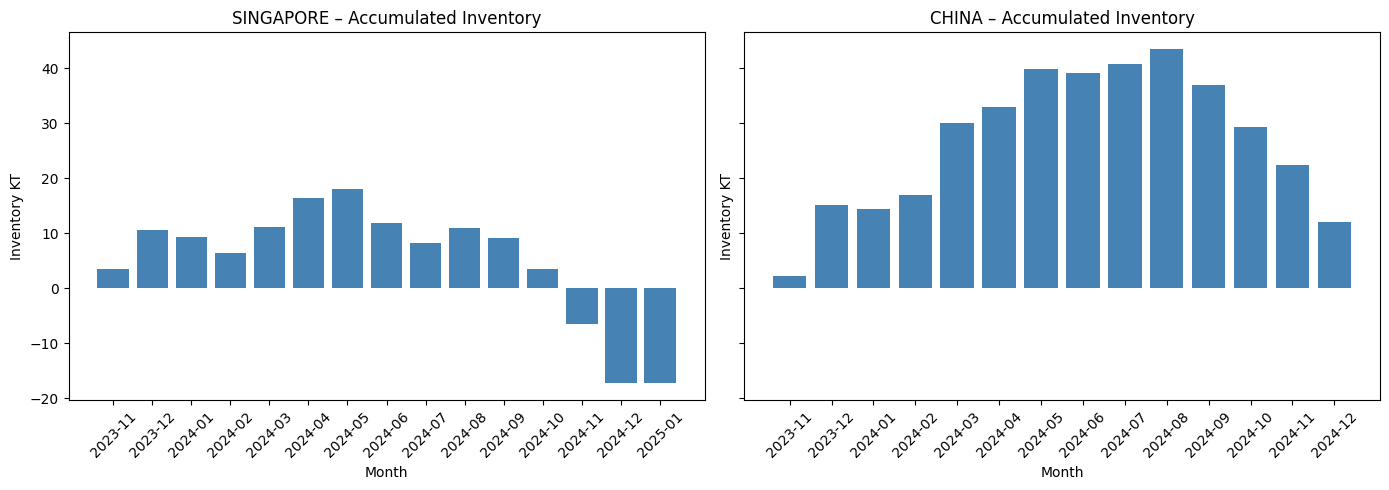

In [ ]:
# =============================================================================
#  Accumulated Inventory  (Prev inv + Inbound – Outbound)  ·  SG vs CN
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np, pathlib, re, warnings
warnings.filterwarnings('ignore')

# ── 🔧 CONFIG ────────────────────────────────────────────────────────────────
BASE          = pathlib.Path('/content')
INBOUND_CSV   = BASE/'Inbound.csv'
OUTBOUND_CSV  = BASE/'Outbound.csv'
INVENT_CSV    = BASE/'Inventory.csv'

INV_UNIT      = 'KG'                    # KG | MT | KT  (same for inbound/outbound qty)
MONTH_DAYS    = 30                      # not used here, only for clarity
# ────────────────────────────────────────────────────────────────────────────
conv = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]
wh_tag = lambda n: 'SINGAPORE' if 'SINGAPORE' in n.upper() else 'CHINA'

# 1 ▸ LOAD inbound/outbound & clean ------------------------------------------
inb = (pd.read_csv(INBOUND_CSV,  parse_dates=['INBOUND_DATE'])
         .dropna(subset=['NET_QUANTITY_MT']))
out = (pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
         .dropna(subset=['NET_QUANTITY_MT']))

inb['WH']  = inb['PLANT_NAME'].apply(wh_tag)
out['WH']  = out['PLANT_NAME'].apply(wh_tag)
inb['YM']  = inb['INBOUND_DATE'].dt.to_period('M')
out['YM']  = out['OUTBOUND_DATE'].dt.to_period('M')

# monthly totals in MT
inb_m = (inb.groupby(['WH','YM'])['NET_QUANTITY_MT'].sum()
             .rename('Inbound_MT'))
out_m = (out.groupby(['WH','YM'])['NET_QUANTITY_MT'].sum()
             .rename('Outbound_MT'))

# 2 ▸ starting inventory (earliest snapshot) ---------------------------------
inv = (pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
         .dropna(subset=['UNRESRICTED_STOCK']))
inv['WH'] = inv['PLANT_NAME'].apply(wh_tag)
inv['STOCK_MT'] = inv['UNRESRICTED_STOCK'] * conv
start_stock = (inv.sort_values('BALANCE_AS_OF_DATE')
                 .groupby('WH')['STOCK_MT']
                 .first())            # earliest snapshot per warehouse

# 3 ▸ build time-series per WH ----------------------------------------------
frames = []
for wh in ['SINGAPORE','CHINA']:
    # calendar range covering both inbound & outbound months
    months = pd.period_range(start=min(inb_m.loc[wh].index.min(),
                                       out_m.loc[wh].index.min()),
                             end=max(inb_m.loc[wh].index.max(),
                                     out_m.loc[wh].index.max()),
                             freq='M')
    inv_series = []
    prev_inv = start_stock.get(wh, 0.0)
    for ym in months:
        in_mt  = inb_m.get((wh, ym), 0.0)
        out_mt = out_m.get((wh, ym), 0.0)
        curr_inv = prev_inv + in_mt - out_mt
        inv_series.append({'WH':wh,'YM':ym,'Inventory_KT':curr_inv/1000})
        prev_inv = curr_inv
    frames.append(pd.DataFrame(inv_series))

accum = pd.concat(frames)

# 4 ▸ PLOT  ------------------------------------------------------------------
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for ax, wh in zip(axes, ['SINGAPORE','CHINA']):
    sub = accum[accum['WH']==wh]
    ax.bar(sub['YM'].astype(str), sub['Inventory_KT'], color='steelblue')
    ax.set_title(f'{wh} – Accumulated Inventory')
    ax.set_ylabel('Inventory KT')
    ax.set_xlabel('Month')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()


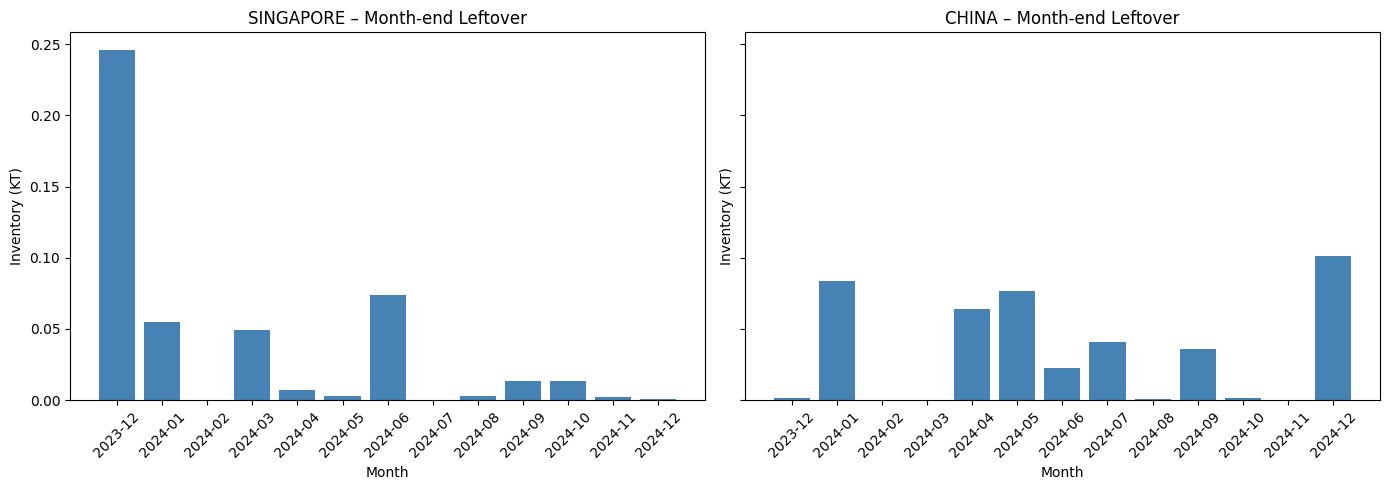

In [ ]:
# =============================================================================
#  Month-end *actual* leftover inventory  ·  SG vs CN
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, pathlib, re, warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.autolayout"] = True

# ── 🔧 CONFIG ────────────────────────────────────────────────────────────────
BASE         = pathlib.Path("/content")
INVENT_CSV   = BASE / "Inventory.csv"

INV_UNIT     = "KG"                    # KG | MT | KT  (unit stored in Inventory.csv)
# ────────────────────────────────────────────────────────────────────────────
conv = {"KG":1/1_000, "MT":1, "KT":1_000}[INV_UNIT.upper()]
wh_tag = lambda n: "SINGAPORE" if "SINGAPORE" in n.upper() else "CHINA"

# 1 ▸ LOAD inventory & clean --------------------------------------------------
inv = (pd.read_csv(INVENT_CSV, parse_dates=["BALANCE_AS_OF_DATE"])
         .dropna(subset=["UNRESRICTED_STOCK"]))      # keep rows with real qty

inv["STOCK_MT"]  = inv["UNRESRICTED_STOCK"] * conv
inv["YearMonth"] = inv["BALANCE_AS_OF_DATE"].dt.to_period("M")
inv["WH"]        = inv["PLANT_NAME"].apply(wh_tag)

# 2 ▸ LATEST SNAPSHOT PER MONTH  ---------------------------------------------
month_end = (inv.sort_values("BALANCE_AS_OF_DATE")
               .groupby(["WH","YearMonth"])
               .tail(1)                               # last row in each month
               .reset_index(drop=True))

# summarise to KT for plotting
month_end["Inventory_KT"] = month_end["STOCK_MT"] / 1000

# 3 ▸ PLOT  -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

for ax, wh in zip(axes, ["SINGAPORE","CHINA"]):
    sub = month_end[month_end["WH"] == wh]
    ax.bar(sub["YearMonth"].astype(str), sub["Inventory_KT"],
           color="steelblue")
    ax.set_title(f"{wh} – Month-end Leftover")
    ax.set_ylabel("Inventory (KT)")
    ax.set_xlabel("Month")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout(); plt.show()




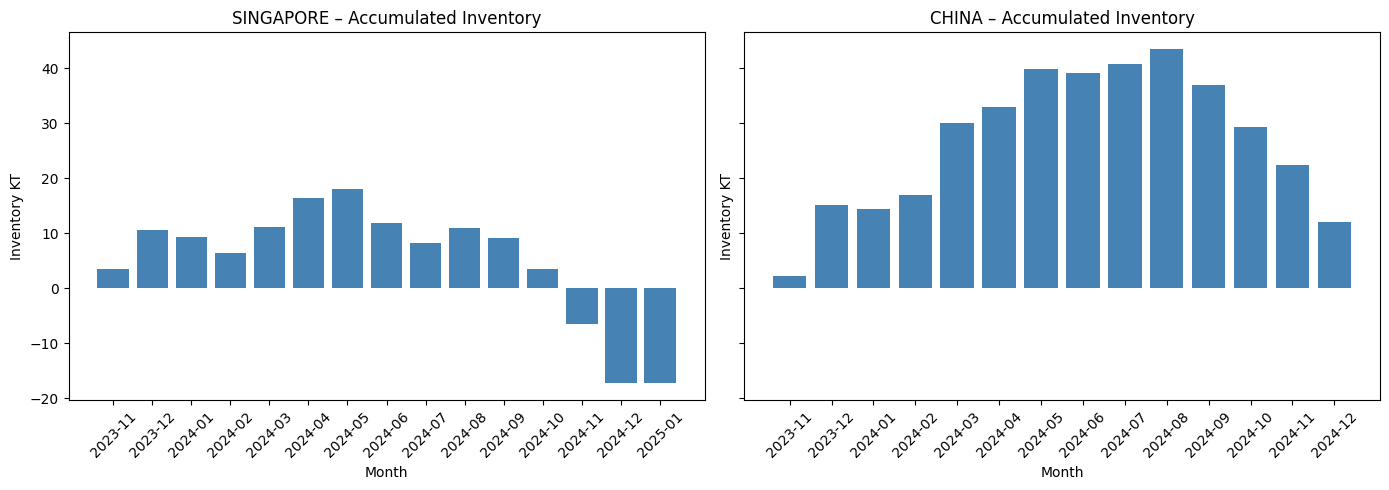


=== SINGAPORE  cumulative flow check ===============================
⚠️  First calculated negative balance: 2024-11
         Cum_In_MT  Cum_Out_MT  Calc_Bal_MT
2023-11     3576.8         0.0       3589.2
2023-12    10696.6       169.1      10540.0
2024-01    17563.6      8199.5       9376.6
2024-02    24692.6     18246.3       6458.8
2024-03    40550.6     29354.1      11209.0
2024-04    54578.0     38173.3      16417.2
2024-05    66826.6     48675.3      18163.8
2024-06    73060.1     61130.9      11941.7
2024-07    81719.1     73460.2       8271.4
2024-08    97690.8     86784.3      10919.1
2024-09   108201.5     99062.0       9151.9
2024-10   117802.2    114216.1       3598.6
2024-11   122147.0    128628.9      -6469.4
2024-12   122687.0    139881.0     -17181.5
2025-01   122687.0    139955.3     -17255.8

=== CHINA  cumulative flow check ===============================
No negative calculated balance.
         Cum_In_MT  Cum_Out_MT  Calc_Bal_MT
2023-11     2307.9         0.0       

In [ ]:
# =============================================================================
#  Accumulated Inventory  +  Diagnostic Trace
#    – drops any NaN quantity rows
#    – bar chart SG / CN
#    – prints month-by-month cumulative flow to find data gaps
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np, pathlib, re, warnings
warnings.filterwarnings("ignore")

# ── 🔧 CONFIG ────────────────────────────────────────────────────────────────
BASE          = pathlib.Path("/content")
INBOUND_CSV   = BASE/'Inbound.csv'
OUTBOUND_CSV  = BASE/'Outbound.csv'
INVENT_CSV    = BASE/'Inventory.csv'

INV_UNIT      = 'KG'               # KG | MT | KT  (same in all three files)
# ────────────────────────────────────────────────────────────────────────────
conv   = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]
wh_tag = lambda n: 'SINGAPORE' if 'SINGAPORE' in n.upper() else 'CHINA'

# 1 ▸ LOAD AND CLEAN INBOUND / OUTBOUND --------------------------------------
inb = (pd.read_csv(INBOUND_CSV,  parse_dates=['INBOUND_DATE'])
         .dropna(subset=['NET_QUANTITY_MT']))
out = (pd.read_csv(OUTBOUND_CSV, parse_dates=['OUTBOUND_DATE'])
         .dropna(subset=['NET_QUANTITY_MT']))

inb['WH'] = inb['PLANT_NAME'].map(wh_tag)
out['WH'] = out['PLANT_NAME'].map(wh_tag)
inb['YM'] = inb['INBOUND_DATE'].dt.to_period('M')
out['YM'] = out['OUTBOUND_DATE'].dt.to_period('M')

# monthly totals (MT)
inb_m = (inb.groupby(['WH','YM'])['NET_QUANTITY_MT'].sum()
             .rename('Inbound_MT'))
out_m = (out.groupby(['WH','YM'])['NET_QUANTITY_MT'].sum()
             .rename('Outbound_MT'))

# 2 ▸ STARTING INVENTORY (earliest snapshot) ---------------------------------
inv = (pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
         .dropna(subset=['UNRESRICTED_STOCK']))
inv['WH']        = inv['PLANT_NAME'].map(wh_tag)
inv['STOCK_MT']  = inv['UNRESRICTED_STOCK'] * conv

start_stock = (inv.sort_values('BALANCE_AS_OF_DATE')
                 .groupby('WH')['STOCK_MT']
                 .first())                       # earliest snapshot per WH

# 3 ▸ BUILD ACCUMULATED BALANCE SERIES ---------------------------------------
frames = []
for wh in ['SINGAPORE','CHINA']:
    # full month range present in either flow table
    months = pd.period_range(start=min(inb_m.loc[wh].index.min(),
                                       out_m.loc[wh].index.min()),
                             end  =max(inb_m.loc[wh].index.max(),
                                       out_m.loc[wh].index.max()),
                             freq='M')
    bal = []
    prev = start_stock.get(wh, 0.0)
    for ym in months:
        prev += inb_m.get((wh, ym), 0.0) - out_m.get((wh, ym), 0.0)
        bal.append({'WH':wh,'YM':ym,'Inventory_KT':prev/1000})
    frames.append(pd.DataFrame(bal))

accum = pd.concat(frames)

# 4 ▸ PLOT BAR CHART ----------------------------------------------------------
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
for ax, wh in zip(axes, ['SINGAPORE','CHINA']):
    sub = accum[accum['WH']==wh]
    ax.bar(sub['YM'].astype(str), sub['Inventory_KT'], color='steelblue')
    ax.set_title(f'{wh} – Accumulated Inventory')
    ax.set_ylabel('Inventory KT'); ax.set_xlabel('Month')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()

# 5 ▸ DIAGNOSTIC TRACE --------------------------------------------------------
for wh in ['SINGAPORE','CHINA']:
    print(f'\n=== {wh}  cumulative flow check ===============================')

    in_wh  = inb_m.loc[wh]  # inbound MT per month
    out_wh = out_m.loc[wh]  # outbound MT per month

    months = pd.period_range(start=min(in_wh.index.min(), out_wh.index.min()),
                             end  =max(in_wh.index.max(), out_wh.index.max()),
                             freq='M')
    cum_in  = in_wh.reindex(months, fill_value=0.0).cumsum().values
    cum_out = out_wh.reindex(months, fill_value=0.0).cumsum().values
    start   = start_stock.get(wh, 0.0)
    bal     = start + cum_in - cum_out

    df_diag = pd.DataFrame({
        'Cum_In_MT'  : cum_in,
        'Cum_Out_MT' : cum_out,
        'Calc_Bal_MT': bal
    }, index=months.astype(str))

    neg_mask = df_diag['Calc_Bal_MT'] < 0
    if neg_mask.any():
        first_neg = df_diag[neg_mask].index[0]
        print(f'⚠️  First calculated negative balance: {first_neg}')
    else:
        print('No negative calculated balance.')

    print(df_diag.head(24).round(1))   # print first 24 months for brevity


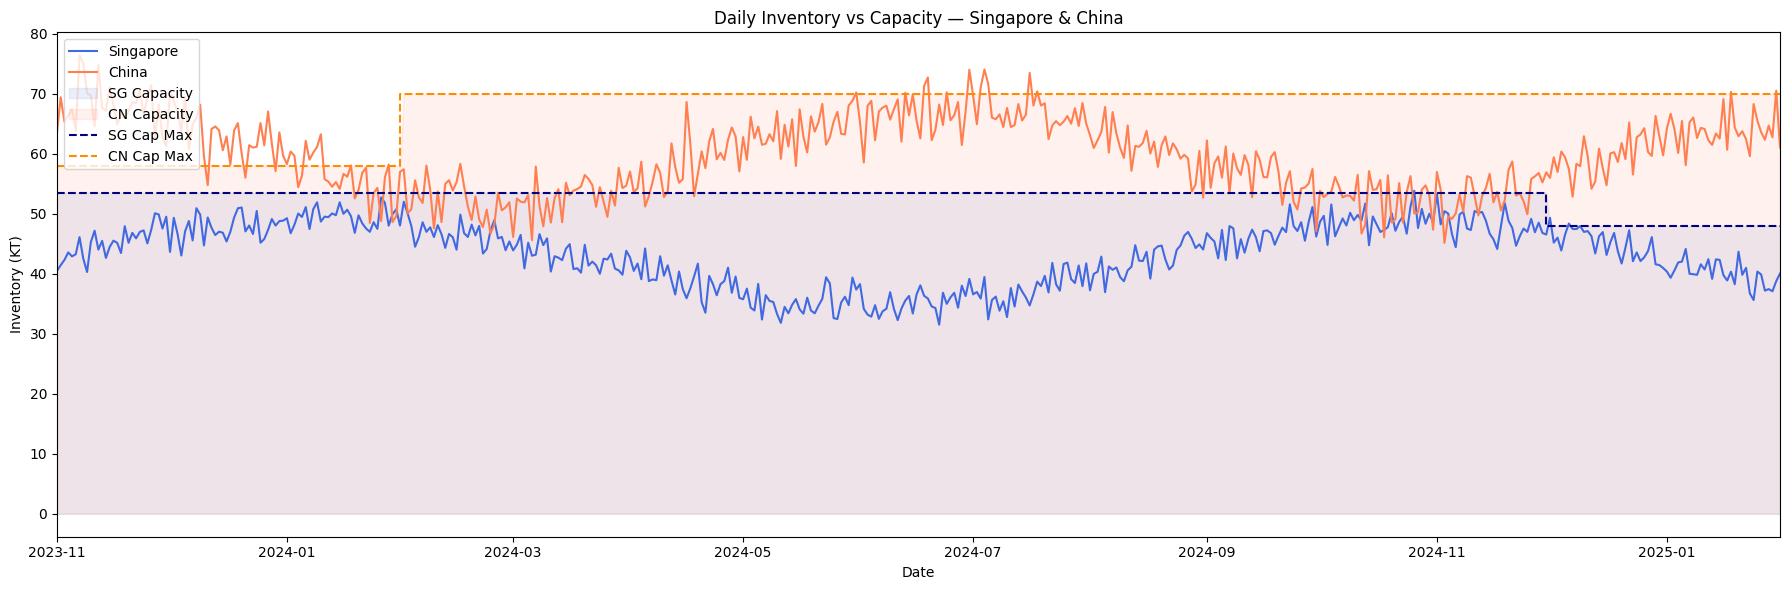

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---- Replace this with your real daily inventory data ----
# Columns: Date (datetime), Warehouse (Singapore/China), Inventory_KT (float)
# Example structure:
# df = pd.read_csv('your_daily_inventory.csv', parse_dates=['Date'])

# For demo: build fake data
dates = pd.date_range('2023-11-01', '2025-01-31', freq='D')
sg_inv = np.clip(42 + np.sin(np.linspace(0,10,len(dates))) * 7 + np.random.normal(0,2,len(dates)), 0, 60)
cn_inv = np.clip(60 + np.cos(np.linspace(0,12,len(dates))) * 8 + np.random.normal(0,3,len(dates)), 0, 80)
df = pd.DataFrame({'Date': np.tile(dates,2),
                   'Warehouse': ['Singapore']*len(dates) + ['China']*len(dates),
                   'Inventory_KT': np.concatenate([sg_inv, cn_inv])})

# --- CAPACITY: Build a DataFrame with capacity values by day per warehouse ---
cap_sg = []
cap_cn = []
for date in dates:
    # Singapore: 53.5 until Nov 2024, then 48 in Dec 2024, 48 in Jan 2025
    if date < pd.Timestamp('2024-12-01'):
        cap_sg.append(53.5)
    else:
        cap_sg.append(48)
    # China: 58 in Jan 2024, 70 from Feb 2024
    if date < pd.Timestamp('2024-02-01'):
        cap_cn.append(58)
    else:
        cap_cn.append(70)
cap_df = pd.DataFrame({'Date': dates, 'Singapore': cap_sg, 'China': cap_cn})

# --- Pivot inventory for fast access ---
pivot = df.pivot(index='Date', columns='Warehouse', values='Inventory_KT')
# Align with capacity for easy plotting
pivot = pivot.reindex(dates)

plt.figure(figsize=(18,6))
# Plot inventory lines
plt.plot(dates, pivot['Singapore'], label='Singapore', color='royalblue')
plt.plot(dates, pivot['China'], label='China', color='coral')

# Highlight the capacity bands
plt.fill_between(dates, 0, cap_df['Singapore'], color='royalblue', alpha=0.10, label='SG Capacity')
plt.fill_between(dates, 0, cap_df['China'], color='coral', alpha=0.10, label='CN Capacity')

# Optionally plot the changing cap as a step line for clarity
plt.step(dates, cap_df['Singapore'], color='navy', lw=1.5, ls='--', label='SG Cap Max')
plt.step(dates, cap_df['China'], color='darkorange', lw=1.5, ls='--', label='CN Cap Max')

plt.ylabel('Inventory (KT)')
plt.xlabel('Date')
plt.title('Daily Inventory vs Capacity — Singapore & China')
plt.legend(loc='upper left')
plt.xlim([dates[0], dates[-1]])
plt.tight_layout()
plt.show()




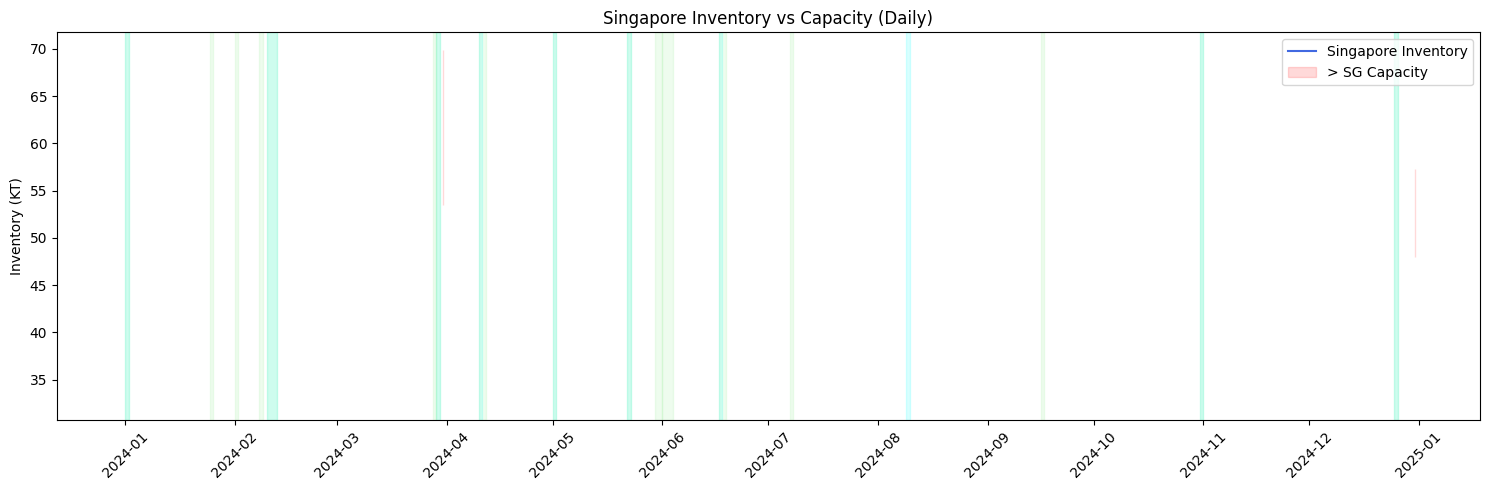

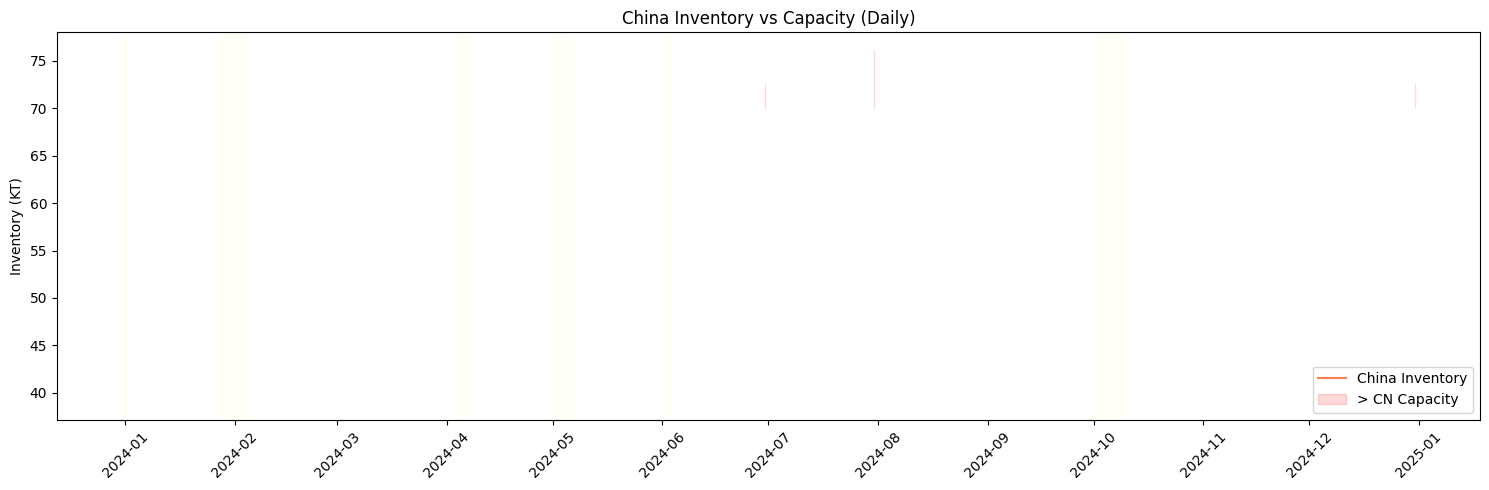

In [ ]:
# =============================================================================
#  Daily Inventory vs Capacity with Holiday Highlights   ·  SG & CN
# =============================================================================
import pandas as pd, matplotlib.pyplot as plt, numpy as np, pathlib, re, datetime as dt, matplotlib.dates as mdates, warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.autolayout'] = True

# ── CONFIG ──────────────────────────────────────────────────────────────────
BASE         = pathlib.Path('/content')
INVENT_CSV   = BASE/'Inventory.csv'        # real file
INV_UNIT     = 'KG'                        # KG | MT | KT  (unit in CSV)

cap_sg = lambda d: 48 if (d.year, d.month) == (2024,12) else 53.5  # KT
cap_cn = lambda d: 58 if (d.year, d.month) == (2024,1) else 70     # KT

sg_holidays = [
    ('2024-01-01','2024-01-01'), ('2024-02-10','2024-02-12'),
    ('2024-03-29','2024-03-29'), ('2024-04-10','2024-04-10'),
    ('2024-05-01','2024-05-01'), ('2024-05-22','2024-05-22'),
    ('2024-06-17','2024-06-17'), ('2024-08-09','2024-08-09'),
    ('2024-10-31','2024-10-31'), ('2024-12-25','2024-12-25')
]
my_holidays = [
    ('2024-01-01','2024-01-01'), ('2024-01-25','2024-01-25'),
    ('2024-02-01','2024-02-01'), ('2024-02-08','2024-02-08'),
    ('2024-02-10','2024-02-12'), ('2024-03-28','2024-03-28'),
    ('2024-03-29','2024-03-29'), ('2024-04-10','2024-04-11'),
    ('2024-05-01','2024-05-01'), ('2024-05-22','2024-05-22'),
    ('2024-05-30','2024-05-31'), ('2024-06-01','2024-06-03'),
    ('2024-06-17','2024-06-18'), ('2024-07-07','2024-07-07'),
    ('2024-09-16','2024-09-16'), ('2024-10-31','2024-10-31'),
    ('2024-12-25','2024-12-25')
]
cn_holidays = [
    ('2024-01-01','2024-01-01'), ('2024-01-28','2024-02-04'),
    ('2024-04-04','2024-04-06'), ('2024-05-01','2024-05-05'),
    ('2024-06-02','2024-06-02'), ('2024-10-01','2024-10-08')
]
# ────────────────────────────────────────────────────────────────────────────
conv = {'KG':1/1_000, 'MT':1, 'KT':1_000}[INV_UNIT.upper()]
wh_tag = lambda n: 'SINGAPORE' if 'SINGAPORE' in n.upper() else 'CHINA'

# 1 ▸ LOAD & PREP INVENTORY ---------------------------------------------------
inv = (pd.read_csv(INVENT_CSV, parse_dates=['BALANCE_AS_OF_DATE'])
         .dropna(subset=['UNRESRICTED_STOCK']))
inv['WH'] = inv['PLANT_NAME'].apply(wh_tag)
inv['Stock_KT'] = inv['UNRESRICTED_STOCK'] * conv / 1000     # → KT
inv['Date'] = inv['BALANCE_AS_OF_DATE'].dt.date

# daily sum per warehouse
daily = (inv.groupby(['Date','WH'])['Stock_KT']
           .sum()
           .unstack('WH')
           .sort_index())

# re-index full calendar range 2023-11-01 .. 2025-01-31
full_rng = pd.date_range('2023-11-01','2025-01-31', freq='D').date
daily = daily.reindex(full_rng)

# 2 ▸ PLOT  SG (with SG+MY holidays) ------------------------------------------
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(daily.index, daily['SINGAPORE'], color='royalblue', lw=1.5,
        label='Singapore Inventory')

# capacity highlight: shade area above capacity
cap_series = [cap_sg(dt.date.fromisoformat(str(d))) for d in daily.index]
ax.fill_between(daily.index, cap_series, daily['SINGAPORE'],
                where=(daily['SINGAPORE']>cap_series),
                color='red', alpha=0.15, label='> SG Capacity')

# holiday shading
def shade(ax, periods, color, alpha):
    for start,end in periods:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end)+pd.Timedelta(days=1),
                   color=color, alpha=alpha)

shade(ax, sg_holidays, 'cyan', 0.15)
shade(ax, my_holidays, 'lightgreen', 0.15)

ax.set_title('Singapore Inventory vs Capacity (Daily)')
ax.set_ylabel('Inventory (KT)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# 3 ▸ PLOT  CN (with CN holidays) --------------------------------------------
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(daily.index, daily['CHINA'], color='coral', lw=1.5,
        label='China Inventory')

cap_cn_series = [cap_cn(dt.date.fromisoformat(str(d))) for d in daily.index]
ax.fill_between(daily.index, cap_cn_series, daily['CHINA'],
                where=(daily['CHINA']>cap_cn_series),
                color='red', alpha=0.15, label='> CN Capacity')

shade(ax, cn_holidays, 'lightyellow', 0.25)

ax.set_title('China Inventory vs Capacity (Daily)')
ax.set_ylabel('Inventory (KT)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


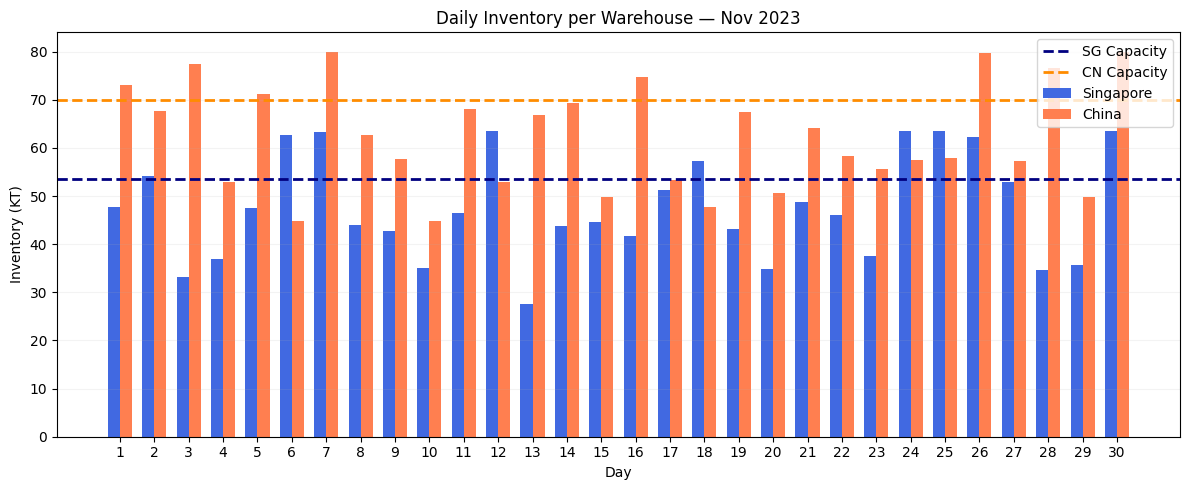

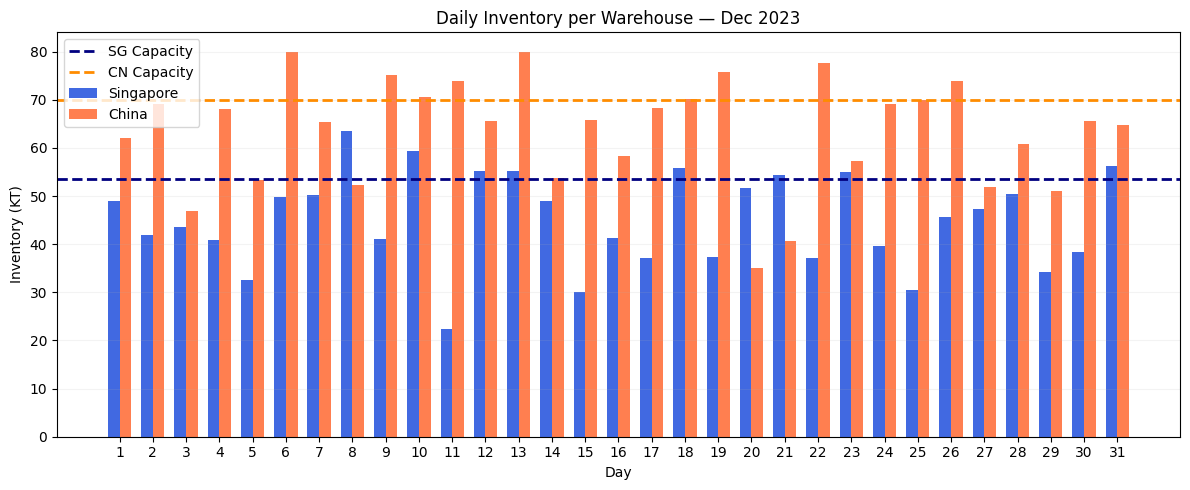

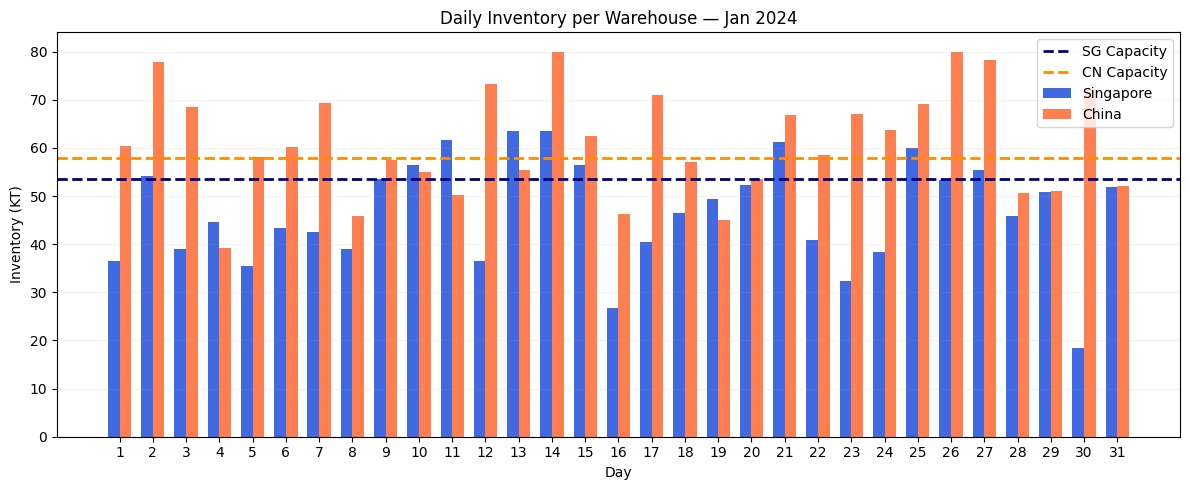

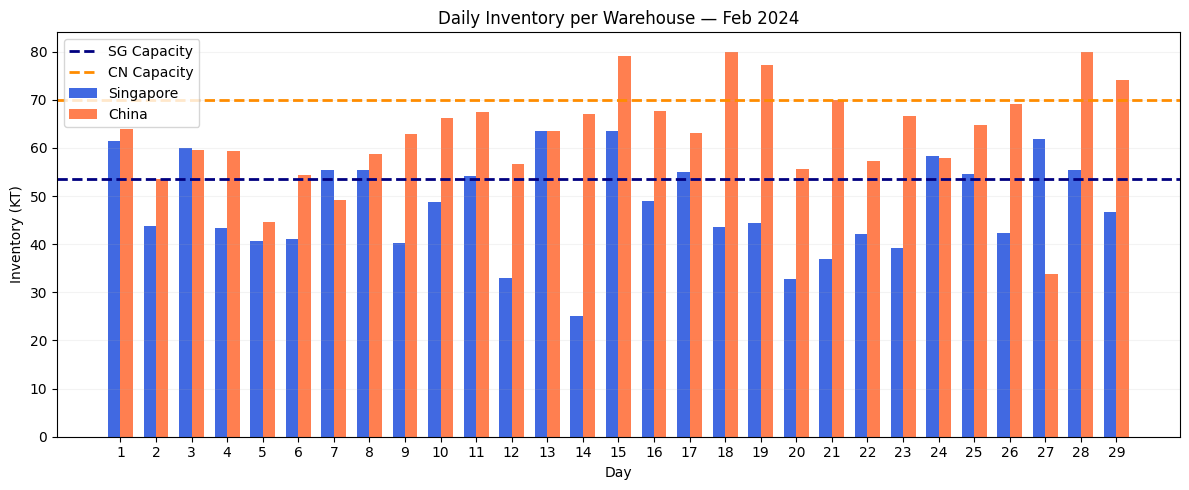

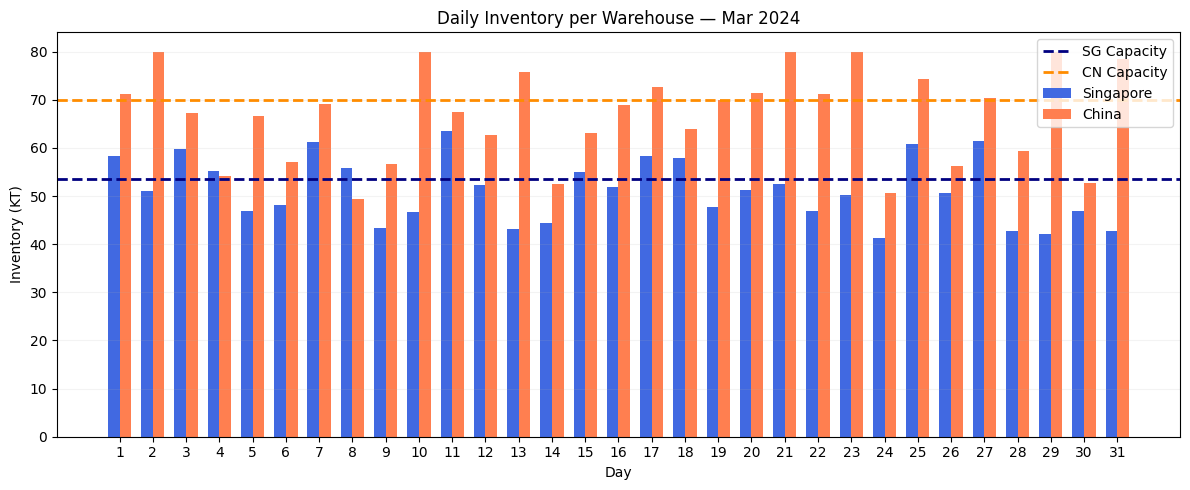

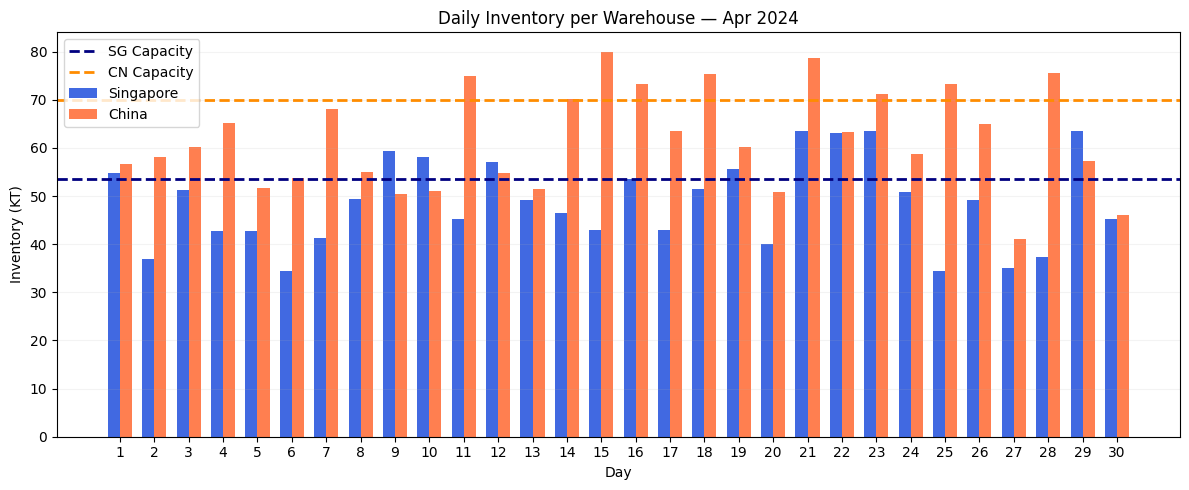

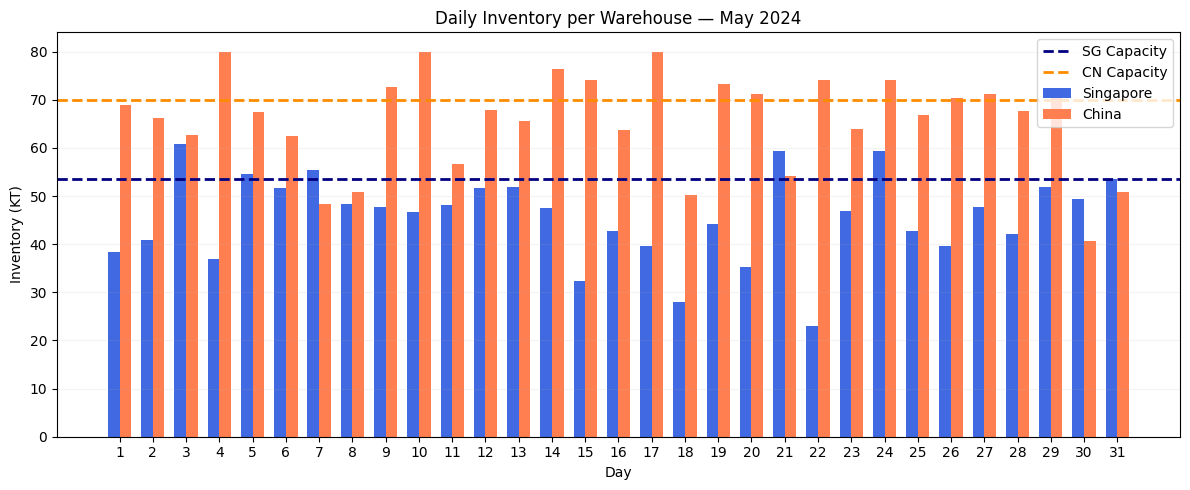

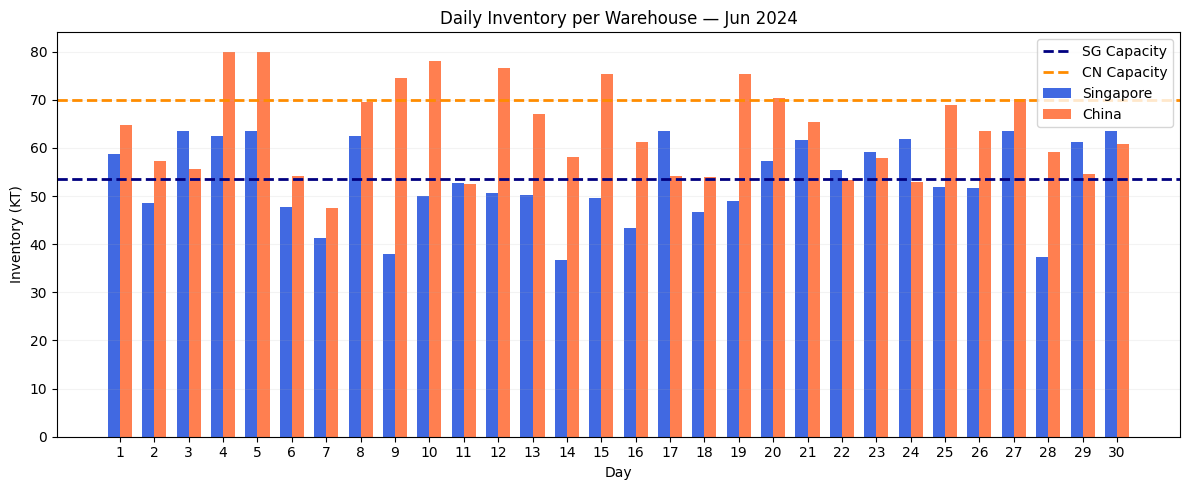

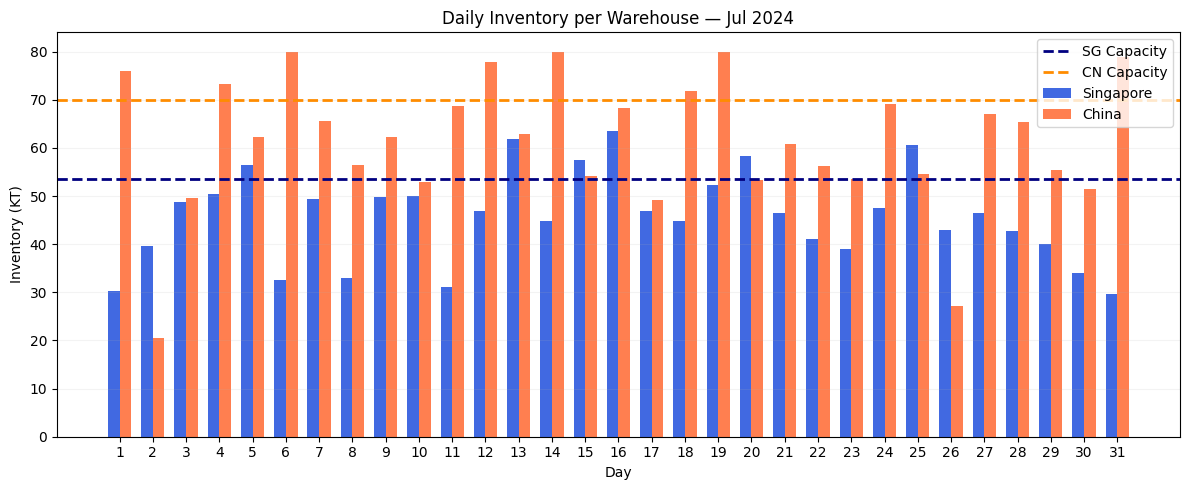

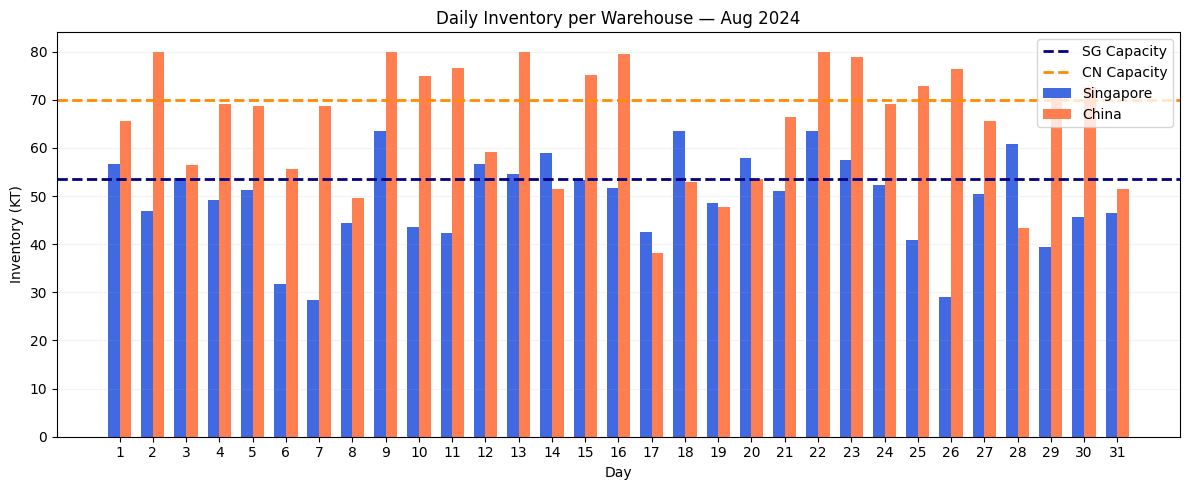

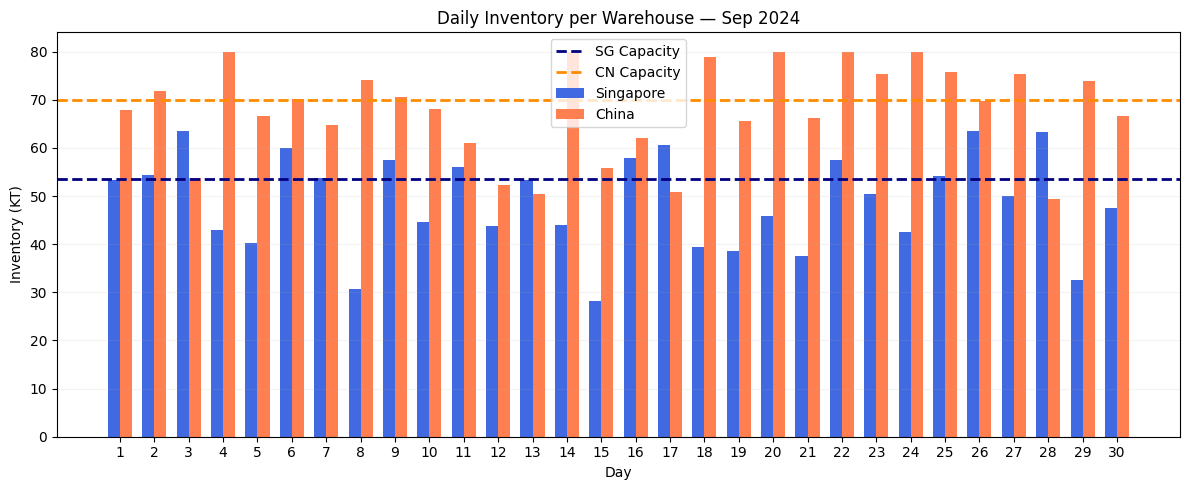

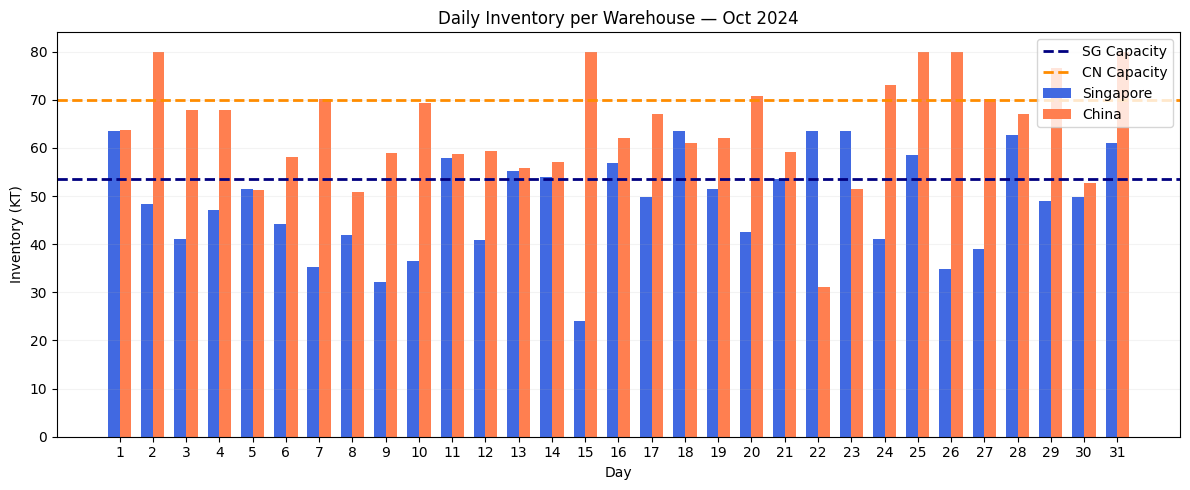

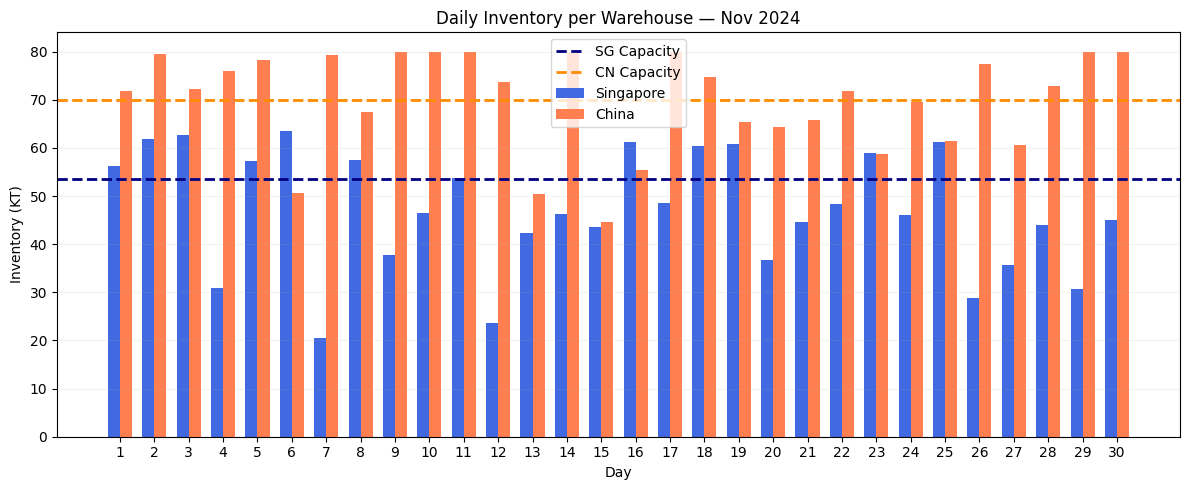

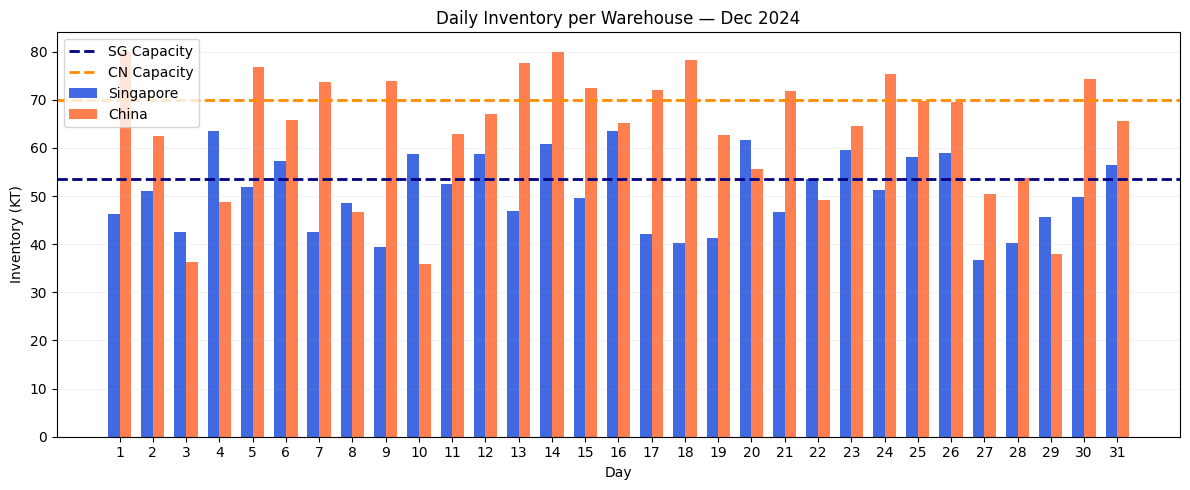

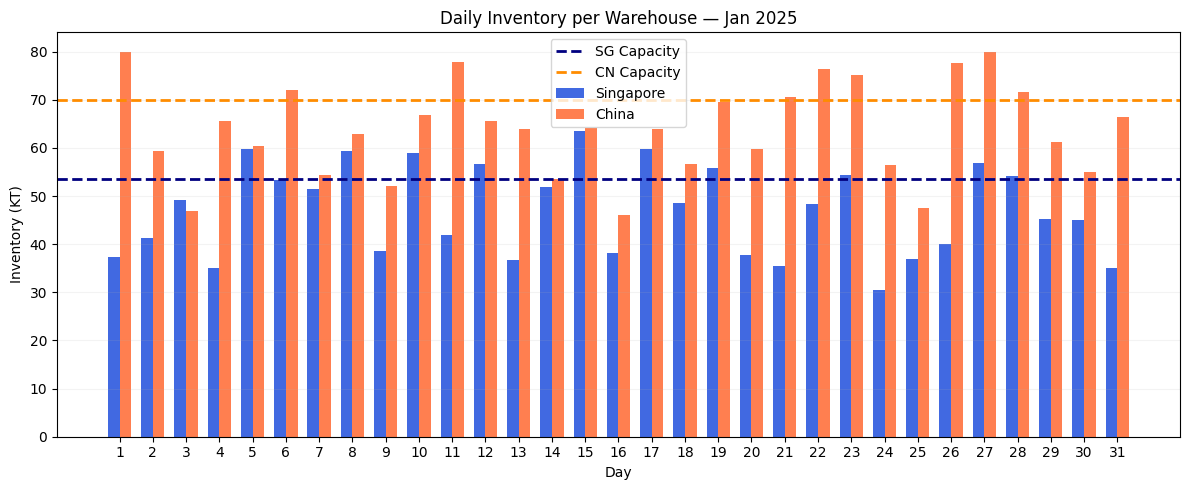

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar

# -------- Replace this with your actual data load ---------
# Example structure:
# df = pd.read_csv('/content/daily_inventory.csv', parse_dates=['Date'])
# Columns: ['Date', 'Warehouse', 'Inventory_KT']

# ----- DEMO DUMMY DATA FOR STRUCTURE (remove this block!) -----
rng = pd.date_range('2023-11-01', '2025-01-31', freq='D')
warehouse = []
inv_kt = []
for date in rng:
    for wh, cap, jitter in [('Singapore', 53.5, 10), ('China', 70, 12)]:
        warehouse.append(wh)
        # generate values that hover around capacity but fluctuate
        base = cap - 5 + np.random.normal(0, jitter)
        inv_kt.append(np.clip(base, 0, cap+10))
df = pd.DataFrame({'Date': np.repeat(rng, 2), 'Warehouse': warehouse, 'Inventory_KT': inv_kt})
# -----------------------------------------------------------

# Set capacities (for plotting line)
cap_dict = {
    'Singapore': [53.5]*12 + [48],  # If you want to vary per month, set as needed
    'China': [58] + [70]*12
}
month_list = pd.period_range('2023-11', '2025-01', freq='M')

for period in month_list:
    month_start = period.start_time
    days = calendar.monthrange(period.year, period.month)[1]
    month_end = period.start_time + pd.offsets.Day(days - 1)
    # filter for this month only
    mask = (df['Date'] >= month_start) & (df['Date'] <= month_end)
    sub = df.loc[mask]

    # Pivot: rows=Day, columns=Warehouse, values=Inventory_KT
    day_df = sub.copy()
    day_df['Day'] = day_df['Date'].dt.day
    piv = day_df.pivot(index='Day', columns='Warehouse', values='Inventory_KT')

    # Ensure all days present
    all_days = np.arange(1, days+1)
    piv = piv.reindex(all_days)

    # Pick correct capacities
    sg_cap = cap_dict['Singapore'][period.month-1] if period.year == 2024 else 53.5
    cn_cap = cap_dict['China'][period.month-1] if period.year == 2024 else 70

    x = all_days
    bar_width = 0.35

    plt.figure(figsize=(12,5))
    plt.bar(x - bar_width/2, piv['Singapore'], width=bar_width, color='royalblue', label='Singapore')
    plt.bar(x + bar_width/2, piv['China'], width=bar_width, color='coral', label='China')

    plt.axhline(sg_cap, color='navy', ls='--', lw=2, label='SG Capacity')
    plt.axhline(cn_cap, color='darkorange', ls='--', lw=2, label='CN Capacity')

    plt.xticks(x)
    plt.ylabel('Inventory (KT)')
    plt.xlabel('Day')
    plt.title(f'Daily Inventory per Warehouse — {period.strftime("%b %Y")}')
    plt.legend()
    plt.grid(axis='y', alpha=0.15)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-15-1493063584.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  monthly_storage_cost = pd.concat([monthly_storage_cost, storage_cost_df], ignore_index=True)
/tmp/ipython-input-15-1493063584.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  monthly_transfer_cost = pd.concat([monthly_transfer_cost, transfer_cost_df], ignore_index=True)


Monthly Storage Cost Data:
   YearMonth    SINGAPORE         CHINA Cumulative_SINGAPORE  Cumulative_CHINA
0    2023-12  15180215625  2.225530e+09          15180215625      2.225530e+09
1    2024-01  18699440250  2.056549e+09          33879655875      4.282079e+09
2    2024-02  15862623000  2.278530e+09          49742278875      6.560609e+09
3    2024-03  32492619000  2.554828e+09          82234897875      9.115437e+09
4    2024-04  15578943750  2.469166e+09          97813841625      1.158460e+10
5    2024-05  16474217625  2.783956e+09         114288059250      1.436856e+10
6    2024-06  18004747500  3.699936e+09         132292806750      1.806849e+10
7    2024-07  20484238125  4.012953e+09         152777044875      2.208145e+10
8    2024-08  19264429200  3.590909e+09         172041474075      2.567236e+10
9    2024-09  19350438300  3.401770e+09         191391912375      2.907413e+10
10   2024-10  19878424500  3.308789e+09         211270336875      3.238292e+10
11   2024-11  19200521250

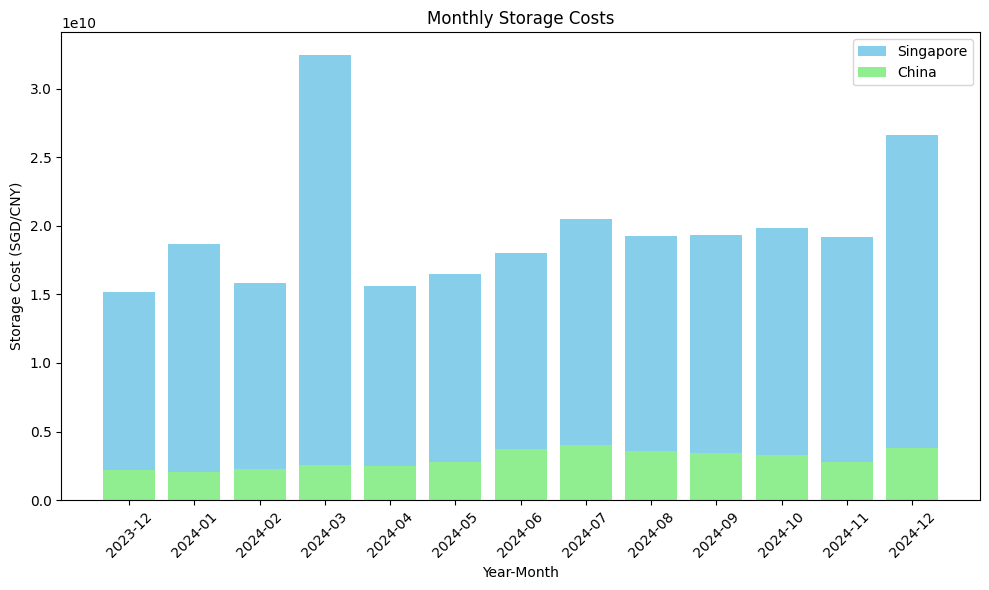

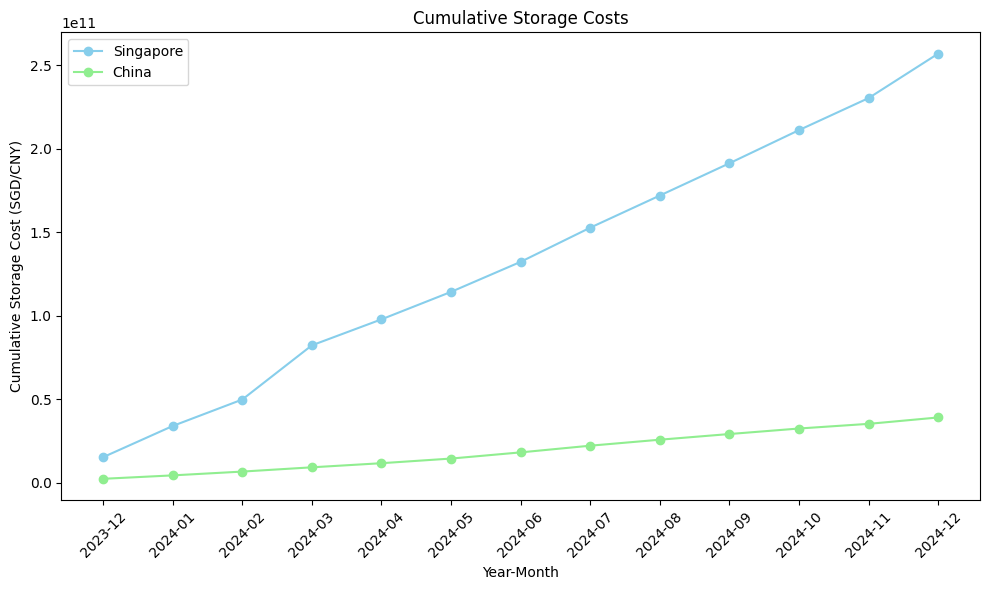

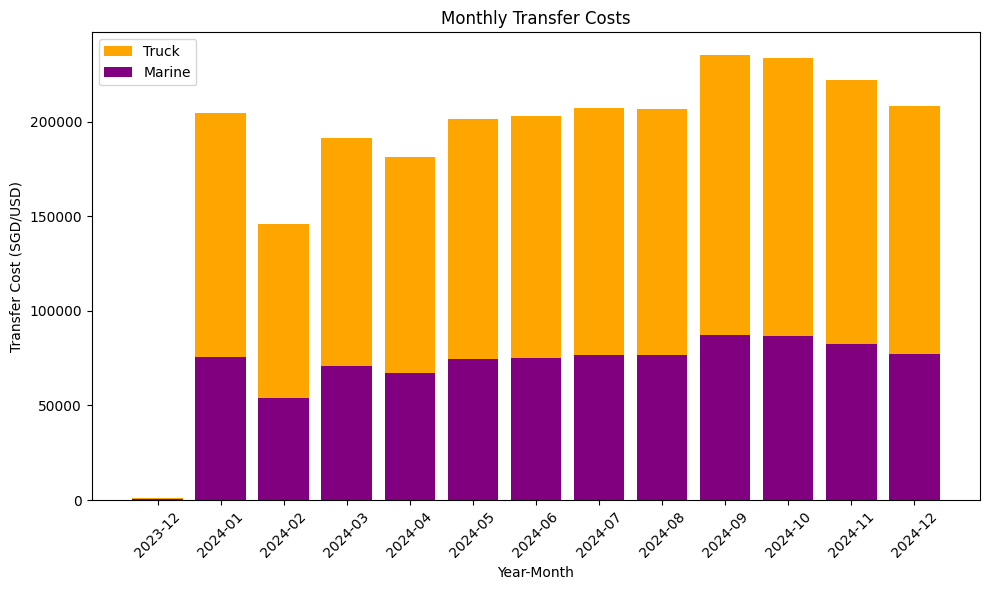

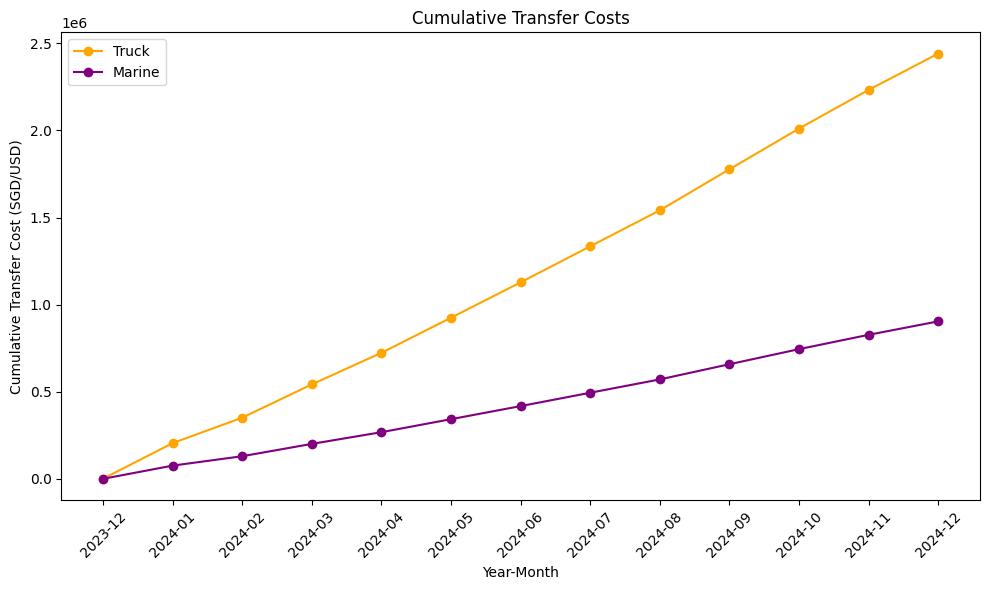

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Redefine the cost rates
COST_STORAGE_SG = 15  # SGD per MT per day
COST_STORAGE_CN = 1.7 # CNY per MT per day
COST_TRUCK_SG = 150  # SGD per container (24.75 MT)
COST_MARINE_USD = 75  # USD per container (24.75 MT)

# Conversion rate (SGD to USD for the calculation)
SGD_TO_USD = 1 / 1.35  # Based on your exchange rate for the demo

# Load data
inventory_data = pd.read_csv('/content/Inventory.csv', parse_dates=['BALANCE_AS_OF_DATE'])
inbound_data = pd.read_csv('/content/Inbound.csv', parse_dates=['INBOUND_DATE'])
outbound_data = pd.read_csv('/content/Outbound.csv', parse_dates=['OUTBOUND_DATE'])


# Clean PLANT_NAME column to ensure consistency
inventory_data['PLANT_NAME'] = inventory_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})
inbound_data['PLANT_NAME'] = inbound_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})
outbound_data['PLANT_NAME'] = outbound_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})

# Initialize the cost calculation variables
monthly_storage_cost = pd.DataFrame(columns=['YearMonth', 'SINGAPORE', 'CHINA'])
monthly_transfer_cost = pd.DataFrame(columns=['YearMonth', 'Truck', 'Marine'])

# Loop through the unique months to calculate costs
for month in inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M').unique():
    # Monthly storage cost (sum of each month's stock × storage cost per day × number of days)
    stock_sg = inventory_data[(inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M') == month) & (inventory_data['PLANT_NAME'] == 'SINGAPORE')]['UNRESRICTED_STOCK'].sum()
    stock_cn = inventory_data[(inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M') == month) & (inventory_data['PLANT_NAME'] == 'CHINA')]['UNRESRICTED_STOCK'].sum()

    days_in_month = calendar.monthrange(month.year, month.month)[1]

    # Calculate storage costs
    storage_sg_cost = stock_sg * COST_STORAGE_SG * days_in_month
    storage_cn_cost = stock_cn * COST_STORAGE_CN * days_in_month

    # Monthly transfer cost (total containers × cost per container)
    outbound_sg = outbound_data[(outbound_data['OUTBOUND_DATE'].dt.to_period('M') == month) & (outbound_data['PLANT_NAME'] == 'SINGAPORE')]
    outbound_cn = outbound_data[(outbound_data['OUTBOUND_DATE'].dt.to_period('M') == month) & (outbound_data['PLANT_NAME'] == 'CHINA')]

    truck_sg_cost = outbound_sg['NET_QUANTITY_MT'].sum() / 24.75 * COST_TRUCK_SG
    marine_sg_cost = outbound_sg['NET_QUANTITY_MT'].sum() / 24.75 * COST_MARINE_USD * SGD_TO_USD
    truck_cn_cost = outbound_cn['NET_QUANTITY_MT'].sum() / 24.75 * COST_TRUCK_SG
    marine_cn_cost = outbound_cn['NET_QUANTITY_MT'].sum() / 24.75 * COST_MARINE_USD * SGD_TO_USD

    # Store the monthly costs
    storage_cost_df = pd.DataFrame({
        'YearMonth': [month], 'SINGAPORE': [storage_sg_cost], 'CHINA': [storage_cn_cost]
    })
    transfer_cost_df = pd.DataFrame({
        'YearMonth': [month], 'Truck': [truck_sg_cost + truck_cn_cost], 'Marine': [marine_sg_cost + marine_cn_cost]
    })

    # Concatenate monthly costs
    monthly_storage_cost = pd.concat([monthly_storage_cost, storage_cost_df], ignore_index=True)
    monthly_transfer_cost = pd.concat([monthly_transfer_cost, transfer_cost_df], ignore_index=True)

# Cumulative costs calculation
monthly_storage_cost['Cumulative_SINGAPORE'] = monthly_storage_cost['SINGAPORE'].cumsum()
monthly_storage_cost['Cumulative_CHINA'] = monthly_storage_cost['CHINA'].cumsum()
monthly_transfer_cost['Cumulative_Truck'] = monthly_transfer_cost['Truck'].cumsum()
monthly_transfer_cost['Cumulative_Marine'] = monthly_transfer_cost['Marine'].cumsum()

# Output the result
print("Monthly Storage Cost Data:")
print(monthly_storage_cost)

print("\nMonthly Transfer Cost Data:")
print(monthly_transfer_cost)

import matplotlib.pyplot as plt

# Plot Monthly Storage Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['SINGAPORE'], color='skyblue', label='Singapore')
ax.bar(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['CHINA'], color='lightgreen', label='China')
ax.set_title('Monthly Storage Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Storage Cost (SGD/CNY)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Cumulative Storage Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Cumulative_SINGAPORE'], marker='o', color='skyblue', label='Singapore')
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Cumulative_CHINA'], marker='o', color='lightgreen', label='China')
ax.set_title('Cumulative Storage Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Cumulative Storage Cost (SGD/CNY)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Monthly Transfer Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Truck'], color='orange', label='Truck')
ax.bar(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Marine'], color='purple', label='Marine')
ax.set_title('Monthly Transfer Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Transfer Cost (SGD/USD)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Cumulative Transfer Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Cumulative_Truck'], marker='o', color='orange', label='Truck')
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Cumulative_Marine'], marker='o', color='purple', label='Marine')
ax.set_title('Cumulative Transfer Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Cumulative Transfer Cost (SGD/USD)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



/tmp/ipython-input-17-52973560.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  monthly_storage_cost = pd.concat([monthly_storage_cost, storage_cost_df], ignore_index=True)
/tmp/ipython-input-17-52973560.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  monthly_transfer_cost = pd.concat([monthly_transfer_cost, transfer_cost_df], ignore_index=True)


Monthly Combined Cost Data:
   YearMonth       Combined_Cost Cumulative_Combined_Cost
0    2023-12   17405747146.72963        17405747146.72963
1    2024-01  20756268909.399662       38162016056.129288
2    2024-02  18141352974.674973        56303369030.80426
3    2024-03  35047708913.250954       91351077944.055206
4    2024-04  18048357691.441078      109399435635.496277
5    2024-05  19258449710.178677      128657885345.674957
6    2024-06  21704961509.127945      150362846854.802917
7    2024-07  24497475213.053646      174860322067.856567
8    2024-08  22855620745.931648      197715942813.788208
9    2024-09  22752530704.719418      220468473518.507629
10   2024-10  23187533683.044106      243656007201.551727
11   2024-11  21993820060.696968      265649827262.248688
12   2024-12  30490647280.535355      296140474542.784058


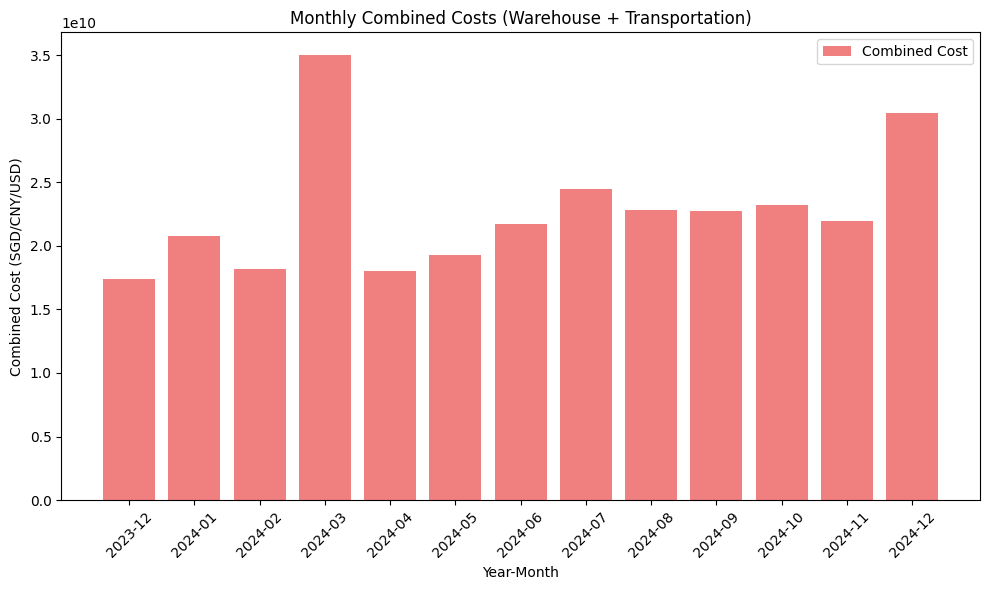

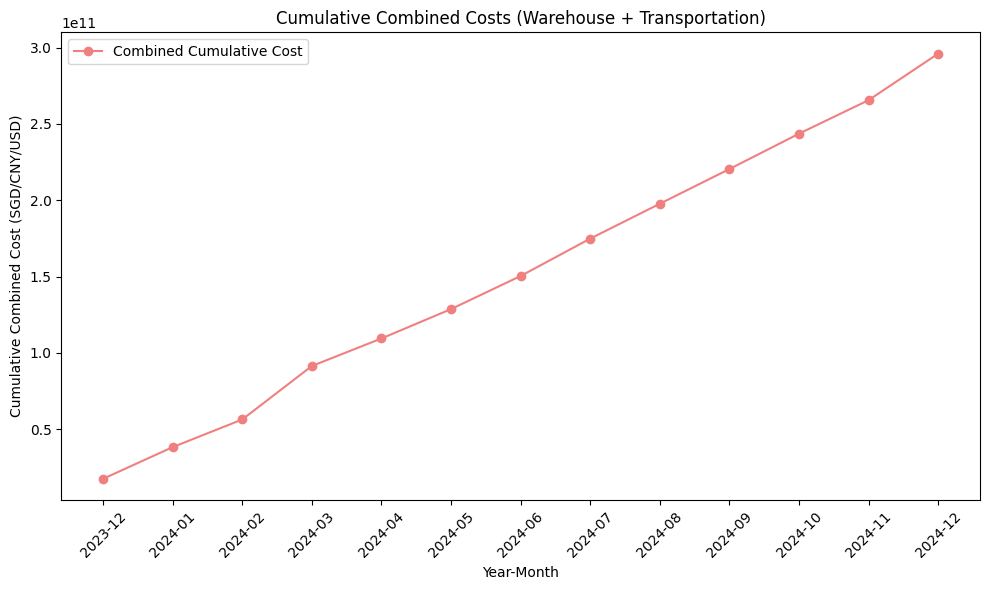

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Redefine the cost rates
COST_STORAGE_SG = 15  # SGD per MT per day
COST_STORAGE_CN = 1.7 # CNY per MT per day
COST_TRUCK_SG = 150  # SGD per container (24.75 MT)
COST_MARINE_USD = 75  # USD per container (24.75 MT)

# Conversion rate (SGD to USD for the calculation)
SGD_TO_USD = 1 / 1.35  # Based on your exchange rate for the demo

# Load data
inventory_data = pd.read_csv('/content/Inventory.csv', parse_dates=['BALANCE_AS_OF_DATE'])
inbound_data = pd.read_csv('/content/Inbound.csv', parse_dates=['INBOUND_DATE'])
outbound_data = pd.read_csv('/content/Outbound.csv', parse_dates=['OUTBOUND_DATE'])

# Clean PLANT_NAME column to ensure consistency
inventory_data['PLANT_NAME'] = inventory_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})
inbound_data['PLANT_NAME'] = inbound_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})
outbound_data['PLANT_NAME'] = outbound_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})

# Initialize the cost calculation variables
monthly_storage_cost = pd.DataFrame(columns=['YearMonth', 'SINGAPORE', 'CHINA'])
monthly_transfer_cost = pd.DataFrame(columns=['YearMonth', 'Truck', 'Marine'])

# Loop through the unique months to calculate costs
for month in inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M').unique():
    # Monthly storage cost (sum of each month's stock × storage cost per day × number of days)
    stock_sg = inventory_data[(inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M') == month) & (inventory_data['PLANT_NAME'] == 'SINGAPORE')]['UNRESRICTED_STOCK'].sum()
    stock_cn = inventory_data[(inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M') == month) & (inventory_data['PLANT_NAME'] == 'CHINA')]['UNRESRICTED_STOCK'].sum()

    days_in_month = calendar.monthrange(month.year, month.month)[1]

    # Calculate storage costs
    storage_sg_cost = stock_sg * COST_STORAGE_SG * days_in_month
    storage_cn_cost = stock_cn * COST_STORAGE_CN * days_in_month

    # Monthly transfer cost (total containers × cost per container)
    outbound_sg = outbound_data[(outbound_data['OUTBOUND_DATE'].dt.to_period('M') == month) & (outbound_data['PLANT_NAME'] == 'SINGAPORE')]
    outbound_cn = outbound_data[(outbound_data['OUTBOUND_DATE'].dt.to_period('M') == month) & (outbound_data['PLANT_NAME'] == 'CHINA')]

    truck_sg_cost = outbound_sg['NET_QUANTITY_MT'].sum() / 24.75 * COST_TRUCK_SG
    marine_sg_cost = outbound_sg['NET_QUANTITY_MT'].sum() / 24.75 * COST_MARINE_USD * SGD_TO_USD
    truck_cn_cost = outbound_cn['NET_QUANTITY_MT'].sum() / 24.75 * COST_TRUCK_SG
    marine_cn_cost = outbound_cn['NET_QUANTITY_MT'].sum() / 24.75 * COST_MARINE_USD * SGD_TO_USD

    # Store the monthly costs
    storage_cost_df = pd.DataFrame({
        'YearMonth': [month], 'SINGAPORE': [storage_sg_cost], 'CHINA': [storage_cn_cost]
    })
    transfer_cost_df = pd.DataFrame({
        'YearMonth': [month], 'Truck': [truck_sg_cost + truck_cn_cost], 'Marine': [marine_sg_cost + marine_cn_cost]
    })

    # Concatenate monthly costs
    monthly_storage_cost = pd.concat([monthly_storage_cost, storage_cost_df], ignore_index=True)
    monthly_transfer_cost = pd.concat([monthly_transfer_cost, transfer_cost_df], ignore_index=True)

# Calculate overall combined warehouse and transportation costs
monthly_storage_cost['Total_Warehouse_Cost'] = monthly_storage_cost['SINGAPORE'] + monthly_storage_cost['CHINA']
monthly_transfer_cost['Total_Transfer_Cost'] = monthly_transfer_cost['Truck'] + monthly_transfer_cost['Marine']

# Combined transportation and warehouse cost
monthly_storage_cost['Combined_Cost'] = monthly_storage_cost['Total_Warehouse_Cost'] + monthly_transfer_cost['Total_Transfer_Cost']

# Cumulative combined cost calculation
monthly_storage_cost['Cumulative_Combined_Cost'] = monthly_storage_cost['Combined_Cost'].cumsum()

# Output the result
print("Monthly Combined Cost Data:")
print(monthly_storage_cost[['YearMonth', 'Combined_Cost', 'Cumulative_Combined_Cost']])

# Plot Monthly Combined Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Combined_Cost'], color='lightcoral', label='Combined Cost')
ax.set_title('Monthly Combined Costs (Warehouse + Transportation)')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Combined Cost (SGD/CNY/USD)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Cumulative Combined Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Cumulative_Combined_Cost'], marker='o', color='lightcoral', label='Combined Cumulative Cost')
ax.set_title('Cumulative Combined Costs (Warehouse + Transportation)')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Cumulative Combined Cost (SGD/CNY/USD)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Define file paths (adjust as needed)
INBOUND_PATH = '/content/Inbound.csv'
OUTBOUND_PATH = '/content/Outbound.csv'
INVENTORY_PATH = '/content/Inventory.csv'
MATERIAL_MASTER_PATH = '/content/MaterialMaster.csv'
OPERATION_COST_PATH = '/content/OperationCost.csv'

# Load the datasets
inbound = pd.read_csv(INBOUND_PATH)
outbound = pd.read_csv(OUTBOUND_PATH)
inventory = pd.read_csv(INVENTORY_PATH)
material_master = pd.read_csv(MATERIAL_MASTER_PATH)
operation_cost = pd.read_csv(OPERATION_COST_PATH)

# 1. Cleaning the Data

# Remove duplicates based on relevant columns (adjust column names accordingly)
inbound = inbound.drop_duplicates(subset=['MATERIAL_NAME', 'INBOUND_DATE'])
outbound = outbound.drop_duplicates(subset=['MATERIAL_NAME', 'OUTBOUND_DATE'])
inventory = inventory.drop_duplicates(subset=['MATERIAL_NAME', 'BALANCE_AS_OF_DATE'])

# Handle missing values
# For example, fill missing numeric values with 0, and missing dates with a default date
inbound.loc[:, 'NET_QUANTITY_MT'] = inbound['NET_QUANTITY_MT'].fillna(0)
outbound.loc[:, 'NET_QUANTITY_MT'] = outbound['NET_QUANTITY_MT'].fillna(0)
inventory.loc[:, 'UNRESRICTED_STOCK'] = inventory['UNRESRICTED_STOCK'].fillna(0)

# For columns with missing dates, fill them with a default date or remove rows (optional)
inbound.loc[:, 'INBOUND_DATE'] = pd.to_datetime(inbound['INBOUND_DATE'], errors='coerce')
outbound.loc[:, 'OUTBOUND_DATE'] = pd.to_datetime(outbound['OUTBOUND_DATE'], errors='coerce')
inventory.loc[:, 'BALANCE_AS_OF_DATE'] = pd.to_datetime(inventory['BALANCE_AS_OF_DATE'], errors='coerce')

# Standardize column names
inbound.columns = inbound.columns.str.strip().str.upper().str.replace(' ', '_')
outbound.columns = outbound.columns.str.strip().str.upper().str.replace(' ', '_')
inventory.columns = inventory.columns.str.strip().str.upper().str.replace(' ', '_')
material_master.columns = material_master.columns.str.strip().str.upper().str.replace(' ', '_')
operation_cost.columns = operation_cost.columns.str.strip().str.upper().str.replace(' ', '_')

# Ensure date columns are in proper datetime format
inbound.loc[:, 'INBOUND_DATE'] = pd.to_datetime(inbound['INBOUND_DATE'])
outbound.loc[:, 'OUTBOUND_DATE'] = pd.to_datetime(outbound['OUTBOUND_DATE'])
inventory.loc[:, 'BALANCE_AS_OF_DATE'] = pd.to_datetime(inventory['BALANCE_AS_OF_DATE'])

# 2. Checking 'Operation Cost' Columns
print("Operation Cost Columns:", operation_cost.columns)

# After checking, the date column in operation_cost might not be 'DATE'. Let's assume it's 'Operation' or another column.

# Join Inventory and Inbound on MATERIAL_NAME and Date
inventory_inbound = pd.merge(inventory, inbound, how='left', left_on=['MATERIAL_NAME', 'BALANCE_AS_OF_DATE'], right_on=['MATERIAL_NAME', 'INBOUND_DATE'])

# Join Inbound and Outbound on MATERIAL_NAME
inbound_outbound = pd.merge(inbound, outbound, how='left', on='MATERIAL_NAME')

# Adjusting the join on Operation Cost based on inspection:
# Assuming the date column in operation_cost is 'Operation' (adjust this based on the actual column name found)
inventory_operation_cost = pd.merge(inventory, operation_cost, how='left', left_on='BALANCE_AS_OF_DATE', right_on='OPERATION')

# Join Material Master and Inventory on MATERIAL_NAME
inventory_material = pd.merge(inventory, material_master, how='left', on='MATERIAL_NAME')

# Save the cleaned and joined data to CSV
inventory_inbound.to_csv('/content/cleaned_inventory_inbound.csv', index=False)
inbound_outbound.to_csv('/content/cleaned_inbound_outbound.csv', index=False)
inventory_operation_cost.to_csv('/content/cleaned_inventory_operation_cost.csv', index=False)
inventory_material.to_csv('/content/cleaned_inventory_material.csv', index=False)

# Output paths for reference
print("Files saved to:")
print("/content/cleaned_inventory_inbound.csv")
print("/content/cleaned_inbound_outbound.csv")
print("/content/cleaned_inventory_operation_cost.csv")
print("/content/cleaned_inventory_material.csv")


Operation Cost Columns: Index(['OPERATION', 'PLANT/MODE_OF_TRANSPORT', 'COST', 'CURRENCY'], dtype='object')
Files saved to:
/content/cleaned_inventory_inbound.csv
/content/cleaned_inbound_outbound.csv
/content/cleaned_inventory_operation_cost.csv
/content/cleaned_inventory_material.csv


/tmp/ipython-input-2-3662432898.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  monthly_storage_cost = pd.concat([monthly_storage_cost, storage_cost_df], ignore_index=True)
/tmp/ipython-input-2-3662432898.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  monthly_transfer_cost = pd.concat([monthly_transfer_cost, transfer_cost_df], ignore_index=True)


Monthly Storage Cost Data:
   YearMonth    SINGAPORE         CHINA  Avg_SINGAPORE  Avg_CHINA  \
0    2023-12  15180215625  2.225530e+09          465.0       52.7   
1    2024-01  18699440250  2.056549e+09          465.0       52.7   
2    2024-02  15862623000  2.278530e+09          435.0       49.3   
3    2024-03  32492619000  2.554828e+09          465.0       52.7   
4    2024-04  15578943750  2.469166e+09          450.0       51.0   
5    2024-05  16474217625  2.783956e+09          465.0       52.7   
6    2024-06  18004747500  3.699936e+09          450.0       51.0   
7    2024-07  20484238125  4.012953e+09          465.0       52.7   
8    2024-08  19264429200  3.590909e+09          465.0       52.7   
9    2024-09  19350438300  3.401770e+09          450.0       51.0   
10   2024-10  19878424500  3.308789e+09          465.0       52.7   
11   2024-11  19200521250  2.792994e+09          450.0       51.0   
12   2024-12  26660275125  3.830087e+09          465.0       52.7   

   Cum

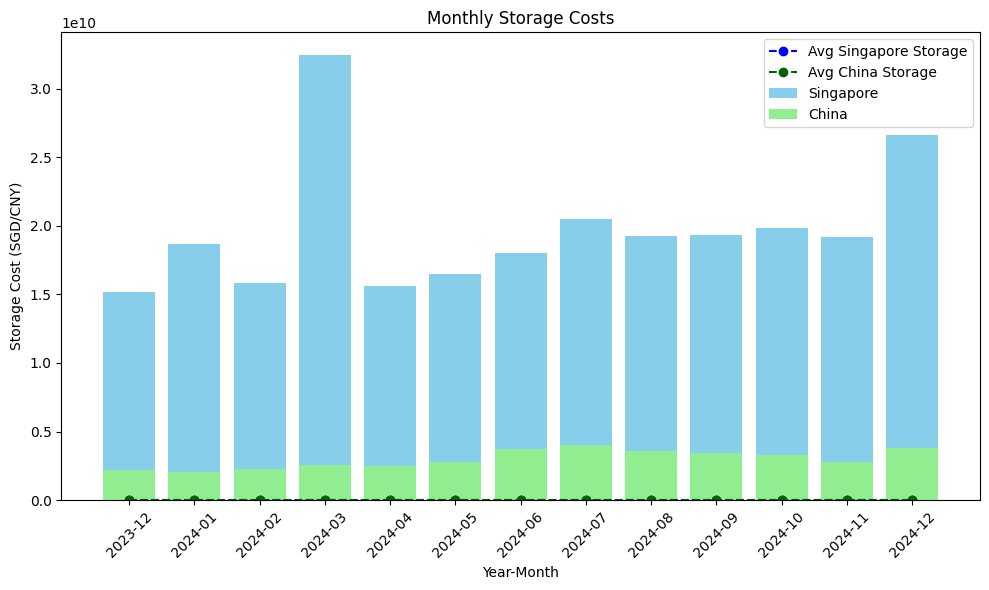

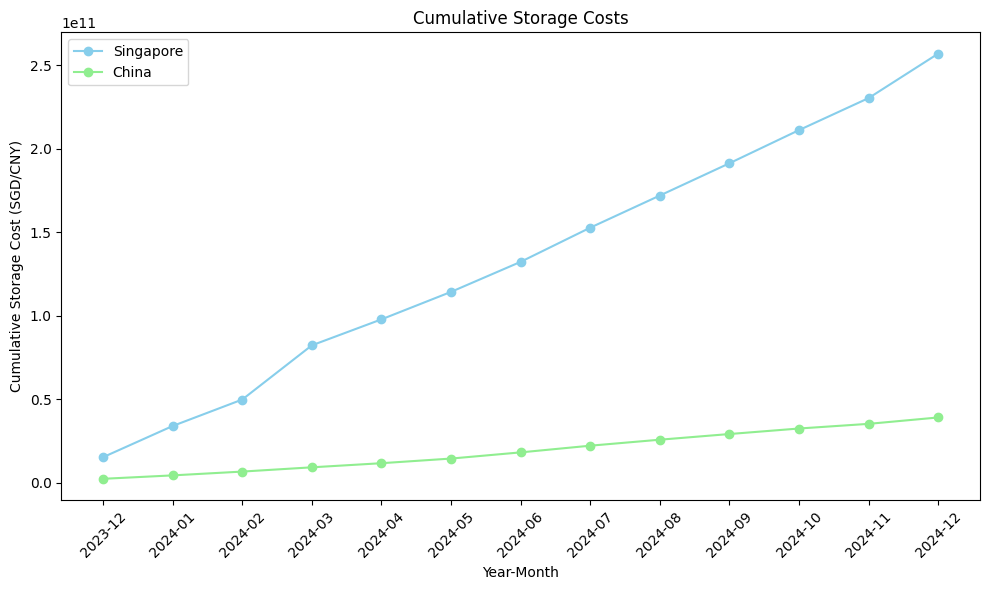

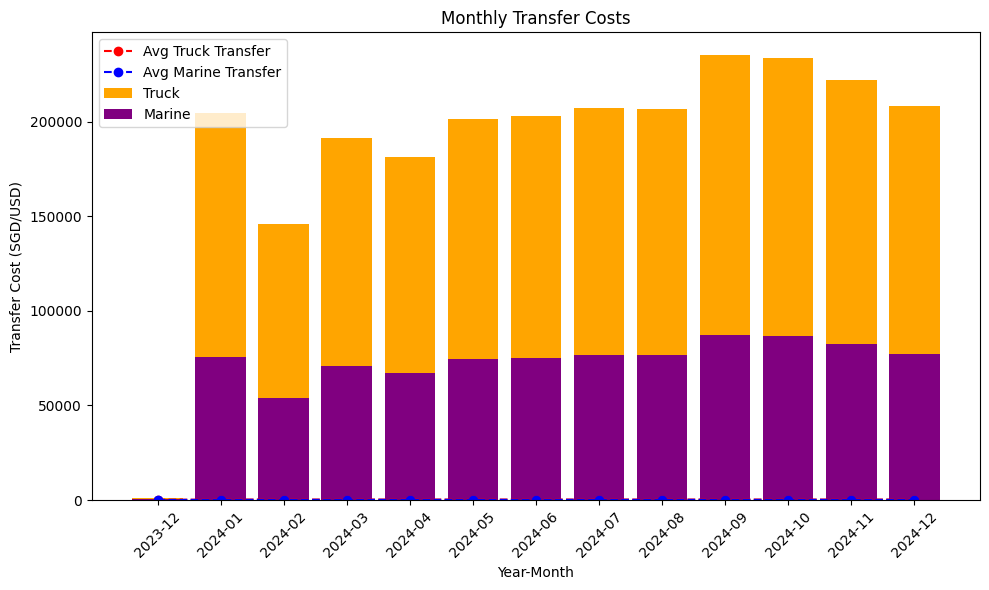

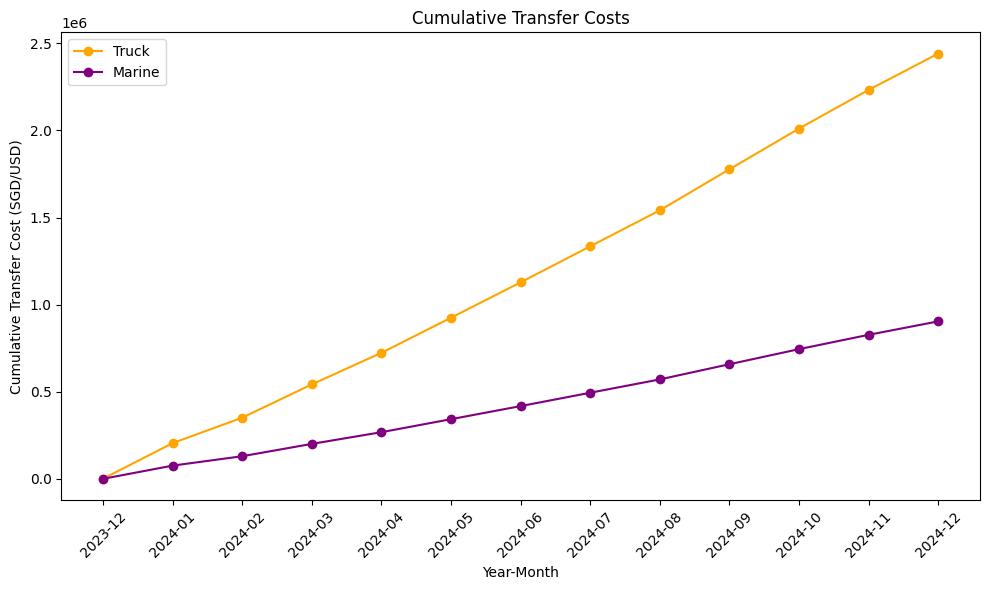

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Redefine the cost rates
COST_STORAGE_SG = 15  # SGD per MT per day
COST_STORAGE_CN = 1.7 # CNY per MT per day
COST_TRUCK_SG = 150  # SGD per container (24.75 MT)
COST_MARINE_USD = 75  # USD per container (24.75 MT)

# Conversion rate (SGD to USD for the calculation)
SGD_TO_USD = 1 / 1.35  # Based on your exchange rate for the demo

# Load data
inventory_data = pd.read_csv('/content/Inventory.csv', parse_dates=['BALANCE_AS_OF_DATE'])
inbound_data = pd.read_csv('/content/Inbound.csv', parse_dates=['INBOUND_DATE'])
outbound_data = pd.read_csv('/content/Outbound.csv', parse_dates=['OUTBOUND_DATE'])


# Clean PLANT_NAME column to ensure consistency
inventory_data['PLANT_NAME'] = inventory_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})
inbound_data['PLANT_NAME'] = inbound_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})
outbound_data['PLANT_NAME'] = outbound_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})

# Initialize the cost calculation variables
monthly_storage_cost = pd.DataFrame(columns=['YearMonth', 'SINGAPORE', 'CHINA', 'Avg_SINGAPORE', 'Avg_CHINA'])
monthly_transfer_cost = pd.DataFrame(columns=['YearMonth', 'Truck', 'Marine', 'Avg_Truck', 'Avg_Marine'])

# Loop through the unique months to calculate costs
for month in inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M').unique():
    # Monthly storage cost (sum of each month's stock × storage cost per day × number of days)
    stock_sg = inventory_data[(inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M') == month) & (inventory_data['PLANT_NAME'] == 'SINGAPORE')]['UNRESRICTED_STOCK'].sum()
    stock_cn = inventory_data[(inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M') == month) & (inventory_data['PLANT_NAME'] == 'CHINA')]['UNRESRICTED_STOCK'].sum()

    days_in_month = calendar.monthrange(month.year, month.month)[1]

    # Calculate storage costs
    storage_sg_cost = stock_sg * COST_STORAGE_SG * days_in_month
    storage_cn_cost = stock_cn * COST_STORAGE_CN * days_in_month

    # Monthly transfer cost (total containers × cost per container)
    outbound_sg = outbound_data[(outbound_data['OUTBOUND_DATE'].dt.to_period('M') == month) & (outbound_data['PLANT_NAME'] == 'SINGAPORE')]
    outbound_cn = outbound_data[(outbound_data['OUTBOUND_DATE'].dt.to_period('M') == month) & (outbound_data['PLANT_NAME'] == 'CHINA')]

    truck_sg_cost = outbound_sg['NET_QUANTITY_MT'].sum() / 24.75 * COST_TRUCK_SG
    marine_sg_cost = outbound_sg['NET_QUANTITY_MT'].sum() / 24.75 * COST_MARINE_USD * SGD_TO_USD
    truck_cn_cost = outbound_cn['NET_QUANTITY_MT'].sum() / 24.75 * COST_TRUCK_SG
    marine_cn_cost = outbound_cn['NET_QUANTITY_MT'].sum() / 24.75 * COST_MARINE_USD * SGD_TO_USD

    # Calculate averages for each month
    avg_storage_sg = storage_sg_cost / stock_sg if stock_sg > 0 else 0
    avg_storage_cn = storage_cn_cost / stock_cn if stock_cn > 0 else 0

    avg_truck_sg = truck_sg_cost / (outbound_sg['NET_QUANTITY_MT'].sum() / 24.75) if len(outbound_sg) > 0 else 0
    avg_truck_cn = truck_cn_cost / (outbound_cn['NET_QUANTITY_MT'].sum() / 24.75) if len(outbound_cn) > 0 else 0

    avg_marine_sg = marine_sg_cost / (outbound_sg['NET_QUANTITY_MT'].sum() / 24.75) if len(outbound_sg) > 0 else 0
    avg_marine_cn = marine_cn_cost / (outbound_cn['NET_QUANTITY_MT'].sum() / 24.75) if len(outbound_cn) > 0 else 0

    # Store the monthly costs
    storage_cost_df = pd.DataFrame({
        'YearMonth': [month], 'SINGAPORE': [storage_sg_cost], 'CHINA': [storage_cn_cost],
        'Avg_SINGAPORE': [avg_storage_sg], 'Avg_CHINA': [avg_storage_cn]
    })
    transfer_cost_df = pd.DataFrame({
        'YearMonth': [month], 'Truck': [truck_sg_cost + truck_cn_cost], 'Marine': [marine_sg_cost + marine_cn_cost],
        'Avg_Truck': [avg_truck_sg + avg_truck_cn], 'Avg_Marine': [avg_marine_sg + avg_marine_cn]
    })

    # Concatenate monthly costs
    monthly_storage_cost = pd.concat([monthly_storage_cost, storage_cost_df], ignore_index=True)
    monthly_transfer_cost = pd.concat([monthly_transfer_cost, transfer_cost_df], ignore_index=True)

# Cumulative costs calculation
monthly_storage_cost['Cumulative_SINGAPORE'] = monthly_storage_cost['SINGAPORE'].cumsum()
monthly_storage_cost['Cumulative_CHINA'] = monthly_storage_cost['CHINA'].cumsum()
monthly_transfer_cost['Cumulative_Truck'] = monthly_transfer_cost['Truck'].cumsum()
monthly_transfer_cost['Cumulative_Marine'] = monthly_transfer_cost['Marine'].cumsum()

# Output the result
print("Monthly Storage Cost Data:")
print(monthly_storage_cost)

print("\nMonthly Transfer Cost Data:")
print(monthly_transfer_cost)

# Plot Monthly Storage Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['SINGAPORE'], color='skyblue', label='Singapore')
ax.bar(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['CHINA'], color='lightgreen', label='China')
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Avg_SINGAPORE'], color='blue', label='Avg Singapore Storage', linestyle='--', marker='o')
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Avg_CHINA'], color='darkgreen', label='Avg China Storage', linestyle='--', marker='o')
ax.set_title('Monthly Storage Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Storage Cost (SGD/CNY)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Cumulative Storage Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Cumulative_SINGAPORE'], marker='o', color='skyblue', label='Singapore')
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Cumulative_CHINA'], marker='o', color='lightgreen', label='China')
ax.set_title('Cumulative Storage Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Cumulative Storage Cost (SGD/CNY)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Monthly Transfer Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Truck'], color='orange', label='Truck')
ax.bar(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Marine'], color='purple', label='Marine')
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Avg_Truck'], color='red', label='Avg Truck Transfer', linestyle='--', marker='o')
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Avg_Marine'], color='blue', label='Avg Marine Transfer', linestyle='--', marker='o')
ax.set_title('Monthly Transfer Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Transfer Cost (SGD/USD)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Cumulative Transfer Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Cumulative_Truck'], marker='o', color='orange', label='Truck')
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Cumulative_Marine'], marker='o', color='purple', label='Marine')
ax.set_title('Cumulative Transfer Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Cumulative Transfer Cost (SGD/USD)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Redefine the cost rates (converted to THB)
COST_STORAGE_SG = 15 * 25.45  # SGD per MT per day to THB
COST_STORAGE_CN = 1.7 * 4.52  # CNY per MT per day to THB
COST_TRUCK_SG = 150 * 25.45  # SGD per container (24.75 MT) to THB
COST_MARINE_USD = 75 * 32.43  # USD per container (24.75 MT) to THB

# Conversion rate (SGD to THB, CNY to THB, USD to THB)
SGD_TO_THAI = 25.45  # Conversion rate: SGD to THB
CNY_TO_THAI = 4.52   # Conversion rate: CNY to THB
USD_TO_THAI = 32.43  # Conversion rate: USD to THB

# Load data
inventory_data = pd.read_csv('/content/Inventory.csv', parse_dates=['BALANCE_AS_OF_DATE'])
inbound_data = pd.read_csv('/content/Inbound.csv', parse_dates=['INBOUND_DATE'])
outbound_data = pd.read_csv('/content/Outbound.csv', parse_dates=['OUTBOUND_DATE'])

# Clean PLANT_NAME column to ensure consistency
inventory_data['PLANT_NAME'] = inventory_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})
inbound_data['PLANT_NAME'] = inbound_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})
outbound_data['PLANT_NAME'] = outbound_data['PLANT_NAME'].replace({'CHINA-WAREHOUSE': 'CHINA', 'SINGAPORE-WAREHOUSE': 'SINGAPORE'})

# Initialize the cost calculation variables
monthly_storage_cost = pd.DataFrame(columns=['YearMonth', 'SINGAPORE', 'CHINA', 'Avg_SINGAPORE', 'Avg_CHINA'])
monthly_transfer_cost = pd.DataFrame(columns=['YearMonth', 'Truck', 'Marine', 'Avg_Truck', 'Avg_Marine'])

# Loop through the unique months to calculate costs
for month in inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M').unique():
  print(BALANCE_AS_OF_DATE)
    # Monthly storage cost (sum of each month's stock × storage cost per day × number of days)
    stock_sg = inventory_data[(inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M') == month) & (inventory_data['PLANT_NAME'] == 'SINGAPORE')]['UNRESRICTED_STOCK'].sum()
    stock_cn = inventory_data[(inventory_data['BALANCE_AS_OF_DATE'].dt.to_period('M') == month) & (inventory_data['PLANT_NAME'] == 'CHINA')]['UNRESRICTED_STOCK'].sum()

    days_in_month = calendar.monthrange(month.year, month.month)[1]

    # Calculate storage costs in THB
    storage_sg_cost = stock_sg * COST_STORAGE_SG * days_in_month
    storage_cn_cost = stock_cn * COST_STORAGE_CN * days_in_month

    # Monthly transfer cost (total containers × cost per container)
    outbound_sg = outbound_data[(outbound_data['OUTBOUND_DATE'].dt.to_period('M') == month) & (outbound_data['PLANT_NAME'] == 'SINGAPORE')]
    outbound_cn = outbound_data[(outbound_data['OUTBOUND_DATE'].dt.to_period('M') == month) & (outbound_data['PLANT_NAME'] == 'CHINA')]

    truck_sg_cost = outbound_sg['NET_QUANTITY_MT'].sum() / 24.75 * COST_TRUCK_SG
    marine_sg_cost = outbound_sg['NET_QUANTITY_MT'].sum() / 24.75 * COST_MARINE_USD
    truck_cn_cost = outbound_cn['NET_QUANTITY_MT'].sum() / 24.75 * COST_TRUCK_SG
    marine_cn_cost = outbound_cn['NET_QUANTITY_MT'].sum() / 24.75 * COST_MARINE_USD

    # Calculate averages for each month in THB
    avg_storage_sg = storage_sg_cost / stock_sg if stock_sg > 0 else 0
    avg_storage_cn = storage_cn_cost / stock_cn if stock_cn > 0 else 0

    avg_truck_sg = truck_sg_cost / (outbound_sg['NET_QUANTITY_MT'].sum() / 24.75) if len(outbound_sg) > 0 else 0
    avg_truck_cn = truck_cn_cost / (outbound_cn['NET_QUANTITY_MT'].sum() / 24.75) if len(outbound_cn) > 0 else 0

    avg_marine_sg = marine_sg_cost / (outbound_sg['NET_QUANTITY_MT'].sum() / 24.75) if len(outbound_sg) > 0 else 0
    avg_marine_cn = marine_cn_cost / (outbound_cn['NET_QUANTITY_MT'].sum() / 24.75) if len(outbound_cn) > 0 else 0

    # Store the monthly costs
    storage_cost_df = pd.DataFrame({
        'YearMonth': [month], 'SINGAPORE': [storage_sg_cost], 'CHINA': [storage_cn_cost],
        'Avg_SINGAPORE': [avg_storage_sg], 'Avg_CHINA': [avg_storage_cn]
    })
    transfer_cost_df = pd.DataFrame({
        'YearMonth': [month], 'Truck': [truck_sg_cost + truck_cn_cost], 'Marine': [marine_sg_cost + marine_cn_cost],
        'Avg_Truck': [avg_truck_sg + avg_truck_cn], 'Avg_Marine': [avg_marine_sg + avg_marine_cn]
    })

    # Concatenate monthly costs
    monthly_storage_cost = pd.concat([monthly_storage_cost, storage_cost_df], ignore_index=True)
    monthly_transfer_cost = pd.concat([monthly_transfer_cost, transfer_cost_df], ignore_index=True)

# Cumulative costs calculation
monthly_storage_cost['Cumulative_SINGAPORE (THB)'] = monthly_storage_cost['SINGAPORE'].cumsum()
monthly_storage_cost['Cumulative_CHINA (THB)'] = monthly_storage_cost['CHINA'].cumsum()
monthly_transfer_cost['Cumulative_Truck (THB)'] = monthly_transfer_cost['Truck'].cumsum()
monthly_transfer_cost['Cumulative_Marine (THB)'] = monthly_transfer_cost['Marine'].cumsum()

# Output the result
print("Monthly Storage Cost Data:")
print(monthly_storage_cost)

print("\nMonthly Transfer Cost Data:")
print(monthly_transfer_cost)

# Plot Monthly Storage Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['SINGAPORE'], color='skyblue', label='Singapore')
ax.bar(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['CHINA'], color='lightgreen', label='China')
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Avg_SINGAPORE'], color='blue', label='Avg Singapore Storage', linestyle='--', marker='o')
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Avg_CHINA'], color='darkgreen', label='Avg China Storage', linestyle='--', marker='o')
ax.set_title('Monthly Storage Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Storage Cost (THB)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Cumulative Storage Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Cumulative_SINGAPORE (THB)'], marker='o', color='skyblue', label='Singapore')
ax.plot(monthly_storage_cost['YearMonth'].astype(str), monthly_storage_cost['Cumulative_CHINA (THB)'], marker='o', color='lightgreen', label='China')
ax.set_title('Cumulative Storage Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Cumulative Storage Cost (THB)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Monthly Transfer Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Truck'], color='orange', label='Truck')
ax.bar(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Marine'], color='purple', label='Marine')
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Avg_Truck'], color='red', label='Avg Truck Transfer', linestyle='--', marker='o')
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Avg_Marine'], color='blue', label='Avg Marine Transfer', linestyle='--', marker='o')
ax.set_title('Monthly Transfer Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Transfer Cost (THB)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Plot Cumulative Transfer Costs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Cumulative_Truck (THB)'], marker='o', color='orange', label='Truck')
ax.plot(monthly_transfer_cost['YearMonth'].astype(str), monthly_transfer_cost['Cumulative_Marine (THB)'], marker='o', color='purple', label='Marine')
ax.set_title('Cumulative Transfer Costs')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Cumulative Transfer Cost (THB)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


IndentationError: unexpected indent (ipython-input-9-1772722641.py, line 35)

/tmp/ipython-input-30-493222585.py:83: RuntimeWarning: invalid value encountered in scalar divide
  avg_cost_per_mt = total_month_cost / total_inventory


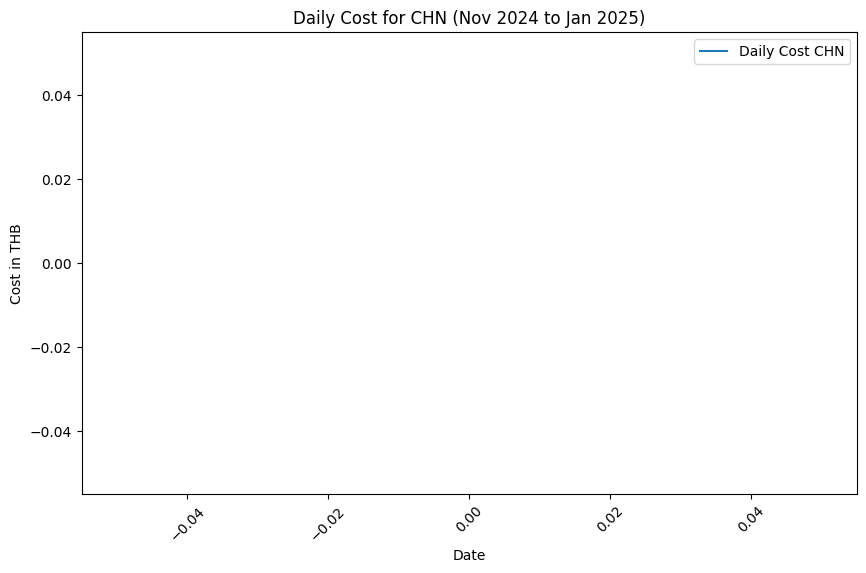

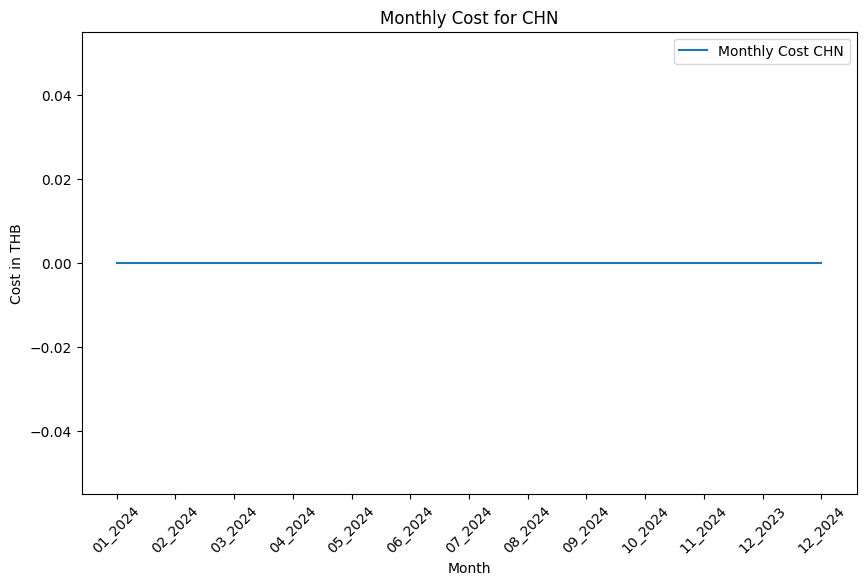

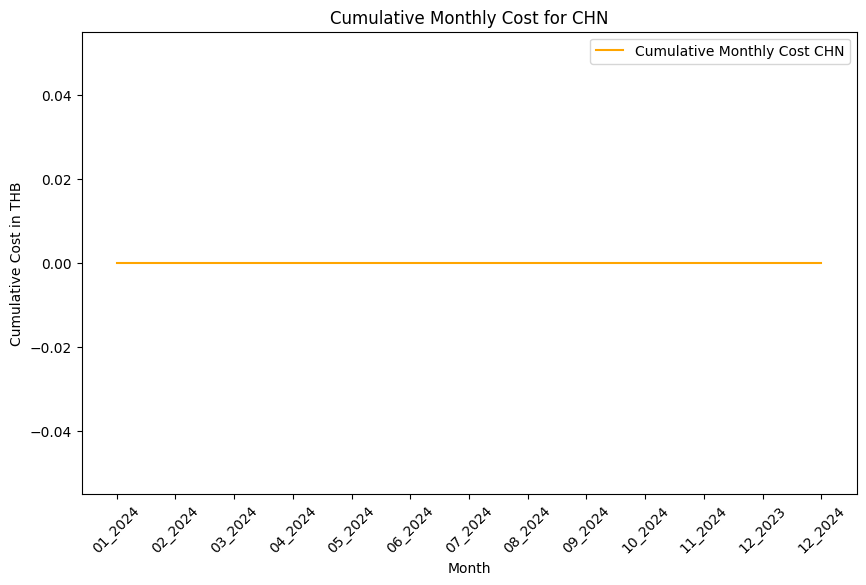

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from your directory (adjust path if necessary)
inventory_data = pd.read_csv('Inventory.csv', parse_dates=['BALANCE_AS_OF_DATE'])  # Corrected path for local environment
inbound_data = pd.read_csv('Inbound.csv', parse_dates=['INBOUND_DATE'])  # Corrected path for local environment
outbound_data = pd.read_csv('Outbound.csv', parse_dates=['OUTBOUND_DATE'])  # Corrected path for local environment

# Constants
SGD_TO_THAI = 25.45  # Conversion rate: SGD to THB
CNY_TO_THAI = 4.52   # Conversion rate: CNY to THB
USD_TO_THAI = 32.43  # Conversion rate: USD to THB
COST_STORAGE_SG = 15  # SGD per MT per day
COST_STORAGE_CN = 1.7 # CNY per MT per day

# Helper functions
def kg_to_mt(kg):
    return kg / 1000

# Inbound processing: Sum by PLANT_NAME and Day
inbound_data['DATE'] = inbound_data['INBOUND_DATE'].dt.strftime('%d_%m_%Y')
inbound_daily = inbound_data.groupby(['PLANT_NAME', 'DATE'])['NET_QUANTITY_MT'].sum().reset_index()

# Outbound processing: Sum by PLANT_NAME and Day
outbound_data['DATE'] = outbound_data['OUTBOUND_DATE'].dt.strftime('%d_%m_%Y')
outbound_daily = outbound_data.groupby(['PLANT_NAME', 'DATE'])['NET_QUANTITY_MT'].sum().reset_index()

# Inventory processing: Convert KG to MT, and sum by PLANT_NAME and Month
inventory_data['MONTH'] = inventory_data['BALANCE_AS_OF_DATE'].dt.strftime('%m_%Y')
inventory_data['UNRESTRICTED_STOCK_MT'] = inventory_data['UNRESRICTED_STOCK'] / 1000  # Convert KG to MT
inventory_monthly = inventory_data.groupby(['PLANT_NAME', 'MONTH'])['UNRESTRICTED_STOCK_MT'].sum().reset_index()

# Initialize results dictionary for storing daily costs and inventory
results = {}

# Step 4: Calculate Daily Costs (Using inventory from the previous month for the first day of the new month)
for plant in inbound_daily['PLANT_NAME'].unique():
    last_left_stock = 0  # Start with an initial value

    for date in inbound_daily['DATE'].unique():
        # Get inbound and outbound values for the specific date (use 0 if not found)
        inbound_value = inbound_daily[(inbound_daily['PLANT_NAME'] == plant) & (inbound_daily['DATE'] == date)]['NET_QUANTITY_MT'].sum()
        if inbound_value == 0:  # If no inbound data for the date, set to 0
            inbound_value = 0

        outbound_value = outbound_daily[(outbound_daily['PLANT_NAME'] == plant) & (outbound_daily['DATE'] == date)]['NET_QUANTITY_MT'].sum()
        if outbound_value == 0:  # If no outbound data for the date, set to 0
            outbound_value = 0

        # Find the closest available inventory date (previous month's end)
        inventory_date = (pd.to_datetime(date, format='%d_%m_%Y') - pd.DateOffset(days=1)).strftime('%m_%Y')  # Previous month
        inventory_value = inventory_monthly[(inventory_monthly['PLANT_NAME'] == plant) & (inventory_monthly['MONTH'] == inventory_date)]['UNRESTRICTED_STOCK_MT'].sum()

        # For the first day of the month, use the inventory from the previous month
        if last_left_stock == 0:
            last_left_stock = inventory_value + inbound_value - outbound_value
        else:
            last_left_stock += inbound_value - outbound_value

        # Store the calculated last_left_stock in results
        results[f'LAST_LEFT_{plant}_{date}'] = last_left_stock

        # Calculate daily cost in THB for Singapore and China
        if plant == 'SG':
            day_cost_sg = last_left_stock * COST_STORAGE_SG * SGD_TO_THAI
            results[f'DAY_COST_{plant}_{date}'] = day_cost_sg
        elif plant == 'CHN':
            day_cost_chn = last_left_stock * COST_STORAGE_CN * CNY_TO_THAI
            results[f'DAY_COST_{plant}_{date}'] = day_cost_chn

# Step 5: Calculate Monthly Costs and Average THB/MT
monthly_costs = {}
for plant in ['SG', 'CHN']:
    for month in inventory_monthly['MONTH'].unique():
        # Sum daily costs for the entire month
        daily_costs = [results.get(f'DAY_COST_{plant}_{date}') for date in results if f'{plant}_{month}' in date]
        total_month_cost = sum(daily_costs)

        # Sum the inventory for the month (in MT)
        total_inventory = inventory_monthly[(inventory_monthly['PLANT_NAME'] == plant) & (inventory_monthly['MONTH'] == month)]['UNRESTRICTED_STOCK_MT'].sum()

        # Calculate average cost per MT for the month
        avg_cost_per_mt = total_month_cost / total_inventory
        monthly_costs[f'MONTH_COST_{plant}_{month}'] = total_month_cost
        monthly_costs[f'AVG_COST_{plant}_{month}'] = avg_cost_per_mt

# Step 6: Plotting
# 5.1 Plot Daily Costs for CHN from November 2024 to January 2025
daily_cost_chn_data = [results[f'DAY_COST_CHN_{date}'] for date in results if 'CHN' in date]
dates = [date for date in results if 'CHN' in date]
plt.figure(figsize=(10, 6))
plt.plot(dates, daily_cost_chn_data, label='Daily Cost CHN')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cost in THB')
plt.title('Daily Cost for CHN (Nov 2024 to Jan 2025)')
plt.legend()
plt.show()

# 5.2 Plot Monthly Costs for CHN
monthly_cost_chn_data = [monthly_costs.get(f'MONTH_COST_CHN_{month}', 0) for month in inventory_monthly['MONTH'].unique()]
months = [month for month in inventory_monthly['MONTH'].unique()]
plt.figure(figsize=(10, 6))
plt.plot(months, monthly_cost_chn_data, label='Monthly Cost CHN')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Cost in THB')
plt.title('Monthly Cost for CHN')
plt.legend()
plt.show()

# 5.3 Cumulative Monthly Costs
cumulative_costs = [sum(monthly_cost_chn_data[:i+1]) for i in range(len(monthly_cost_chn_data))]
plt.figure(figsize=(10, 6))
plt.plot(months, cumulative_costs, label='Cumulative Monthly Cost CHN', color='orange')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Cumulative Cost in THB')
plt.title('Cumulative Monthly Cost for CHN')
plt.legend()
plt.show()


In [ ]:
# Loop to print the daily costs for CHN on each date (e.g., 01_02_2024, 02_02_2024, etc.)
for day in range(1, 32):  # Looping through days 1 to 31
    date_str = f"0{day}" if day < 10 else str(day)  # Format day with leading zero if necessary
    date_key = f'DAY_COST_CHN_{date_str}_05_2024'  # Replace with the actual date you want
    if date_key in results:
        print(f"{date_key}: {results[date_key]}")
    else:
        print(f"{date_key}: No data for this date")


DAY_COST_CHN_01_05_2024: No data for this date
DAY_COST_CHN_02_05_2024: No data for this date
DAY_COST_CHN_03_05_2024: No data for this date
DAY_COST_CHN_04_05_2024: No data for this date
DAY_COST_CHN_05_05_2024: No data for this date
DAY_COST_CHN_06_05_2024: No data for this date
DAY_COST_CHN_07_05_2024: No data for this date
DAY_COST_CHN_08_05_2024: No data for this date
DAY_COST_CHN_09_05_2024: No data for this date
DAY_COST_CHN_10_05_2024: No data for this date
DAY_COST_CHN_11_05_2024: No data for this date
DAY_COST_CHN_12_05_2024: No data for this date
DAY_COST_CHN_13_05_2024: No data for this date
DAY_COST_CHN_14_05_2024: No data for this date
DAY_COST_CHN_15_05_2024: No data for this date
DAY_COST_CHN_16_05_2024: No data for this date
DAY_COST_CHN_17_05_2024: No data for this date
DAY_COST_CHN_18_05_2024: No data for this date
DAY_COST_CHN_19_05_2024: No data for this date
DAY_COST_CHN_20_05_2024: No data for this date
DAY_COST_CHN_21_05_2024: No data for this date
DAY_COST_CHN_


Data for CHINA-WAREHOUSE on 01_02_2024:
Inbound Value: 442.75 MT
Outbound Value: 948.22 MT
Inventory Value (previous month's end): 39023.693 MT
Last Left Stock: 38518.223 MT
Daily Cost for CHINA-WAREHOUSE on 01_02_2024: No cost calculated THB

Data for CHINA-WAREHOUSE on 01_03_2024:
Inbound Value: 582.0 MT
Outbound Value: 680.16 MT
Inventory Value (previous month's end): 46217.648 MT
Last Left Stock: 38420.062999999995 MT
Daily Cost for CHINA-WAREHOUSE on 01_03_2024: No cost calculated THB

Data for CHINA-WAREHOUSE on 01_05_2024:
Inbound Value: 931.5 MT
Outbound Value: 0 MT
Inventory Value (previous month's end): 48415.015 MT
Last Left Stock: 39351.562999999995 MT
Daily Cost for CHINA-WAREHOUSE on 01_05_2024: No cost calculated THB

Data for CHINA-WAREHOUSE on 01_06_2024:
Inbound Value: 477.75 MT
Outbound Value: 696.0 MT
Inventory Value (previous month's end): 52826.486 MT
Last Left Stock: 39133.312999999995 MT
Daily Cost for CHINA-WAREHOUSE on 01_06_2024: No cost calculated THB

Data

/tmp/ipython-input-44-1189465143.py:95: RuntimeWarning: invalid value encountered in scalar divide
  avg_cost_per_mt = total_month_cost / total_inventory


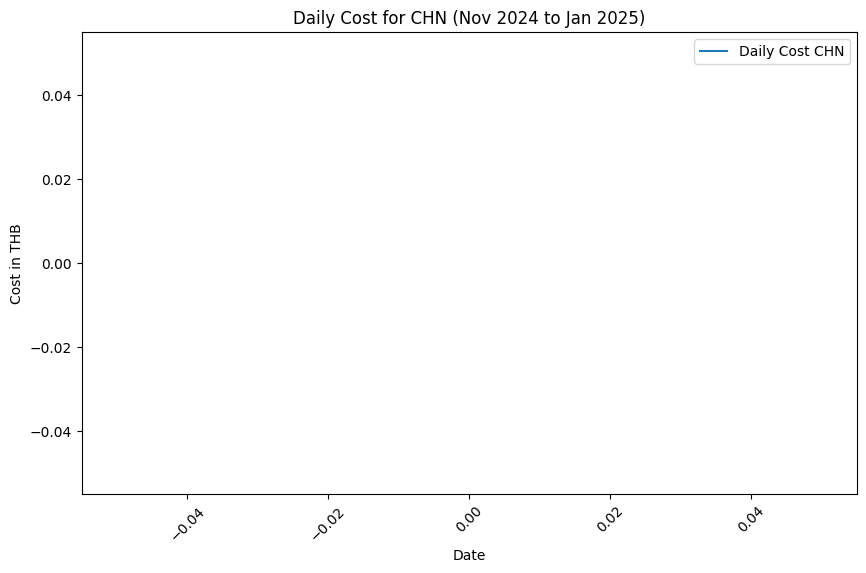

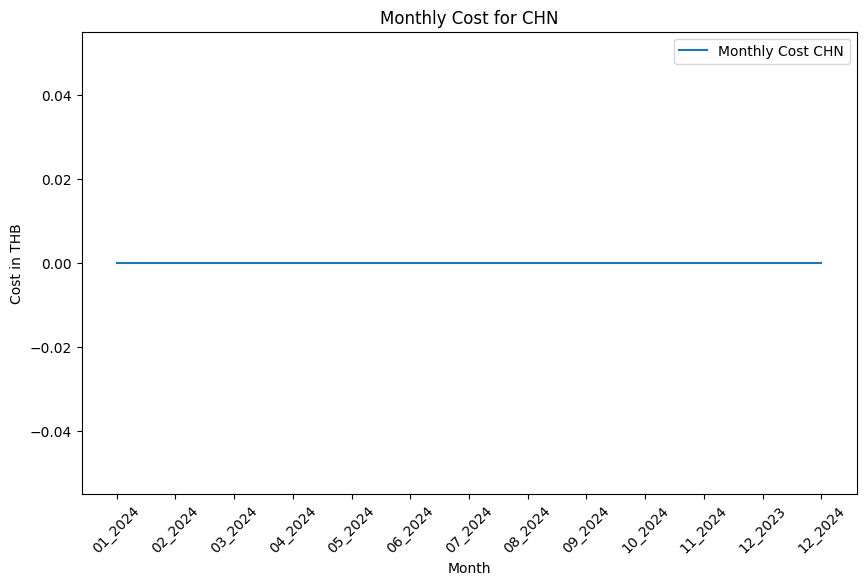

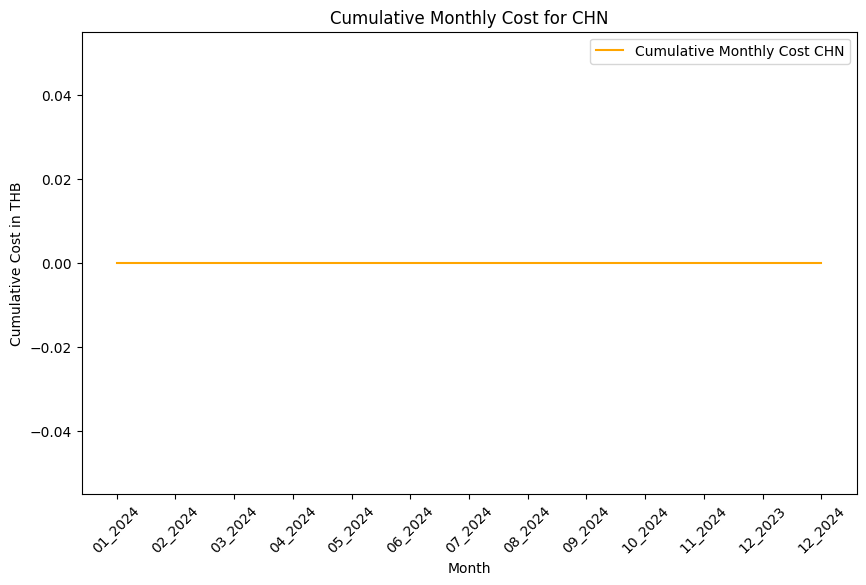

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from your directory (adjust path if necessary)
inventory_data = pd.read_csv('Inventory.csv', parse_dates=['BALANCE_AS_OF_DATE'])  # Corrected path for local environment
inbound_data = pd.read_csv('Inbound.csv', parse_dates=['INBOUND_DATE'])  # Corrected path for local environment
outbound_data = pd.read_csv('Outbound.csv', parse_dates=['OUTBOUND_DATE'])  # Corrected path for local environment

# Constants
SGD_TO_THAI = 25.45  # Conversion rate: SGD to THB
CNY_TO_THAI = 4.52   # Conversion rate: CNY to THB
USD_TO_THAI = 32.43  # Conversion rate: USD to THB
COST_STORAGE_SG = 15  # SGD per MT per day
COST_STORAGE_CN = 1.7 # CNY per MT per day

# Helper functions
def kg_to_mt(kg):
    return kg / 1000

# Inbound processing: Sum by PLANT_NAME and Day
inbound_data['DATE'] = inbound_data['INBOUND_DATE'].dt.strftime('%d_%m_%Y')
inbound_daily = inbound_data.groupby(['PLANT_NAME', 'DATE'])['NET_QUANTITY_MT'].sum().reset_index()

# Outbound processing: Sum by PLANT_NAME and Day
outbound_data['DATE'] = outbound_data['OUTBOUND_DATE'].dt.strftime('%d_%m_%Y')
outbound_daily = outbound_data.groupby(['PLANT_NAME', 'DATE'])['NET_QUANTITY_MT'].sum().reset_index()

# Inventory processing: Convert KG to MT, and sum by PLANT_NAME and Month
inventory_data['MONTH'] = inventory_data['BALANCE_AS_OF_DATE'].dt.strftime('%m_%Y')
inventory_data['UNRESTRICTED_STOCK_MT'] = inventory_data['UNRESRICTED_STOCK'] / 1000  # Convert KG to MT
inventory_monthly = inventory_data.groupby(['PLANT_NAME', 'MONTH'])['UNRESTRICTED_STOCK_MT'].sum().reset_index()

# Initialize results dictionary for storing daily costs and inventory
results = {}

# Step 4: Calculate Daily Costs (Using inventory from the previous month for the first day of the new month)
for plant in inbound_daily['PLANT_NAME'].unique():
    last_left_stock = 0  # Start with an initial value

    for date in inbound_daily['DATE'].unique():
        # Get inbound and outbound values for the specific date (use 0 if not found)
        inbound_value = inbound_daily[(inbound_daily['PLANT_NAME'] == plant) & (inbound_daily['DATE'] == date)]['NET_QUANTITY_MT'].sum()
        if inbound_value == 0:  # If no inbound data for the date, set to 0
            inbound_value = 0

        outbound_value = outbound_daily[(outbound_daily['PLANT_NAME'] == plant) & (outbound_daily['DATE'] == date)]['NET_QUANTITY_MT'].sum()
        if outbound_value == 0:  # If no outbound data for the date, set to 0
            outbound_value = 0

        # Find the closest available inventory date (previous month's end)
        inventory_date = (pd.to_datetime(date, format='%d_%m_%Y') - pd.DateOffset(days=1)).strftime('%m_%Y')  # Previous month
        inventory_value = inventory_monthly[(inventory_monthly['PLANT_NAME'] == plant) & (inventory_monthly['MONTH'] == inventory_date)]['UNRESTRICTED_STOCK_MT'].sum()

        # For the first day of the month, use the inventory from the previous month
        if last_left_stock == 0:
            last_left_stock = inventory_value + inbound_value - outbound_value
        else:
            last_left_stock += inbound_value - outbound_value

        # Store the calculated last_left_stock in results (use consistent date format)
        results[f'LAST_LEFT_{plant}_{date}'] = last_left_stock

        # Calculate daily cost in THB for Singapore and China
        if plant == 'SG':
            day_cost_sg = last_left_stock * COST_STORAGE_SG * SGD_TO_THAI
            results[f'DAY_COST_{plant}_{date}'] = day_cost_sg
        elif plant == 'CHN':
            day_cost_chn = last_left_stock * COST_STORAGE_CN * CNY_TO_THAI
            results[f'DAY_COST_{plant}_{date}'] = day_cost_chn

        # Print the variables for debugging
        print(f"\nData for {plant} on {date}:")
        print(f"Inbound Value: {inbound_value} MT")
        print(f"Outbound Value: {outbound_value} MT")
        print(f"Inventory Value (previous month's end): {inventory_value} MT")
        print(f"Last Left Stock: {last_left_stock} MT")
        print(f"Daily Cost for {plant} on {date}: {results.get(f'DAY_COST_{plant}_{date}', 'No cost calculated')} THB")

# Check if any data is missing for a specific date
print("\nKeys in results dictionary:")
print(results.keys())  # This will show all the generated keys for day costs

# Step 5: Calculate Monthly Costs and Average THB/MT
monthly_costs = {}
for plant in ['SG', 'CHN']:
    for month in inventory_monthly['MONTH'].unique():
        # Sum daily costs for the entire month
        daily_costs = [results.get(f'DAY_COST_{plant}_{date}') for date in results if f'{plant}_{month}' in date]
        total_month_cost = sum(daily_costs)

        # Sum the inventory for the month (in MT)
        total_inventory = inventory_monthly[(inventory_monthly['PLANT_NAME'] == plant) & (inventory_monthly['MONTH'] == month)]['UNRESTRICTED_STOCK_MT'].sum()

        # Calculate average cost per MT for the month
        avg_cost_per_mt = total_month_cost / total_inventory
        monthly_costs[f'MONTH_COST_{plant}_{month}'] = total_month_cost
        monthly_costs[f'AVG_COST_{plant}_{month}'] = avg_cost_per_mt

# Step 6: Plotting
# 5.1 Plot Daily Costs for CHN from November 2024 to January 2025
daily_cost_chn_data = [results[f'DAY_COST_CHN_{date}'] for date in results if 'CHN' in date]
dates = [date for date in results if 'CHN' in date]
plt.figure(figsize=(10, 6))
plt.plot(dates, daily_cost_chn_data, label='Daily Cost CHN')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cost in THB')
plt.title('Daily Cost for CHN (Nov 2024 to Jan 2025)')
plt.legend()
plt.show()

# 5.2 Plot Monthly Costs for CHN
monthly_cost_chn_data = [monthly_costs.get(f'MONTH_COST_CHN_{month}', 0) for month in inventory_monthly['MONTH'].unique()]
months = [month for month in inventory_monthly['MONTH'].unique()]
plt.figure(figsize=(10, 6))
plt.plot(months, monthly_cost_chn_data, label='Monthly Cost CHN')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Cost in THB')
plt.title('Monthly Cost for CHN')
plt.legend()
plt.show()

# 5.3 Cumulative Monthly Costs
cumulative_costs = [sum(monthly_cost_chn_data[:i+1]) for i in range(len(monthly_cost_chn_data))]
plt.figure(figsize=(10, 6))
plt.plot(months, cumulative_costs, label='Cumulative Monthly Cost CHN', color='orange')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Cumulative Cost in THB')
plt.title('Cumulative Monthly Cost for CHN')
plt.legend()
plt.show()
